<a href="https://colab.research.google.com/github/Joboreh97/Codes-that-function/blob/main/test_validation_2_epochs_0_7coderate_0_1phasenoise_2000batches_finetuning_retry_copy_withn_trained_const_256qam_structured_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

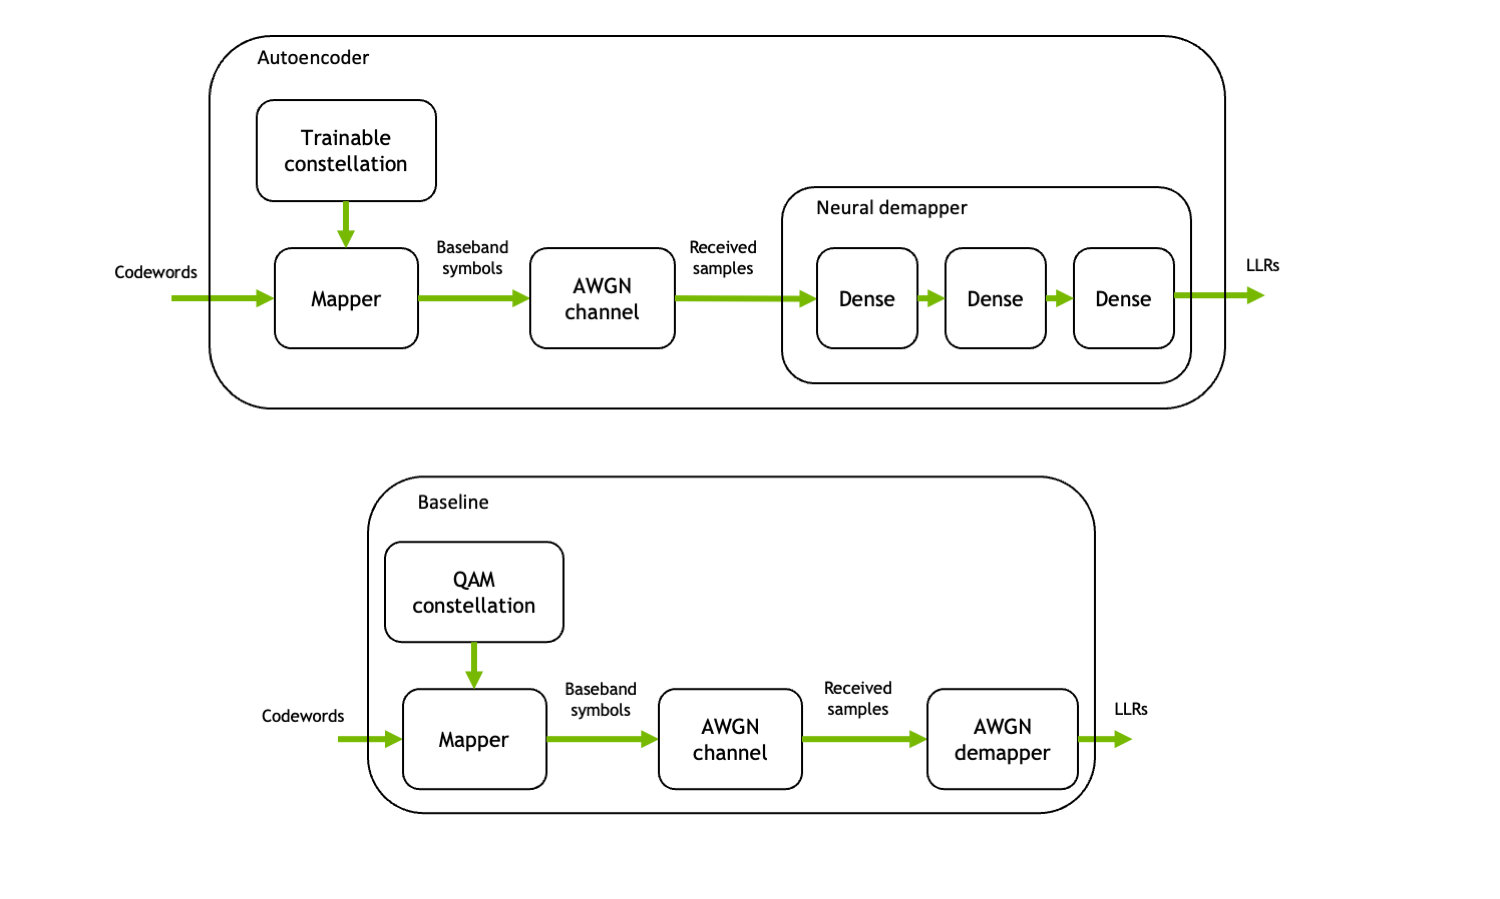


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [ ]:
!pip show tensorflow
!pip show tf_keras

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, sionna, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: tf_keras
Version: 2.19.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: tensorflow
Required-by: dopamine_rl, tensorflow-hub, tensorflow_decision_forests


In [ ]:
# ✅ Set this before importing TensorFlow to use legacy tf.keras (Keras 2)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Optional: Set GPU and logging behavior
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Add this to disable XNNPACK delegate for TFLite interpreter:
os.environ["TFLITE_ENABLE_XNNPACK"] = "0"
os.environ["TFLITE_DISABLE_SELECT_TF_OPS"] = "1"     # Add this
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"            # Add this too
# ✅ Now import TensorFlow and confirm it's using legacy Keras
import tensorflow as tf
import tf_keras
print("Legacy tf_keras version:", tf_keras.__version__)  # Should print 2.18.0

# ✅ Sionna setup
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Installing Sionna and restarting the runtime. Please run the cell again.")
        os.system("pip install sionna")
        os.kill(os.getpid(), 5)
    else:
        raise e

# ✅ GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# ✅ Suppress warnings from TF logger
tf.get_logger().setLevel('ERROR')

# ✅ Imports from tf.keras instead of standalone keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# ✅ Sionna imports
from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

# ✅ Seed
sionna.phy.config.seed = 42

# ✅ Jupyter/plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle


Legacy tf_keras version: 2.19.0


In [ ]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.5 MB/s eta 0:00:00


# Simulation Parameter

In [ ]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 40

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 8 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.7 # Coderate for the outer code
n = 2000 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 2000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700
num_training_iterations_rl_finetuning = 300
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_conventional_training_pruned = "awgn_autoencoder_weights_conventional_training_pruned" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_qat = "awgn_autoencoder_weights_qat" # Filename to save the autoencoder weights once QAT is done
model_weights_path_quantized_conventional_training = "awgn_autoencoder_quantized_weights_conventional_training"
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

# Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

**Neural Demapper for AWGN Channel**

In [ ]:
def preprocess_complex_input(y, no, num_symbols_per_codeword):
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    no_db = log10_fn(no)  # shape: [batch_size, 1]
    re = tf.math.real(y)  # shape: [batch_size, num_symbols_per_codeword]
    im = tf.math.imag(y)

    # Broadcast no_db to match shape of re: [batch_size, num_symbols_per_codeword]
    no_db = tf.broadcast_to(no_db, tf.shape(re))

    # Stack into shape: [batch_size, num_symbols_per_codeword, 3]
    z = tf.stack([re, im, no_db], axis=-1)
    return z

In [ ]:
from tensorflow.keras.layers import Input, Dense

def create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol):
    z_input = Input(shape=(num_symbols_per_codeword, 3), dtype=tf.float32, name="z_input")
    x = Dense(128, activation="relu")(z_input)
    x = Dense(128, activation="relu")(x)
    llr = Dense(num_bits_per_symbol)(x)
    return Model(inputs=z_input, outputs=llr, name="FunctionalDemapperReal")



In [ ]:
# import tensorflow_model_optimization as tfmot

# # Float32 demapper
# float_demapper = create_functional_demapper_real_input(
#     num_symbols_per_codeword, num_bits_per_symbol)

# # QAT wrapper
# qat_demapper_model = tfmot.quantization.keras.quantize_model(float_demapper)



**Neural Demapper for (Phase Noise + AWGN) Channel**

In [ ]:
import tensorflow as tf
from sionna.phy.utils import log10

def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
    """
    Preprocess inputs for the phase noise demapper *without* internal preprocessing.
    """
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    batch_size = tf.shape(y)[0]
    no = tf.convert_to_tensor(no, dtype=tf.float32)
    sigma_phi = tf.convert_to_tensor(sigma_phi, dtype=tf.float32)
    no = tf.reshape(no, [-1, 1]) if len(no.shape) < 2 else no
    sigma_phi = tf.reshape(sigma_phi, [-1, 1]) if len(sigma_phi.shape) < 2 else sigma_phi
    no_db = log10_fn(no)
    no_db_tiled = tf.tile(no_db, [1, num_symbols_per_codeword])
    sigma_phi_tiled = tf.tile(sigma_phi, [1, num_symbols_per_codeword])
    z = tf.stack([
        tf.math.real(y),
        tf.math.imag(y),
        no_db_tiled,
        sigma_phi_tiled
    ], axis=2)
    return z

512 Neurones Demapper

In [ ]:
def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(512, activation='relu', name='dense1')(z_input)
    x = Dense(512, activation='relu', name='dense2')(x)
    x = Dense(512, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise")
    return model


In [ ]:
float_demapper_phase_noise = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)

64 Neurones Demapper

In [ ]:
def create_256_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(256, activation='relu', name='dense1')(z_input)
    x = Dense(256, activation='relu', name='dense2')(x)
    x = Dense(256, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise")
    return model

In [ ]:
def create_64_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(64, activation='relu', name='dense1')(z_input)
    x = Dense(64, activation='relu', name='dense2')(x)
    x = Dense(64, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise64")
    return model

32 Neurones Demapper

In [ ]:
def create_32_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(32, activation='relu', name='dense1')(z_input)
    x = Dense(32, activation='relu', name='dense2')(x)
    x = Dense(32, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise32")
    return model


In [ ]:
def create_16_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(16, activation='relu', name='dense1')(z_input)
    x = Dense(16, activation='relu', name='dense2')(x)
    x = Dense(16, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise32")
    return model

**Demapper Prunning**

In [ ]:
pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,
}

In [ ]:
def create_pruned_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, pruning_params, bitwise=True):
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=pruning_params["initial_sparsity"],
        final_sparsity=pruning_params["final_sparsity"],
        begin_step=pruning_params["begin_step"],
        end_step=pruning_params["end_step"],
    )
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense1'), pruning_schedule=pruning_schedule)(z_input)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense2'), pruning_schedule=pruning_schedule)(x)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense3'), pruning_schedule=pruning_schedule)(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = prune_low_magnitude(Dense(output_units, activation=None, name='pruned_dense_out'), pruning_schedule=pruning_schedule)(x)
    model = Model(inputs=z_input, outputs=llr, name="PrunedFunctionalDemapperPhaseNoise")
    return model

In [ ]:
class StructuredPruningCallback(tf.keras.callbacks.Callback):
    """
    Applies structured pruning with persistent mask enforcement.
    """

    def __init__(self, pruning_params, prune_every_n_steps=10):
        super().__init__()
        self.initial_sparsity = pruning_params["initial_sparsity"]
        self.final_sparsity = pruning_params["final_sparsity"]
        self.begin_step = pruning_params["begin_step"]
        self.end_step = pruning_params["end_step"]
        self.prune_every_n_steps = prune_every_n_steps
        self.current_step = 0
        self.neuron_masks = {}
        self.pruning_finalized = False

    def on_train_batch_end(self, batch, logs=None):
        """Enforce mask AFTER each gradient update"""
        self.current_step += 1

        # Compute and update masks during pruning phase
        if self.current_step % self.prune_every_n_steps == 0 and self.current_step <= self.end_step:
            if self.current_step < self.begin_step:
                return

            progress = (self.current_step - self.begin_step) / (self.end_step - self.begin_step)
            current_sparsity = self.final_sparsity + (self.initial_sparsity - self.final_sparsity) * (1 - progress) ** 3

            demapper = self.model._demapper

            for layer in demapper.layers:
                if not isinstance(layer, tf.keras.layers.Dense) or 'out' in layer.name.lower():
                    continue

                weights, biases = layer.get_weights()
                neuron_importance = np.linalg.norm(weights, axis=0)
                num_neurons = weights.shape[1]
                num_keep = int(num_neurons * (1 - current_sparsity))

                important_indices = np.argsort(neuron_importance)[-num_keep:]
                mask = np.zeros(num_neurons)
                mask[important_indices] = 1.0

                self.neuron_masks[layer.name] = mask
                weights_masked = weights * mask[np.newaxis, :]
                layer.set_weights([weights_masked, biases])

            if self.current_step % 100 == 0:
                print(f"\nStep {self.current_step}: Structured pruning to {current_sparsity*100:.1f}% sparsity")

            if self.current_step >= self.end_step:
                self.pruning_finalized = True
                print(f"\n⭐ Pruning finalized! Mask will be enforced for remaining {4000 - self.current_step} steps")

        # Enforce mask after pruning phase
        elif self.pruning_finalized:
            demapper = self.model._demapper
            for layer in demapper.layers:
                if layer.name in self.neuron_masks:
                    weights, biases = layer.get_weights()
                    mask = self.neuron_masks[layer.name]
                    weights_masked = weights * mask[np.newaxis, :]
                    layer.set_weights([weights_masked, biases])

In [ ]:
# class StructuredPruningCallback(tf.keras.callbacks.Callback):
#     """
#     Applies structured pruning (removes entire neurons) at each training step.
#     Mimics TensorFlow's unstructured pruning but prunes whole columns.
#     """

#     def __init__(self, pruning_params, start_step=0, prune_every_n_steps=10):
#         super().__init__()
#         self.initial_sparsity = pruning_params["initial_sparsity"]
#         self.final_sparsity = pruning_params["final_sparsity"]
#         self.begin_step = pruning_params["begin_step"]
#         self.end_step = pruning_params["end_step"]
#         self.prune_every_n_steps = prune_every_n_steps
#         self.current_step = 0

#     def on_batch_end(self, batch, logs=None):
#         """Called after each training batch"""
#         self.current_step += 1

#         # Only prune at specified intervals
#         if self.current_step % self.prune_every_n_steps != 0:
#             return

#         # Only prune within the pruning window
#         if self.current_step < self.begin_step or self.current_step > self.end_step:
#             return

#         # Calculate current target sparsity (polynomial decay)
#         if self.current_step >= self.end_step:
#             current_sparsity = self.final_sparsity
#         else:
#             # Polynomial decay: cubic polynomial
#             progress = (self.current_step - self.begin_step) / (self.end_step - self.begin_step)
#             current_sparsity = self.final_sparsity + (self.initial_sparsity - self.final_sparsity) * (1 - progress) ** 3

#         # Apply structured pruning to demapper
#         demapper = self.model._demapper

#         for layer in demapper.layers:
#             if not isinstance(layer, tf.keras.layers.Dense):
#                 continue

#             # ⭐ SKIP OUTPUT LAYER (keep all 8 bits)
#             if 'out' in layer.name.lower():
#                 continue

#             weights, biases = layer.get_weights()

#             # Calculate neuron importance (L2 norm of each column)
#             neuron_importance = np.linalg.norm(weights, axis=0)  # Shape: (512,)

#             num_neurons = weights.shape[1]
#             num_keep = int(num_neurons * (1 - current_sparsity))

#             # Keep most important neurons
#             important_indices = np.argsort(neuron_importance)[-num_keep:]

#             # Create mask (1 for important, 0 for unimportant)
#             mask = np.zeros(num_neurons)
#             mask[important_indices] = 1.0

#             # Zero out unimportant neurons (entire columns)
#             weights_masked = weights * mask[np.newaxis, :]

#             # Set masked weights back
#             layer.set_weights([weights_masked, biases])

#         # Print progress occasionally
#         if self.current_step % 100 == 0:
#             print(f"\nStep {self.current_step}: Structured pruning to {current_sparsity*100:.1f}% sparsity")



In [ ]:
# import tensorflow as tf
# import numpy as np

# class TrueStructuredPruningCallback(tf.keras.callbacks.Callback):
#     """
#     Custom callback that applies TRUE structured pruning during training.
#     Removes entire neurons (columns) based on L2 norm at each epoch.
#     """
#     def __init__(self, target_sparsity=0.875, start_epoch=0, end_epoch=2):
#         super().__init__()
#         self.target_sparsity = target_sparsity
#         self.start_epoch = start_epoch
#         self.end_epoch = end_epoch
#         self.current_sparsity = 0.0

#     def on_epoch_end(self, epoch, logs=None):
#         if epoch < self.start_epoch:
#             return

#         # Calculate current target sparsity (gradually increase)
#         if epoch >= self.end_epoch:
#             self.current_sparsity = self.target_sparsity
#         else:
#             progress = (epoch - self.start_epoch) / (self.end_epoch - self.start_epoch)
#             self.current_sparsity = self.target_sparsity * progress

#         print(f"\n{'='*80}")
#         print(f"Applying Structured Pruning - Epoch {epoch + 1}")
#         print(f"Target sparsity: {self.current_sparsity * 100:.1f}%")
#         print(f"{'='*80}")

#         # Apply structured pruning to demapper
#         demapper = self.model._demapper

#         for layer in demapper.layers:
#             if not isinstance(layer, tf.keras.layers.Dense):
#                 continue

#             weights, biases = layer.get_weights()

#             # Calculate neuron importance (L2 norm) - weights is already numpy!
#             neuron_importance = np.linalg.norm(weights, axis=0)

#             num_neurons = weights.shape[1]
#             num_keep = int(num_neurons * (1 - self.current_sparsity))

#             # Keep most important neurons
#             important_indices = np.argsort(neuron_importance)[-num_keep:]

#             # Create mask (1 for important, 0 for unimportant)
#             mask = np.zeros(num_neurons)
#             mask[important_indices] = 1.0

#             # Zero out unimportant neurons
#             weights_masked = weights * mask[np.newaxis, :]

#             # Set masked weights back
#             layer.set_weights([weights_masked, biases])

#             zero_cols = np.sum(np.all(np.abs(weights_masked) < 1e-9, axis=0))
#             print(f"  {layer.name}: {weights.shape} → {zero_cols}/{num_neurons} columns zeroed")

#         print(f"{'='*80}\n")

In [ ]:
def create_structured_pruned_functional_demapper_phase_noise_from_preprocessed(
    num_bits_per_symbol,
    pruning_params,
    block_size=(1, 64),
    bitwise=True
):
    """
    Create a 512-unit demapper for TRUE structured pruning.
    During training, neurons will be progressively removed.

    This starts as 512 units, but structured pruning callback will zero out
    entire columns, effectively reducing to 64 units.
    """
    print("\n" + "="*80)
    print("CREATING DEMAPPER FOR TRUE STRUCTURED PRUNING")
    print(f"Initial: 512 units → Target: 64 units (87.5% pruned)")
    print("="*80)

    # Start with FULL 512-unit architecture
    z_input = tf.keras.Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = tf.keras.layers.Dense(512, activation='relu', name='structured_pruned_dense1')(z_input)
    x = tf.keras.layers.Dense(512, activation='relu', name='structured_pruned_dense2')(x)
    x = tf.keras.layers.Dense(512, activation='relu', name='structured_pruned_dense3')(x)

    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = tf.keras.layers.Dense(output_units, activation=None, name='structured_pruned_dense_out')(x)

    model = tf.keras.Model(inputs=z_input, outputs=llr, name="StructuredPrunedDemapper")

    print(f"✓ Created 512-unit model (will be pruned to 64 during training)")
    print("="*80)

    return model

In [ ]:
def extract_truly_smaller_model(pruned_demapper, target_sparsity=0.875):
    """
    After training with structured pruning, extract a genuinely smaller model.
    This removes the zero columns to create a compact 64-unit network.
    PRESERVES all output layer neurons (8 bits).
    """
    print("\n" + "="*80)
    print("EXTRACTING TRULY SMALLER MODEL FROM PRUNED WEIGHTS")
    print("="*80)

    pruned_weights = []
    layer_sizes = []

    for i, layer in enumerate(pruned_demapper.layers):
        if not isinstance(layer, tf.keras.layers.Dense):
            continue

        weights, biases = layer.get_weights()

        # ⭐ Check if this is the output layer
        is_output_layer = ('out' in layer.name.lower() or
                          i == len([l for l in pruned_demapper.layers if isinstance(l, tf.keras.layers.Dense)]) - 1)

        if is_output_layer:
            # Keep ALL neurons in output layer
            print(f"\n{layer.name} (OUTPUT LAYER):")
            print(f"  Shape: {weights.shape}")
            print(f"  ⭐ Preserving all {weights.shape[1]} output neurons (bits)")

            pruned_weights.append((weights, biases))
            layer_sizes.append(weights.shape[1])
        else:
            # For hidden layers, remove zero columns
            zero_mask = np.all(np.abs(weights) < 1e-9, axis=0)
            nonzero_indices = np.where(~zero_mask)[0]

            print(f"\n{layer.name}:")
            print(f"  Original shape: {weights.shape}")
            print(f"  Non-zero columns: {len(nonzero_indices)}/{weights.shape[1]}")

            weights_compact = weights[:, nonzero_indices]
            biases_compact = biases[nonzero_indices]

            print(f"  Pruned shape: {weights_compact.shape}")

            layer_sizes.append(weights_compact.shape[1])
            pruned_weights.append((weights_compact, biases_compact))

    print("\n" + "="*80)
    print("BUILDING COMPACT MODEL")
    print("="*80)

    z_input = tf.keras.Input(shape=(250, 4), dtype=tf.float32, name="z_input")

    x = tf.keras.layers.Dense(layer_sizes[0], activation='relu', name='compact_dense1')(z_input)
    x = tf.keras.layers.Dense(layer_sizes[1], activation='relu', name='compact_dense2')(x)
    x = tf.keras.layers.Dense(layer_sizes[2], activation='relu', name='compact_dense3')(x)
    llr = tf.keras.layers.Dense(layer_sizes[3], activation=None, name='compact_dense_out')(x)

    compact_model = tf.keras.Model(inputs=z_input, outputs=llr, name="CompactStructuredDemapper")

    print(f"\nCompact architecture:")
    print(f"  Input (4) → Layer1 ({layer_sizes[0]}) → Layer2 ({layer_sizes[1]}) → Layer3 ({layer_sizes[2]}) → Output ({layer_sizes[3]})")

    # Adjust weights for connectivity (same as before)
    print("\n" + "="*80)
    print("ADJUSTING WEIGHTS FOR LAYER CONNECTIVITY")
    print("="*80)

    adjusted_weights = []

    for i, (weights, biases) in enumerate(pruned_weights):
        if i == 0:
            adjusted_weights.append((weights, biases))
            print(f"Layer {i+1}: {weights.shape} (no adjustment needed)")
        else:
            prev_layer_weights = pruned_weights[i-1][0]
            prev_nonzero_cols = np.where(~np.all(np.abs(prev_layer_weights) < 1e-9, axis=0))[0]
            weights_row_pruned = weights[prev_nonzero_cols, :]
            adjusted_weights.append((weights_row_pruned, biases))
            print(f"Layer {i+1}: {weights.shape} → {weights_row_pruned.shape} (rows pruned)")

    # Load weights
    print("\n" + "="*80)
    print("LOADING WEIGHTS INTO COMPACT MODEL")
    print("="*80)

    dense_layer_idx = 0
    for layer in compact_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            if dense_layer_idx < len(adjusted_weights):
                weights, biases = adjusted_weights[dense_layer_idx]
                print(f"{layer.name}: Loading weights {weights.shape}")
                layer.set_weights([weights, biases])
                dense_layer_idx += 1

    print(f"\n✓ Compact model created: {compact_model.count_params():,} parameters")
    print(f"⭐ Output layer: {layer_sizes[3]} bits PRESERVED")
    print("="*80)

    return compact_model




In [ ]:
# def extract_truly_smaller_model(pruned_demapper, target_sparsity=0.875):
#     """
#     After training with structured pruning, extract a genuinely smaller model.
#     This removes the zero columns to create a compact 64-unit network.
#     """
#     print("\n" + "="*80)
#     print("EXTRACTING TRULY SMALLER MODEL FROM PRUNED WEIGHTS")
#     print("="*80)

#     pruned_weights = []
#     layer_sizes = []  # Track surviving neuron counts

#     for layer in pruned_demapper.layers:
#         if not isinstance(layer, tf.keras.layers.Dense):
#             continue

#         weights, biases = layer.get_weights()

#         # Find non-zero columns (surviving neurons)
#         zero_mask = np.all(np.abs(weights) < 1e-9, axis=0)
#         nonzero_indices = np.where(~zero_mask)[0]

#         print(f"\n{layer.name}:")
#         print(f"  Original shape: {weights.shape}")
#         print(f"  Non-zero columns: {len(nonzero_indices)}/{weights.shape[1]}")

#         # Extract only non-zero columns (surviving output neurons)
#         weights_compact = weights[:, nonzero_indices]
#         biases_compact = biases[nonzero_indices]

#         print(f"  Pruned shape: {weights_compact.shape}")

#         layer_sizes.append(weights_compact.shape[1])  # Track output size
#         pruned_weights.append((weights_compact, biases_compact))

#     print("\n" + "="*80)
#     print("BUILDING COMPACT MODEL")
#     print("="*80)

#     # Build new compact model with correct architecture
#     z_input = tf.keras.Input(shape=(250, 4), dtype=tf.float32, name="z_input")

#     # Layer 1: input (4) → surviving neurons from layer 1
#     x = tf.keras.layers.Dense(layer_sizes[0], activation='relu', name='compact_dense1')(z_input)

#     # Layer 2: surviving from layer 1 → surviving from layer 2
#     x = tf.keras.layers.Dense(layer_sizes[1], activation='relu', name='compact_dense2')(x)

#     # Layer 3: surviving from layer 2 → surviving from layer 3
#     x = tf.keras.layers.Dense(layer_sizes[2], activation='relu', name='compact_dense3')(x)

#     # Output layer: surviving from layer 3 → output bits
#     llr = tf.keras.layers.Dense(layer_sizes[3], activation=None, name='compact_dense_out')(x)

#     compact_model = tf.keras.Model(inputs=z_input, outputs=llr, name="CompactStructuredDemapper")

#     print(f"\nCompact architecture:")
#     print(f"  Input (4) → Layer1 ({layer_sizes[0]}) → Layer2 ({layer_sizes[1]}) → Layer3 ({layer_sizes[2]}) → Output ({layer_sizes[3]})")

#     # Now we need to handle the input dimension mismatch for layer 2 and 3
#     # We need to prune the ROWS of subsequent layers to match surviving neurons

#     print("\n" + "="*80)
#     print("ADJUSTING WEIGHTS FOR LAYER CONNECTIVITY")
#     print("="*80)

#     adjusted_weights = []

#     for i, (weights, biases) in enumerate(pruned_weights):
#         if i == 0:
#             # First layer: keep as is (input dimension is fixed at 4)
#             adjusted_weights.append((weights, biases))
#             print(f"Layer {i+1}: {weights.shape} (no adjustment needed)")
#         else:
#             # Subsequent layers: need to prune ROWS to match previous layer's surviving neurons
#             # Find which rows (input connections) are non-zero
#             prev_layer_weights = pruned_weights[i-1][0]
#             prev_nonzero_cols = np.where(~np.all(np.abs(prev_layer_weights) < 1e-9, axis=0))[0]

#             # Prune rows of current layer to match surviving neurons from previous layer
#             weights_row_pruned = weights[prev_nonzero_cols, :]

#             adjusted_weights.append((weights_row_pruned, biases))
#             print(f"Layer {i+1}: {weights.shape} → {weights_row_pruned.shape} (rows pruned)")

#     # Load adjusted weights into compact model
#     print("\n" + "="*80)
#     print("LOADING WEIGHTS INTO COMPACT MODEL")
#     print("="*80)

#     dense_layer_idx = 0
#     for layer in compact_model.layers:
#         if isinstance(layer, tf.keras.layers.Dense):
#             if dense_layer_idx < len(adjusted_weights):
#                 weights, biases = adjusted_weights[dense_layer_idx]
#                 print(f"{layer.name}: Loading weights {weights.shape}")
#                 layer.set_weights([weights, biases])
#                 dense_layer_idx += 1

#     print(f"\n✓ Compact model created: {compact_model.count_params():,} parameters")
#     print("="*80)

#     return compact_model


In [ ]:
# def create_structured_pruned_functional_demapper_phase_noise_from_preprocessed(
#     num_bits_per_symbol,
#     pruning_params,
#     block_size=(1, 64),  # Key parameter for structured pruning
#     bitwise=True
# ):
#     """
#     Create a demapper with structured (neuron-level) pruning.
#     block_size=(1, 64) means prune entire blocks of 64 neurons at a time.
#     """
#     pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
#         initial_sparsity=pruning_params["initial_sparsity"],
#         final_sparsity=pruning_params["final_sparsity"],
#         begin_step=pruning_params["begin_step"],
#         end_step=pruning_params["end_step"],
#     )

#     prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

#     z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")

#     # Structured pruning with block_size
#     x = prune_low_magnitude(
#         Dense(512, activation='relu', name='structured_pruned_dense1'),
#         pruning_schedule=pruning_schedule,
#         block_size=block_size,
#         block_pooling_type='AVG'
#     )(z_input)

#     x = prune_low_magnitude(
#         Dense(512, activation='relu', name='structured_pruned_dense2'),
#         pruning_schedule=pruning_schedule,
#         block_size=block_size,
#         block_pooling_type='AVG'
#     )(x)

#     x = prune_low_magnitude(
#         Dense(512, activation='relu', name='structured_pruned_dense3'),
#         pruning_schedule=pruning_schedule,
#         block_size=block_size,
#         block_pooling_type='AVG'
#     )(x)

#     output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
#     llr = prune_low_magnitude(
#         Dense(output_units, activation=None, name='structured_pruned_dense_out'),
#         pruning_schedule=pruning_schedule,
#         block_size=(1, min(2, output_units)),  # Smaller block for output layer
#         block_pooling_type='AVG'
#     )(x)

#     model = Model(inputs=z_input, outputs=llr, name="StructuredPrunedFunctionalDemapperPhaseNoise")
#     return model

**Phase Noise**

In [ ]:
class PhaseNoise(Block):
    def __init__(self, *, precision=None, **kwargs):
        super().__init__(precision=precision, **kwargs)

    def call(self, x, sigma):
        phi = tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=1.0,
            dtype=self.rdtype
        )
        sigma = expand_to_rank(sigma, tf.rank(x), axis=-1)
        sigma = tf.cast(sigma, self.rdtype)
        phi *= sigma
        phase_rotation = tf.complex(tf.math.cos(phi), tf.math.sin(phi))
        return x * phase_rotation


**Phase Noise Gaussian**

In [ ]:
class PhaseNoiseGaussian(tf.keras.layers.Layer):
    def __init__(self, dtype=tf.complex64, name="phase_noise_gaussian", **kwargs):
        super().__init__(dtype=dtype, name=name, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype
        self.start_phase_init = -1*np.pi
        self.start_phase_width = np.pi

    def call(self, inputs):
        print('*********Inside Gaussian Distributed PN************')
        x, sigma_phi = inputs
        var = 1.0
        var_dim = tf.cast(var, x.dtype.real_dtype)/tf.cast(2, x.dtype.real_dtype)
        stddev = tf.sqrt(var_dim)
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype.real_dtype)
        sigma_phi = expand_to_rank(sigma_phi, tf.rank(x), axis=-1)
        sigma_phi = tf.cast(sigma_phi, self._real_dtype)
        noise *= tf.cast(sigma_phi, noise.dtype)
        pnr = tf.math.cos(noise)
        pni = tf.math.sin(noise)
        pn = tf.complex(pnr,pni)
        return x*pn

## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [ ]:
import tensorflow as tf

class DynamicBinarySource(tf.keras.layers.Layer):
    """Custom binary source layer supporting dynamic batch sizes"""
    def __init__(self, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)

    def call(self, shape):
        # shape: Tensor containing [batch_size, num_bits]
        u = tf.random.uniform(shape, minval=0, maxval=1, dtype=self.dtype)
        return tf.where(u < 0.5, 0.0, 1.0)

In [ ]:
import tensorflow as tf
import math
import tensorflow_model_optimization as tfmot

sigmaphi = 0.1
stddev_sigmaphi = math.sqrt(sigmaphi)

class E2ESystemConventionalTraining(tf.keras.Model):
    def __init__(self, training, use_pruning=False, pruning_params=None,
                 use_structured_pruning=False, block_size=(1, 64),  # NEW PARAMETERS
                 pretrained_weights_path=None, demapper_type='512', name="e2e_system"):
        super().__init__(name=name)
        self._training = training
        self._use_pruning = use_pruning
        self._use_structured_pruning = use_structured_pruning  # NEW
        self._demapper_type = demapper_type

        self._binary_source = DynamicBinarySource(dtype=tf.float32)
        self._num_bits_per_symbol = num_bits_per_symbol
        self._code_rate = k / n

        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        qam_points = Constellation("qam", num_bits_per_symbol).points
        initial_points_r = tf.math.real(qam_points)
        initial_points_i = tf.math.imag(qam_points)

        self.points_r = self.add_weight(name='points_r', shape=initial_points_r.shape, initializer="zeros")
        self.points_i = self.add_weight(name='points_i', shape=initial_points_i.shape, initializer="zeros")
        self.points_r.assign(initial_points_r)
        self.points_i.assign(initial_points_i)

        points = tf.complex(self.points_r, self.points_i)
        self.constellation = Constellation("custom", num_bits_per_symbol, points=points, normalize=True, center=True)
        self._mapper = Mapper(constellation=self.constellation)

        self._phase_noise = PhaseNoiseGaussian(name="phase_noise")
        self._channel = AWGN()

        # DEMAPPER CREATION WITH STRUCTURED PRUNING SUPPORT
        if self._use_structured_pruning and pruning_params is not None:  # NEW
            # Structured pruning
            self._demapper = create_structured_pruned_functional_demapper_phase_noise_from_preprocessed(
                num_bits_per_symbol, pruning_params, block_size=block_size, bitwise=True)
        elif self._use_pruning and pruning_params is not None:
            # Unstructured pruning (original)
            self._demapper = create_pruned_functional_demapper_phase_noise_from_preprocessed(
                num_bits_per_symbol, pruning_params, bitwise=True)
        else:
            # Dense (no pruning)
            if demapper_type == '512':
                self._demapper = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '256':
                self._demapper = create_256_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '64':
                self._demapper = create_64_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '32':
                self._demapper = create_32_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '16':
                self._demapper = create_16_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            else:
                raise ValueError(f"Unsupported demapper_type: {demapper_type}. Use '512', '64', '32', or '16'.")

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, inputs, training=False):
        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points
        if self._training:
            c = inputs[0]
            ebno_db = inputs[1]
        else:
            if not (isinstance(inputs, (tuple, list)) and len(inputs) == 2):
                raise ValueError("Input must be a tuple (x, ebno_db).")
            x, ebno_db = inputs
            batch_size = tf.shape(x)[0]

        if not self._training:
            shape = tf.stack([batch_size, k])
            b = self._binary_source(shape)
            c = self._encoder(b)

        x_mapped = self._mapper(c)
        batch_size = tf.shape(x_mapped)[0]  # Safe to use now

        sigma_phi_tensor = tf.fill([batch_size, 1], stddev_sigmaphi)
        x_phase_noisy = self._phase_noise((x_mapped, sigma_phi_tensor))
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._code_rate)

        y = self._channel(x_phase_noisy, no)

        z = preprocess_complex_phase_noise_input(y, no, sigma_phi_tensor, num_symbols_per_codeword)
        llr = self._demapper(z)

        if self._training:
            c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])
            loss = self._bce(c_reshaped, llr)
            return loss
        else:
            llr_reshaped = tf.reshape(llr, [batch_size, n])
            b_hat = self._decoder(llr_reshaped)
            return b, b_hat
    def call_with_intermediates(self, inputs, training=False):
        """
        Return a dictionary with intermediate constellation stages for plotting:
        - 'awgn_only': Symbols corrupted by AWGN only
        - 'phase_only': Symbols corrupted by phase noise only
        - 'joint': Symbols corrupted by both AWGN and phase noise
        """
        if not (isinstance(inputs, (tuple, list)) and len(inputs) == 2):
            raise ValueError("Input must be a tuple (x, ebno_db).")
        x, ebno_db = inputs
        batch_size = tf.shape(x)[0]

        # Generate info bits and coded bits for this batch (like in evaluation call)
        shape = tf.stack([batch_size, k])
        b = self._binary_source(shape)
        c = self._encoder(b)

        x_mapped = self._mapper(c)
        sigma_phi_tensor = tf.fill([batch_size, 1], stddev_sigmaphi)
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._code_rate)

        # Apply impairments separately
        x_phase_noisy = self._phase_noise((x_mapped, sigma_phi_tensor))  # Only phase noise
        x_awgn_only = self._channel(x_mapped, no)                        # Only AWGN
        x_joint = self._channel(x_phase_noisy, no)                       # Both

        return {
            "awgn_only": x_awgn_only,
            "phase_only": x_phase_noisy,
            "joint": x_joint
        }

    def train_step(self, data):
          (inputs, _labels) = data  # Unpack ((x, ebno_db), None)
          with tf.GradientTape() as tape:
              loss = self(inputs, training=True)  # Now inputs = (x, ebno_db)
          gradients = tape.gradient(loss, self.trainable_variables)
          self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
          return {"loss": loss}





A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [ ]:
def print_pruned_layer_sparsity(layer):
    for weight in layer.weights:
        w = weight.numpy()
        sparsity = np.mean(w == 0)
        print(f"{layer.name} ({weight.name}): sparsity = {sparsity:.3f}")

def print_model_sparsity(model):
    for layer in model.layers:
        print_pruned_layer_sparsity(layer)

**Training Pipeline**

In [ ]:
def gen():
    for _ in range(num_training_iterations_conventional):
        ebno_db = tf.random.uniform(
            shape=(training_batch_size,),  # shape = (batch_size,)
            minval=ebno_db_min,
            maxval=ebno_db_max,
            dtype=tf.float32
        )
        c = tf.random.uniform(
            shape=(training_batch_size, n),
            minval=0,
            maxval=2,
            dtype=tf.int32
        )
        c = tf.cast(c, tf.float32)
        yield (c, ebno_db), c  # inputs=(c, ebno_db), labels=c


data_gen = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        (
            tf.TensorSpec(shape=(training_batch_size, n), dtype=tf.float32),     # c
            tf.TensorSpec(shape=(training_batch_size,), dtype=tf.float32)        # ebno_db
        ),
        tf.TensorSpec(shape=(training_batch_size, n), dtype=tf.float32)          # label c
    )
).prefetch(tf.data.AUTOTUNE)



In [ ]:
import numpy as np

num_val_batches = 100  # set according to your validation_steps
val_c = np.random.randint(0, 2, (num_val_batches * training_batch_size, n)).astype(np.float32)
val_ebno = np.random.uniform(ebno_db_min, ebno_db_max, (num_val_batches * training_batch_size)).astype(np.float32)


def val_gen():
    for i in range(num_val_batches):
        sl0 = i * training_batch_size
        sl1 = (i + 1) * training_batch_size
        yield (val_c[sl0:sl1], val_ebno[sl0:sl1]), val_c[sl0:sl1]
data_val_gen = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        (
            tf.TensorSpec((training_batch_size, n), tf.float32),
            tf.TensorSpec((training_batch_size,), tf.float32)
        ),
        tf.TensorSpec((training_batch_size, n), tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)



In [ ]:
# 1. Train the 512-unit dense model
print("Training conventional model (512-unit demapper)...")
model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='512')
model_conventional.compile(optimizer=tf.keras.optimizers.Adam())

history_512_unit = model_conventional.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_conventional.save_weights('conventional_weights_512_8bit.h5')


# ============================================================================
# STEP 6: TRAIN WITH TRUE STRUCTURED PRUNING
# ============================================================================

print("\n" + "="*80)
print("STRUCTURED PRUNING: Training with TensorFlow's built-in infrastructure...")
print("="*80)

structured_pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,  # ✅ Same as unstructured!
}

# Create model with structured pruning
model_structured_pruned_from_pretrained = E2ESystemConventionalTraining(
    training=True,
    use_pruning=False,
    use_structured_pruning=True,
    pruning_params=structured_pruning_params,
    block_size=(1, 64),
    demapper_type='512'
)
model_structured_pruned_from_pretrained.compile(optimizer=tf.keras.optimizers.Adam())

# Build and load pretrained weights
dummy_input = (tf.zeros([1, n]), tf.zeros([1]))
model_structured_pruned_from_pretrained(dummy_input, training=False)
model_structured_pruned_from_pretrained.load_weights('conventional_weights_512_8bit.h5',
                                                      by_name=True, skip_mismatch=True)

# Create structured pruning callback
structured_pruning_callback = StructuredPruningCallback(
    pruning_params=structured_pruning_params,
    prune_every_n_steps=10  # Prune every 10 steps (100 times during training)
)

# Train (identical to unstructured)
history_structured_pruned = model_structured_pruned_from_pretrained.fit(
    data_gen,
    epochs=2,  # ✅ Same 2 epochs as unstructured!
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100,
    callbacks=[structured_pruning_callback]
)

# Verify pruning
print("\n" + "="*80)
print("VERIFYING STRUCTURED PRUNING")
print("="*80)
for layer in model_structured_pruned_from_pretrained._demapper.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights, _ = layer.get_weights()
        zero_cols = np.sum(np.all(np.abs(weights) < 1e-9, axis=0))
        sparsity = (zero_cols / weights.shape[1]) * 100

        if 'out' in layer.name.lower():
            print(f"{layer.name} (OUTPUT): {weights.shape}, {zero_cols}/{weights.shape[1]} columns zeroed ({sparsity:.1f}%) ⭐ NOT PRUNED")
        else:
            print(f"{layer.name}: {weights.shape}, {zero_cols}/{weights.shape[1]} columns zeroed ({sparsity:.1f}%)")


# Save
model_structured_pruned_from_pretrained.save_weights(
    'model_weights_structured_pruned_from_pretrained_512_to_64.h5'
)

print("\n✓ Structured pruning training complete!")
print("="*80)

# 2. Train the 64-unit dense model
print("Training 64-unit model...")
model_64unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='64')
model_64unit.compile(optimizer=tf.keras.optimizers.Adam())

history_64_unit = model_64unit.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_64unit.save_weights('model_weights_64unit.h5')

# 3. Train the 32-unit dense model
print("Training 32-unit model...")
model_32unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='32')
model_32unit.compile(optimizer=tf.keras.optimizers.Adam())

history_32_unit = model_32unit.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_32unit.save_weights('model_weights_32unit.h5')

# 4. Train the 16-unit dense model
print("Training 16-unit model...")
model_16unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='16')
model_16unit.compile(optimizer=tf.keras.optimizers.Adam())

history_16_unit = model_16unit.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_16unit.save_weights('model_weights_16unit.h5')

# 5. Fine-tune pruned model (starting from pretrained 512-unit)
print("Pruning and fine-tuning the pretrained 512-unit model...")
model_pruned_from_pretrained = E2ESystemConventionalTraining(
    training=True,
    use_pruning=True,
    pruning_params=pruning_params,
    demapper_type='512'
)
model_pruned_from_pretrained.compile(optimizer=tf.keras.optimizers.Adam())

# Build the model (required for weight loading)
dummy_input = (tf.zeros([1, n]), tf.zeros([1]))

model_pruned_from_pretrained(dummy_input, training=False)

# Load pretrained dense weights
model_pruned_from_pretrained.load_weights('conventional_weights_512_8bit.h5', by_name=True, skip_mismatch=True)

pruning_callbacks_transfer = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_transfer')
]

history_pruned_from_pretrained = model_pruned_from_pretrained.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100,
    callbacks=pruning_callbacks_transfer
)

print("\nPruned demapper sparsity BEFORE stripping:")
print_model_sparsity(model_pruned_from_pretrained._demapper)

# Strip pruning wrappers for final saved model
model_pruned_from_pretrained._demapper = tfmot.sparsity.keras.strip_pruning(model_pruned_from_pretrained._demapper)

print("\nPruned demapper sparsity AFTER stripping:")
print_model_sparsity(model_pruned_from_pretrained._demapper)

model_pruned_from_pretrained.save_weights('model_weights_pruned_from_pretrained_512_to_8bit_64_equivalent.h5')




Training conventional model (512-unit demapper)...
Epoch 1/2
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
2000/2000 - 79s - loss: 0.2136 - val_loss: 0.0000e+00 - 79s/epoch - 40ms/step
Epoch 2/2
2000/2000 - 69s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 69s/epoch - 34ms/step

STRUCTURED PRUNING: Training with TensorFlow's built-in infrastructure...

CREATING DEMAPPER FOR TRUE STRUCTURED PRUNING
Initial: 512 units → Target: 64 units (87.5% pruned)
✓ Created 512-unit model (will be pruned to 64 during training)
*********Inside Gaussian Distributed PN************
Epoch 1/2
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************

Step 100: Structured pruning to 23.7% sparsity

Step 200: Structured pruning to 42.7% sparsity

Step 300: Structured pruning to 57.5% sparsity

Step 400: Structured pruning to 68.6% sparsity

Step 500: Struc

In [ ]:
# # 1. Train the 512-unit dense model
# print("Training conventional model (512-unit demapper)...")
# model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='512')
# model_conventional.compile(optimizer=tf.keras.optimizers.Adam())

# history_512_unit = model_conventional.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen,
#     validation_steps=100
# )
# model_conventional.save_weights('conventional_weights_512_8bit.h5')


# print("\n" + "="*80)
# print("STRUCTURED PRUNING: Pruning and fine-tuning the pretrained 512-unit model...")
# print("="*80)

# structured_pruning_params = {
#     "initial_sparsity": 0.0,
#     "final_sparsity": 0.875,  # Same 87.5% sparsity
#     "begin_step": 0,
#     "end_step": 1000,
# }

# model_structured_pruned_from_pretrained = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=False,  # Don't use unstructured
#     use_structured_pruning=True,  # Use structured instead
#     pruning_params=structured_pruning_params,
#     block_size=(1, 64),  # Prune in blocks of 64 neurons
#     demapper_type='512'
# )
# model_structured_pruned_from_pretrained.compile(optimizer=tf.keras.optimizers.Adam())

# # Build the model
# dummy_input = (tf.zeros([1, n]), tf.zeros([1]))
# model_structured_pruned_from_pretrained(dummy_input, training=False)

# # Load pretrained dense weights
# print("Loading pretrained 512-unit weights...")
# model_structured_pruned_from_pretrained.load_weights('conventional_weights_512_8bit.h5', by_name=True, skip_mismatch=True)

# structured_pruning_callbacks = [
#     tfmot.sparsity.keras.UpdatePruningStep(),
#     tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_structured')
# ]

# print("Fine-tuning with structured pruning...")
# history_structured_pruned = model_structured_pruned_from_pretrained.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen,
#     validation_steps=100,
#     callbacks=structured_pruning_callbacks
# )

# print("\nStructured pruned demapper sparsity BEFORE stripping:")
# print_model_sparsity(model_structured_pruned_from_pretrained._demapper)

# # Strip pruning wrappers
# model_structured_pruned_from_pretrained._demapper = tfmot.sparsity.keras.strip_pruning(
#     model_structured_pruned_from_pretrained._demapper
# )

# print("\nStructured pruned demapper sparsity AFTER stripping:")
# print_model_sparsity(model_structured_pruned_from_pretrained._demapper)

# # Verify structure
# print("\n" + "="*80)
# print("VERIFYING STRUCTURED PRUNING")
# print("="*80)
# for layer in model_structured_pruned_from_pretrained._demapper.layers:
#     if isinstance(layer, tf.keras.layers.Dense):
#         weights, _ = layer.get_weights()
#         zero_cols = np.sum(np.all(np.abs(weights) < 1e-9, axis=0))
#         print(f"{layer.name}: Shape {weights.shape}, Zero columns (dead neurons): {zero_cols}")

# model_structured_pruned_from_pretrained.save_weights('model_weights_structured_pruned_from_pretrained_512_to_64.h5')

# print("\n✓ Structured pruning training complete!")


# # 2. Train the 64-unit dense model
# print("Training 64-unit model...")
# model_64unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='64')
# model_64unit.compile(optimizer=tf.keras.optimizers.Adam())

# history_64_unit = model_64unit.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen,
#     validation_steps=100
# )
# model_64unit.save_weights('model_weights_64unit.h5')

# # 3. Train the 32-unit dense model
# print("Training 32-unit model...")
# model_32unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='32')
# model_32unit.compile(optimizer=tf.keras.optimizers.Adam())

# history_32_unit = model_32unit.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen,
#     validation_steps=100
# )
# model_32unit.save_weights('model_weights_32unit.h5')

# # 4. Train the 16-unit dense model
# print("Training 16-unit model...")
# model_16unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='16')
# model_16unit.compile(optimizer=tf.keras.optimizers.Adam())

# history_16_unit = model_16unit.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen,
#     validation_steps=100
# )
# model_16unit.save_weights('model_weights_16unit.h5')

# # 5. Fine-tune pruned model (starting from pretrained 512-unit)
# print("Pruning and fine-tuning the pretrained 512-unit model...")
# model_pruned_from_pretrained = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=True,
#     pruning_params=pruning_params,
#     demapper_type='512'
# )
# model_pruned_from_pretrained.compile(optimizer=tf.keras.optimizers.Adam())

# # Build the model (required for weight loading)
# dummy_input = (tf.zeros([1, n]), tf.zeros([1]))

# model_pruned_from_pretrained(dummy_input, training=False)

# # Load pretrained dense weights
# model_pruned_from_pretrained.load_weights('conventional_weights_512_8bit.h5', by_name=True, skip_mismatch=True)

# pruning_callbacks_transfer = [
#     tfmot.sparsity.keras.UpdatePruningStep(),
#     tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_transfer')
# ]

# history_pruned_from_pretrained = model_pruned_from_pretrained.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen,
#     validation_steps=100,
#     callbacks=pruning_callbacks_transfer
# )

# print("\nPruned demapper sparsity BEFORE stripping:")
# print_model_sparsity(model_pruned_from_pretrained._demapper)

# # Strip pruning wrappers for final saved model
# model_pruned_from_pretrained._demapper = tfmot.sparsity.keras.strip_pruning(model_pruned_from_pretrained._demapper)

# print("\nPruned demapper sparsity AFTER stripping:")
# print_model_sparsity(model_pruned_from_pretrained._demapper)

# model_pruned_from_pretrained.save_weights('model_weights_pruned_from_pretrained_512_to_8bit_64_equivalent.h5')




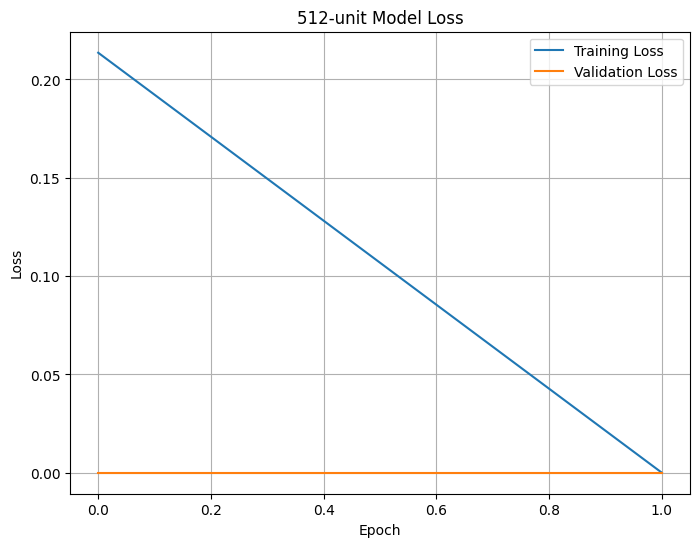

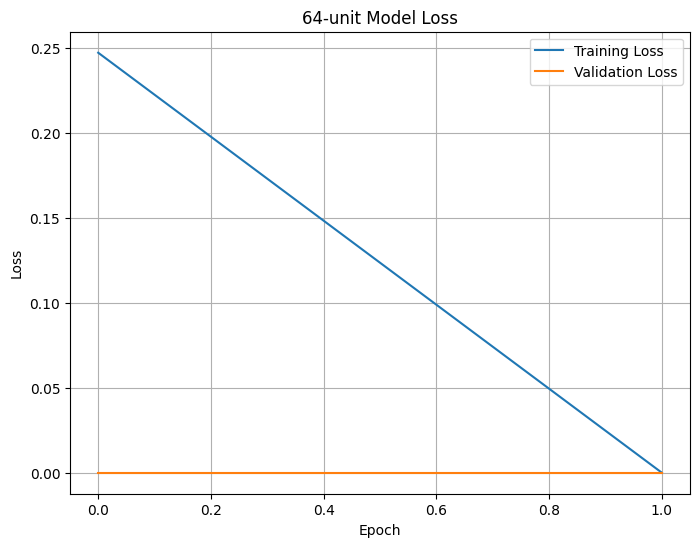

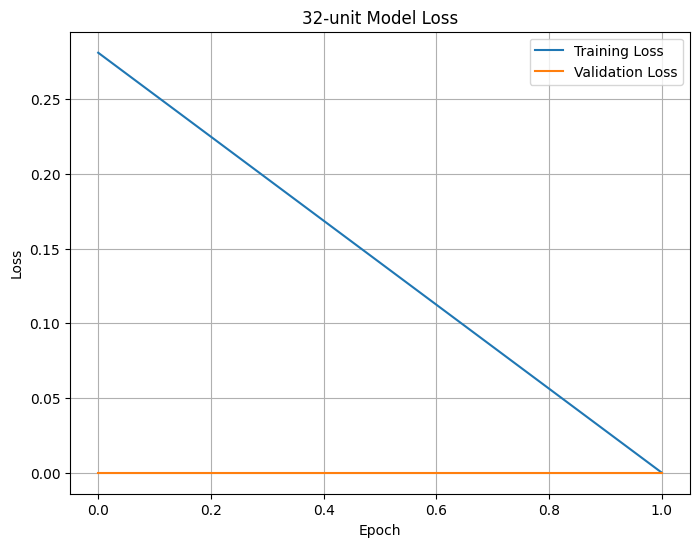

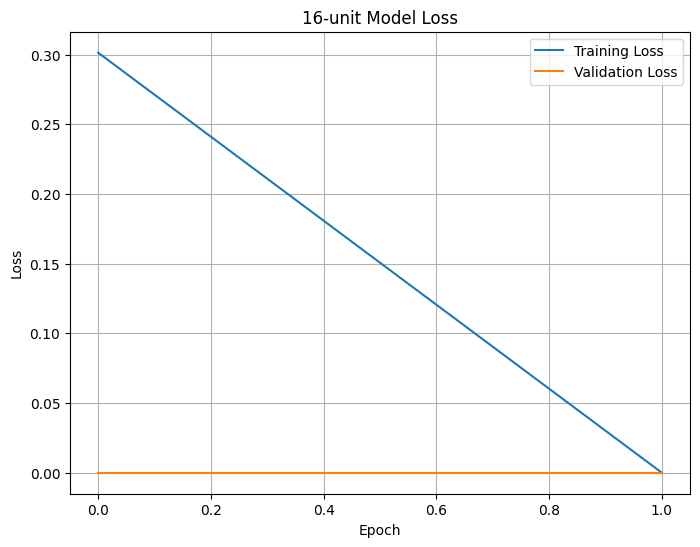

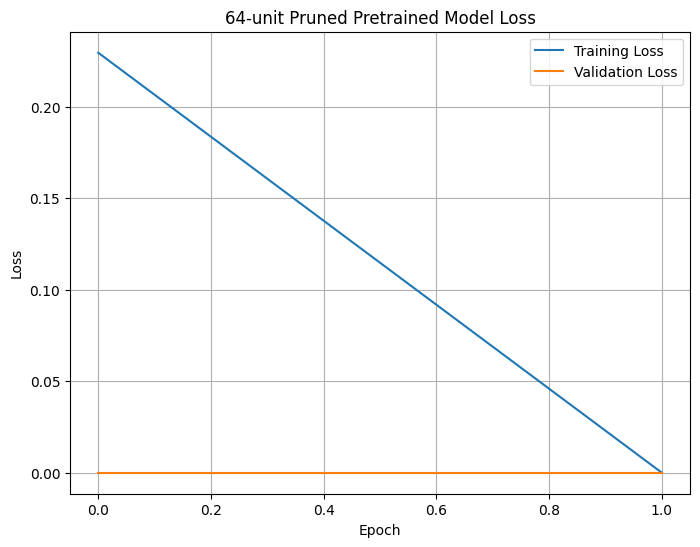

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history: # Check if validation loss was recorded
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# After training each model, call this function:
plot_loss(history_512_unit, '512-unit Model Loss')
plot_loss(history_64_unit, '64-unit Model Loss')
plot_loss(history_32_unit, '32-unit Model Loss')
plot_loss(history_16_unit, '16-unit Model Loss')
plot_loss(history_pruned_from_pretrained, '64-unit Pruned Pretrained Model Loss')
# ... and so on for other models

**Evaluation Pipeline**

In [ ]:
# Conventional evaluation model
model_conventional_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='512'
)
dummy_input = (tf.zeros([1, n]), tf.zeros([1]))

model_conventional_eval(dummy_input, training=False)
model_conventional_eval.load_weights('conventional_weights_512_8bit.h5')

# 64-unit evaluation model
model_64unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='64'
)
model_64unit_eval(dummy_input, training=False)
model_64unit_eval.load_weights('model_weights_64unit.h5')

# 32-unit evaluation model
model_32unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='32'
)
model_32unit_eval(dummy_input, training=False)
model_32unit_eval.load_weights('model_weights_32unit.h5')


# 16-unit evaluation model
model_16unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='16'
)
model_16unit_eval(dummy_input, training=False)
model_16unit_eval.load_weights('model_weights_16unit.h5')

pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,
}


model_pruned_from_pretrained_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    pruning_params=pruning_params,
    demapper_type='512'
)
model_pruned_from_pretrained_eval(dummy_input, training=False)
model_pruned_from_pretrained_eval.load_weights('model_weights_pruned_from_pretrained_512_to_8bit_64_equivalent.h5')


print("\nLoading Structured Pruned model for evaluation...")
model_structured_pruned_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    use_structured_pruning=True,
    pruning_params=structured_pruning_params,
    demapper_type='512'
)
model_structured_pruned_eval(dummy_input, training=False)
model_structured_pruned_eval.load_weights('model_weights_structured_pruned_from_pretrained_512_to_64.h5')

# ⭐ DETAILED VERIFICATION
print("\n" + "="*80)
print("DETAILED VERIFICATION OF LOADED WEIGHTS")
print("="*80)

for layer in model_structured_pruned_eval._demapper.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights, _ = layer.get_weights()
        zero_mask = np.abs(weights) < 1e-9

        # Detailed analysis
        zero_cols = np.sum(np.all(zero_mask, axis=0))
        total_zeros = np.sum(zero_mask)
        total_elements = weights.size

        print(f"\n{layer.name}:")
        print(f"  Shape: {weights.shape}")
        print(f"  Zero columns (structured): {zero_cols}/{weights.shape[1]}")
        print(f"  Total zeros: {total_zeros}/{total_elements}")
        print(f"  Overall sparsity: {100*total_zeros/total_elements:.1f}%")
        print(f"  Min weight: {np.min(np.abs(weights[~zero_mask])):.6f}" if not np.all(zero_mask) else "  All zeros!")
        print(f"  Max weight: {np.max(np.abs(weights)):.6f}")

        # Sample the weight matrix
        print(f"  Sample weights (first 4 neurons):")
        print(f"    Neuron 0: {weights[:min(4, weights.shape[0]), 0]}")
        print(f"    Neuron 63: {weights[:min(4, weights.shape[0]), 63] if weights.shape[1] > 63 else 'N/A'}")
        print(f"    Neuron 64: {weights[:min(4, weights.shape[0]), 64] if weights.shape[1] > 64 else 'N/A'}")
        print(f"    Neuron 65: {weights[:min(4, weights.shape[0]), 65] if weights.shape[1] > 65 else 'N/A'}")

print("="*80)

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************

Loading Structured Pruned model for evaluation...

CREATING DEMAPPER FOR TRUE STRUCTURED PRUNING
Initial: 512 units → Target: 64 units (87.5% pruned)
✓ Created 512-unit model (will be pruned to 64 during training)
*********Inside Gaussian Distributed PN************

DETAILED VERIFICATION OF LOADED WEIGHTS

structured_pruned_dense1:
  Shape: (4, 512)
  Zero columns (structured): 448/512
  Total zeros: 1792/2048
  Overall sparsity: 87.5%
  Min weight: 0.003514
  Max weight: 1.196824
  Sample weights (first 4 neurons):
    Neuron 0: [ 0.  0. -0.  0.]
    Neuron 63: [ 0.49018747  0.5815835  -0.10618383 -0.2080669 ]
    Neuron 64: [ 0.  0.  0. -0.]
    Neuron 65: [ 0. -0.  0.  0.]

structured_pruned_dense2:
  Shape: (512, 512)
  Zero 

In [ ]:
def create_truly_sparse_demapper(dense_pruned_demapper):
    """
    Create a demapper that uses TensorFlow sparse operations.
    This will actually skip zero-weight computations.

    Args:
        dense_pruned_demapper: The demapper after strip_pruning (still has zeros but in dense format)

    Returns:
        A new functional model using sparse operations
    """
    import tensorflow as tf

    # Extract layer information
    layers_info = []
    for layer in dense_pruned_demapper.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()

            # Convert to sparse representation (keep only non-zero weights)
            non_zero_mask = tf.abs(weights) > 1e-9
            indices = tf.where(non_zero_mask)
            values = tf.gather_nd(weights, indices)

            print(f"Layer {layer.name}: Original size {weights.shape}, Non-zero values: {len(values)}/{weights.size} ({100*len(values)/weights.size:.2f}%)")

            layers_info.append({
                'name': layer.name,
                'sparse_indices': indices.numpy(),
                'sparse_values': values.numpy(),
                'shape': weights.shape,
                'biases': biases,
                'activation': layer.activation.__name__ if layer.activation else None
            })

    # Build new functional model using sparse operations
    class SparseDemapper(tf.keras.Model):
        def __init__(self, layers_info, name="sparse_demapper"):
            super().__init__(name=name)
            self.sparse_layers = []

            for info in layers_info:
                # Create sparse tensor
                sparse_tensor = tf.sparse.SparseTensor(
                    indices=info['sparse_indices'],
                    values=tf.constant(info['sparse_values'], dtype=tf.float32),
                    dense_shape=info['shape']
                )
                # Reorder to CSR format for efficient matrix multiplication
                sparse_tensor = tf.sparse.reorder(sparse_tensor)

                self.sparse_layers.append({
                    'name': info['name'],
                    'weights': sparse_tensor,
                    'biases': tf.constant(info['biases'], dtype=tf.float32),
                    'activation': info['activation']
                })

        def call(self, inputs):
            # Input shape: (batch_size, num_symbols, 4)
            original_shape = tf.shape(inputs)
            batch_size = original_shape[0]
            num_symbols = original_shape[1]

            # Flatten to (batch_size * num_symbols, 4)
            x = tf.reshape(inputs, [-1, tf.shape(inputs)[-1]])

            # Process through sparse layers
            for layer_info in self.sparse_layers:
                # Sparse matrix multiplication
                # x shape: (N, in_features) where N = batch_size * num_symbols
                # weights shape: (in_features, out_features) as SparseTensor
                # We want output: (N, out_features)

                # tf.sparse.sparse_dense_matmul expects (sparse_rows, sparse_cols) @ (dense_rows, dense_cols)
                # where sparse_cols must equal dense_rows
                # So we do: (in_features, out_features)^T @ (in_features, N)^T = (out_features, N)
                # Then transpose to get (N, out_features)

                x_transposed = tf.transpose(x)  # (in_features, N)
                result = tf.sparse.sparse_dense_matmul(
                    layer_info['weights'],
                    x_transposed,
                    adjoint_a=True  # Transpose sparse weights from (in, out) to (out, in)
                )
                x = tf.transpose(result)  # (N, out_features)

                # Add bias
                x = x + layer_info['biases']

                # Apply activation
                if layer_info['activation'] == 'relu':
                    x = tf.nn.relu(x)
                elif layer_info['activation'] == 'sigmoid':
                    x = tf.nn.sigmoid(x)
                elif layer_info['activation'] == 'tanh':
                    x = tf.nn.tanh(x)
                # linear activation: do nothing

            # Reshape output to (batch_size, num_symbols, num_bits_per_symbol)
            x = tf.reshape(x, [batch_size, num_symbols, num_bits_per_symbol])
            return x

    return SparseDemapper(layers_info)

# ============================================================================
# CREATE SPARSE VERSION OF PRUNED MODEL
# ============================================================================

print("\n" + "="*80)
print("CREATING TRULY SPARSE DEMAPPER FROM PRUNED MODEL")
print("="*80)

# Create sparse demapper from the pruned model
sparse_demapper = create_truly_sparse_demapper(model_pruned_from_pretrained_eval._demapper)

# Create a new evaluation model that uses the sparse demapper
class E2ESystemWithSparseDemapper(tf.keras.Model):
    def __init__(self, base_model, sparse_demapper, name="e2e_sparse"):
        super().__init__(name=name)
        # Copy everything from base model except demapper
        self._binary_source = base_model._binary_source
        self._encoder = base_model._encoder
        self._mapper = base_model._mapper
        self._phase_noise = base_model._phase_noise
        self._channel = base_model._channel
        self._decoder = base_model._decoder
        self._num_bits_per_symbol = base_model._num_bits_per_symbol
        self._code_rate = base_model._code_rate

        # Use sparse demapper
        self._demapper = sparse_demapper

        # Copy constellation points
        self.points_r = base_model.points_r
        self.points_i = base_model.points_i
        self.constellation = base_model.constellation

    def call(self, inputs, training=False):
        x, ebno_db = inputs
        batch_size = tf.shape(x)[0]

        # Generate bits and encode
        shape = tf.stack([batch_size, k])
        b = self._binary_source(shape)
        c = self._encoder(b)

        # Map to constellation
        x_mapped = self._mapper(c)

        # Add phase noise
        sigma_phi_tensor = tf.fill([batch_size, 1], stddev_sigmaphi)
        x_phase_noisy = self._phase_noise((x_mapped, sigma_phi_tensor))

        # Add AWGN
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._code_rate)
        y = self._channel(x_phase_noisy, no)

        # Preprocess and demap using SPARSE demapper
        z = preprocess_complex_phase_noise_input(y, no, sigma_phi_tensor, num_symbols_per_codeword)
        llr = self._demapper(z)

        # Decode
        llr_reshaped = tf.reshape(llr, [batch_size, n])
        b_hat = self._decoder(llr_reshaped)

        return b, b_hat

# Create sparse evaluation model
model_pruned_sparse_eval = E2ESystemWithSparseDemapper(
    model_pruned_from_pretrained_eval,
    sparse_demapper
)

print("Sparse demapper created successfully!")
print("="*80 + "\n")



CREATING TRULY SPARSE DEMAPPER FROM PRUNED MODEL
Layer dense1: Original size (4, 512), Non-zero values: 256/2048 (12.50%)
Layer dense2: Original size (512, 512), Non-zero values: 32768/262144 (12.50%)
Layer dense3: Original size (512, 512), Non-zero values: 32768/262144 (12.50%)
Layer dense_out: Original size (512, 8), Non-zero values: 512/4096 (12.50%)
Sparse demapper created successfully!



In [ ]:
def extract_truly_smaller_model(pruned_demapper, target_sparsity=0.875):
    """
    After training with structured pruning, extract a genuinely smaller model.
    This removes the zero columns to create a compact 64-unit network.
    PRESERVES all output layer neurons (8 bits).
    """
    print("\n" + "="*80)
    print("EXTRACTING TRULY SMALLER MODEL FROM PRUNED WEIGHTS")
    print("="*80)

    pruned_weights = []
    layer_sizes = []

    # First pass: identify all dense layers
    dense_layers = [l for l in pruned_demapper.layers if isinstance(l, tf.keras.layers.Dense)]

    for i, layer in enumerate(pruned_demapper.layers):
        if not isinstance(layer, tf.keras.layers.Dense):
            continue

        weights, biases = layer.get_weights()

        # ⭐ FIXED: Check if this is the ACTUAL output layer (last dense layer OR has 'out' in name)
        is_output_layer = (layer == dense_layers[-1]) or ('out' in layer.name.lower())

        if is_output_layer:
            # Keep ALL neurons in output layer
            print(f"\n{layer.name} (OUTPUT LAYER):")
            print(f"  Shape: {weights.shape}")
            print(f"  ⭐ Preserving all {weights.shape[1]} output neurons (bits)")

            pruned_weights.append((weights, biases))
            layer_sizes.append(weights.shape[1])
        else:
            # For hidden layers, remove zero columns
            zero_mask = np.all(np.abs(weights) < 1e-9, axis=0)
            nonzero_indices = np.where(~zero_mask)[0]

            print(f"\n{layer.name}:")
            print(f"  Original shape: {weights.shape}")
            print(f"  Non-zero columns: {len(nonzero_indices)}/{weights.shape[1]}")

            weights_compact = weights[:, nonzero_indices]
            biases_compact = biases[nonzero_indices]

            print(f"  Pruned shape: {weights_compact.shape}")

            layer_sizes.append(weights_compact.shape[1])
            pruned_weights.append((weights_compact, biases_compact))

    print("\n" + "="*80)
    print("BUILDING COMPACT MODEL")
    print("="*80)

    # Verify we have exactly 4 layers
    if len(layer_sizes) != 4:
        raise ValueError(f"Expected 4 layers, got {len(layer_sizes)}: {layer_sizes}")

    # Verify output layer has 8 neurons
    if layer_sizes[3] != 8:
        raise ValueError(f"Output layer should have 8 neurons, got {layer_sizes[3]}")

    z_input = tf.keras.Input(shape=(250, 4), dtype=tf.float32, name="z_input")

    x = tf.keras.layers.Dense(layer_sizes[0], activation='relu', name='compact_dense1')(z_input)
    x = tf.keras.layers.Dense(layer_sizes[1], activation='relu', name='compact_dense2')(x)
    x = tf.keras.layers.Dense(layer_sizes[2], activation='relu', name='compact_dense3')(x)
    llr = tf.keras.layers.Dense(layer_sizes[3], activation=None, name='compact_dense_out')(x)

    compact_model = tf.keras.Model(inputs=z_input, outputs=llr, name="CompactStructuredDemapper")

    print(f"\nCompact architecture:")
    print(f"  Input (4) → Layer1 ({layer_sizes[0]}) → Layer2 ({layer_sizes[1]}) → Layer3 ({layer_sizes[2]}) → Output ({layer_sizes[3]})")

    # Adjust weights for connectivity
    print("\n" + "="*80)
    print("ADJUSTING WEIGHTS FOR LAYER CONNECTIVITY")
    print("="*80)

    adjusted_weights = []

    for i, (weights, biases) in enumerate(pruned_weights):
        if i == 0:
            # First layer: input dimension is fixed at 4
            adjusted_weights.append((weights, biases))
            print(f"Layer {i+1}: {weights.shape} (no adjustment needed)")
        else:
            # Subsequent layers: prune rows to match previous layer's surviving neurons
            prev_layer_weights = adjusted_weights[i-1][0]  # Use adjusted weights from previous iteration

            # Number of surviving neurons in previous layer = number of columns in previous layer
            prev_surviving_neurons = prev_layer_weights.shape[1]

            # Current layer should have rows matching previous layer's output
            if weights.shape[0] != pruned_weights[i-1][0].shape[1]:
                # Need to prune rows
                prev_nonzero_cols = np.where(~np.all(np.abs(pruned_weights[i-1][0]) < 1e-9, axis=0))[0]
                weights_row_pruned = weights[prev_nonzero_cols, :]
            else:
                # Already matches (e.g., output layer after pruned layer 3)
                weights_row_pruned = weights[:prev_surviving_neurons, :]

            adjusted_weights.append((weights_row_pruned, biases))
            print(f"Layer {i+1}: {weights.shape} → {weights_row_pruned.shape} (rows adjusted)")

    # Load weights
    print("\n" + "="*80)
    print("LOADING WEIGHTS INTO COMPACT MODEL")
    print("="*80)

    dense_layer_idx = 0
    for layer in compact_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            if dense_layer_idx < len(adjusted_weights):
                weights, biases = adjusted_weights[dense_layer_idx]
                print(f"{layer.name}: Loading weights {weights.shape}")
                layer.set_weights([weights, biases])
                dense_layer_idx += 1

    print(f"\n✓ Compact model created: {compact_model.count_params():,} parameters")
    print(f"⭐ Output layer: {layer_sizes[3]} bits PRESERVED")
    print("="*80)

    return compact_model

In [ ]:
# ============================================================================
# WRAPPER CLASS - Same as your sparse version
# ============================================================================

class E2ESystemWithCustomDemapper(tf.keras.Model):
    """
    Wrapper for E2E system with a custom demapper.
    Works for BOTH sparse and truly structured demappers.
    """
    def __init__(self, base_model, custom_demapper, name="e2e_custom"):
        super().__init__(name=name)
        # Copy everything from base model
        self._binary_source = base_model._binary_source
        self._encoder = base_model._encoder
        self._mapper = base_model._mapper
        self._phase_noise = base_model._phase_noise
        self._channel = base_model._channel
        self._decoder = base_model._decoder
        self._num_bits_per_symbol = base_model._num_bits_per_symbol
        self._code_rate = base_model._code_rate

        # Use custom demapper
        self._demapper = custom_demapper

        # Copy constellation points
        self.points_r = base_model.points_r
        self.points_i = base_model.points_i
        self.constellation = base_model.constellation

    def call(self, inputs, training=False):
        x, ebno_db = inputs
        batch_size = tf.shape(x)[0]

        shape = tf.stack([batch_size, k])
        b = self._binary_source(shape)
        c = self._encoder(b)

        x_mapped = self._mapper(c)

        sigma_phi_tensor = tf.fill([batch_size, 1], stddev_sigmaphi)
        x_phase_noisy = self._phase_noise((x_mapped, sigma_phi_tensor))

        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._code_rate)
        y = self._channel(x_phase_noisy, no)

        z = preprocess_complex_phase_noise_input(y, no, sigma_phi_tensor, num_symbols_per_codeword)
        llr = self._demapper(z)

        llr_reshaped = tf.reshape(llr, [batch_size, n])
        b_hat = self._decoder(llr_reshaped)

        return b, b_hat

    # Version 2: Compact structured (truly 64 units) - for fast inference
print("\n" + "="*80)
print("CREATING COMPACT STRUCTURED MODEL")
print("="*80)


# Extract compact 64-unit model from the full-size one
compact_structured_demapper = extract_truly_smaller_model(
    model_structured_pruned_eval._demapper,
    target_sparsity=0.875
)

# Wrap in E2E system
model_structured_compact_eval = E2ESystemWithCustomDemapper(
    model_structured_pruned_eval,
    compact_structured_demapper,
    name="e2e_structured_compact"
)

print("✓ Compact structured model created (truly 64 units)")
print("="*80)

print("\n✓ All evaluation models loaded!")


CREATING COMPACT STRUCTURED MODEL

EXTRACTING TRULY SMALLER MODEL FROM PRUNED WEIGHTS

structured_pruned_dense1:
  Original shape: (4, 512)
  Non-zero columns: 64/512
  Pruned shape: (4, 64)

structured_pruned_dense2:
  Original shape: (512, 512)
  Non-zero columns: 64/512
  Pruned shape: (512, 64)

structured_pruned_dense3:
  Original shape: (512, 512)
  Non-zero columns: 64/512
  Pruned shape: (512, 64)

structured_pruned_dense_out (OUTPUT LAYER):
  Shape: (512, 8)
  ⭐ Preserving all 8 output neurons (bits)

BUILDING COMPACT MODEL

Compact architecture:
  Input (4) → Layer1 (64) → Layer2 (64) → Layer3 (64) → Output (8)

ADJUSTING WEIGHTS FOR LAYER CONNECTIVITY
Layer 1: (4, 64) (no adjustment needed)
Layer 2: (512, 64) → (64, 64) (rows adjusted)
Layer 3: (512, 64) → (64, 64) (rows adjusted)
Layer 4: (512, 8) → (64, 8) (rows adjusted)

LOADING WEIGHTS INTO COMPACT MODEL
compact_dense1: Loading weights (4, 64)
compact_dense2: Loading weights (64, 64)
compact_dense3: Loading weights (64


Visualizing Structured Pruned Demapper...
WEIGHT MATRIX STRUCTURE ANALYSIS

Layer: structured_pruned_dense1
Weight matrix shape: (4, 512)
Total weights: 2,048
Zero weights: 1,792
Non-zero weights: 256
Sparsity: 87.50%
Zero rows: 0/4
Zero cols: 448/512
→ STRUCTURED PRUNING detected
✓ Saved combined PNG: structured_weight_visualization_structured_pruned_dense1.png


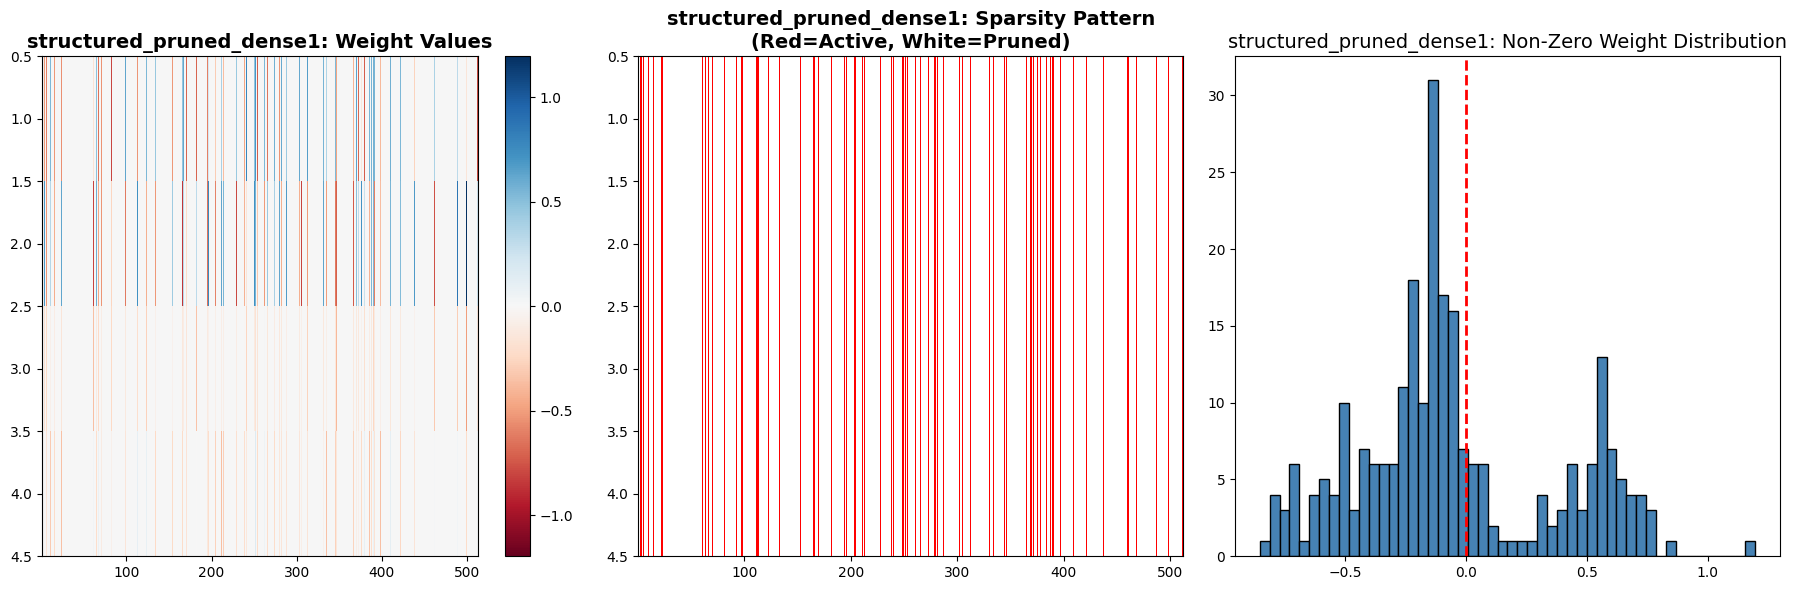

✓ Saved individual sparsity PNG: structured_sparsity_only_structured_pruned_dense1.png
✓ Saved individual sparsity PDF: structured_sparsity_only_structured_pruned_dense1.pdf
✓ Saved individual sparsity SVG: structured_sparsity_only_structured_pruned_dense1.svg
✓ Saved CSV: structured_sparsity_data_structured_pruned_dense1.csv
✓ Saved TikZ: structured_sparsity_pattern_structured_pruned_dense1.tex
✓ Saved TikZ histogram: structured_weight_histogram_structured_pruned_dense1.tex

Sample from weight matrix:
[[ 0.          0.         -0.5040247   0.72860926  0.         -0.6039558
  -0.          0.        ]
 [ 0.         -0.          0.6863532  -0.13172372 -0.         -0.5244806
  -0.         -0.        ]
 [-0.          0.         -0.17317824 -0.12602068  0.         -0.22658953
   0.          0.        ]
 [ 0.          0.         -0.01180541 -0.14586498  0.         -0.16783106
  -0.          0.        ]]

Layer: structured_pruned_dense2
Weight matrix shape: (512, 512)
Total weights: 262,144
Z

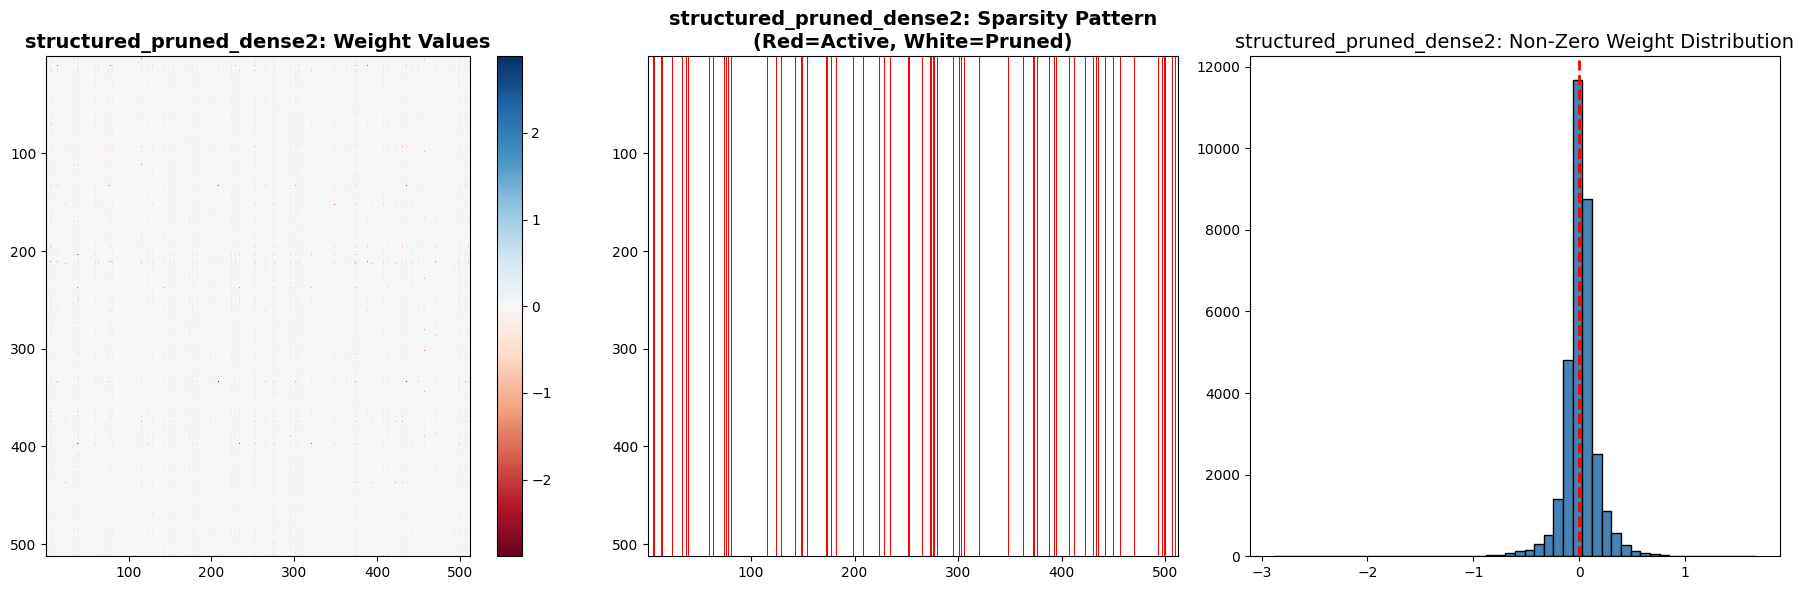

✓ Saved individual sparsity PNG: structured_sparsity_only_structured_pruned_dense2.png
✓ Saved individual sparsity PDF: structured_sparsity_only_structured_pruned_dense2.pdf
✓ Saved individual sparsity SVG: structured_sparsity_only_structured_pruned_dense2.svg
✓ Saved CSV: structured_sparsity_data_structured_pruned_dense2.csv
✓ Saved TikZ: structured_sparsity_pattern_structured_pruned_dense2.tex
✓ Saved TikZ histogram: structured_weight_histogram_structured_pruned_dense2.tex

Sample from weight matrix:
[[-0.          0.          0.          0.          0.         -0.2960569
   0.50874156 -0.        ]
 [-0.         -0.         -0.         -0.         -0.          0.08194876
  -0.00264948 -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.01551638
  -0.04465693 -0.        ]
 [ 0.         -0.          0.          0.         -0.          0.11683823
   0.27249062  0.        ]
 [-0.         -0.         -0.         -0.         -0.          0.16955385
  -0.00703047 -

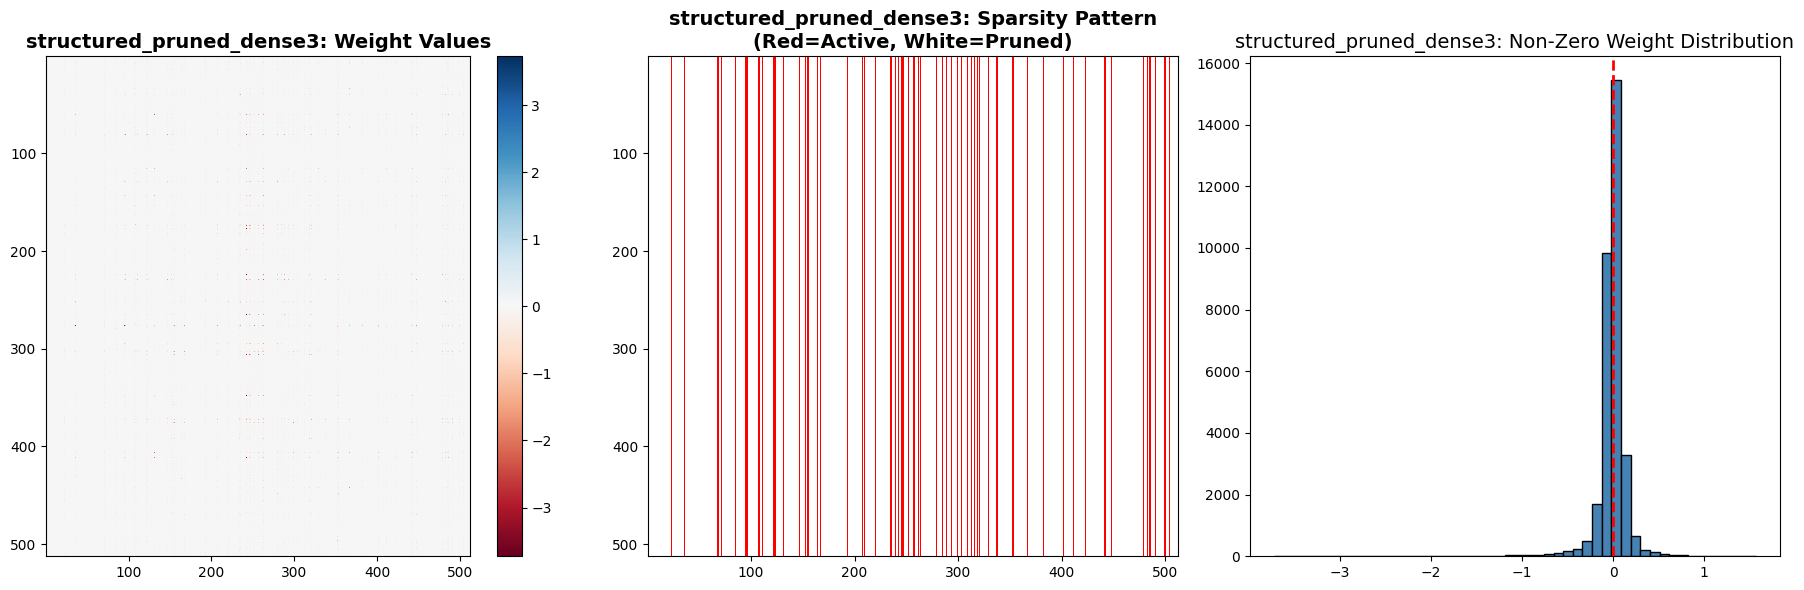

✓ Saved individual sparsity PNG: structured_sparsity_only_structured_pruned_dense3.png
✓ Saved individual sparsity PDF: structured_sparsity_only_structured_pruned_dense3.pdf
✓ Saved individual sparsity SVG: structured_sparsity_only_structured_pruned_dense3.svg
✓ Saved CSV: structured_sparsity_data_structured_pruned_dense3.csv
✓ Saved TikZ: structured_sparsity_pattern_structured_pruned_dense3.tex
✓ Saved TikZ histogram: structured_weight_histogram_structured_pruned_dense3.tex

Sample from weight matrix:
[[-0. -0.  0. -0. -0. -0.  0. -0.]
 [-0. -0. -0. -0. -0. -0.  0. -0.]
 [-0. -0. -0.  0.  0. -0.  0. -0.]
 [-0. -0. -0.  0. -0. -0.  0. -0.]
 [-0. -0.  0. -0. -0. -0.  0. -0.]
 [-0. -0. -0. -0. -0. -0.  0. -0.]
 [-0. -0.  0. -0. -0. -0.  0. -0.]
 [-0. -0.  0. -0. -0. -0. -0. -0.]]

Layer: structured_pruned_dense_out
Weight matrix shape: (512, 8)
Total weights: 4,096
Zero weights: 0
Non-zero weights: 4,096
Sparsity: 0.00%
Zero rows: 0/512
Zero cols: 0/8
→ UNSTRUCTURED PRUNING detected
✓ Sa

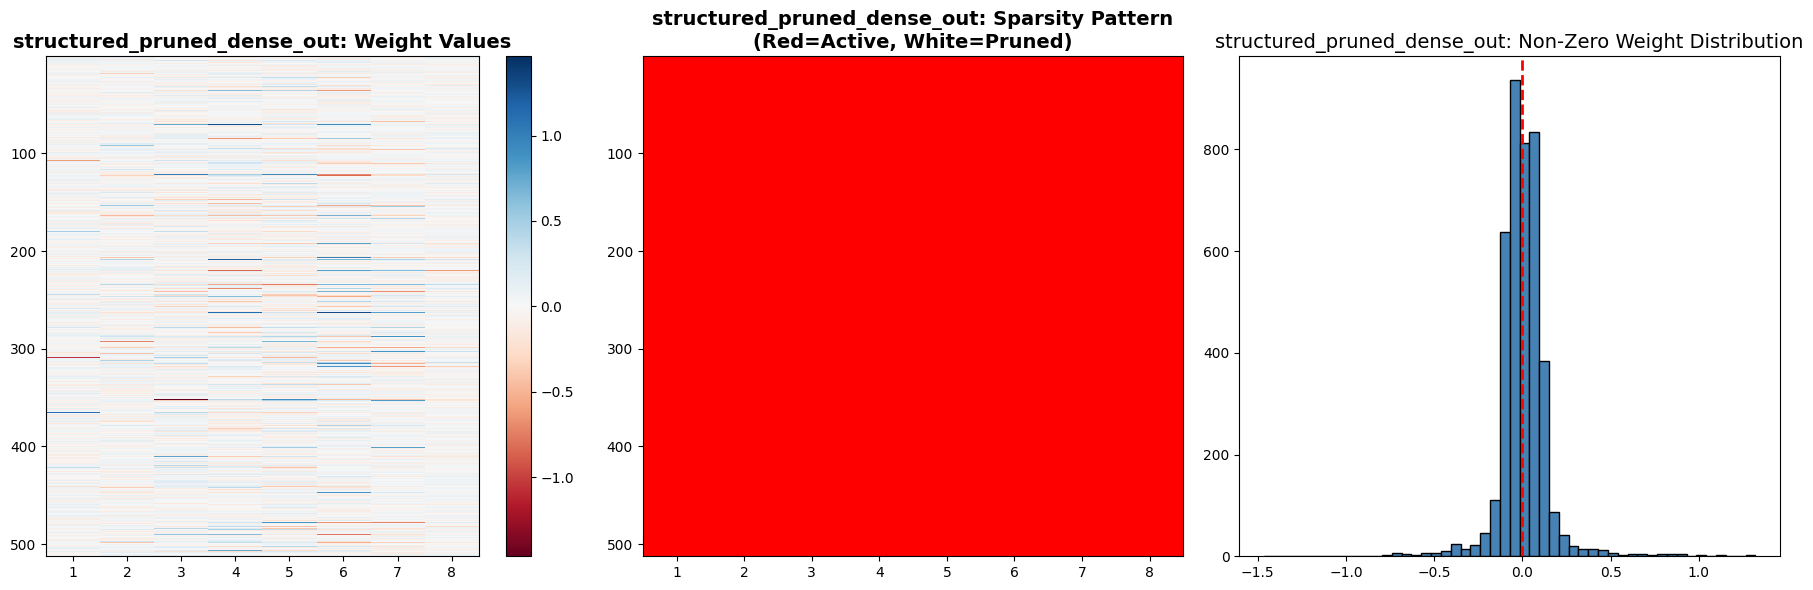

✓ Saved individual sparsity PNG: structured_sparsity_only_structured_pruned_dense_out.png
✓ Saved individual sparsity PDF: structured_sparsity_only_structured_pruned_dense_out.pdf
✓ Saved individual sparsity SVG: structured_sparsity_only_structured_pruned_dense_out.svg
✓ Saved CSV: structured_sparsity_data_structured_pruned_dense_out.csv
✓ Saved TikZ: structured_sparsity_pattern_structured_pruned_dense_out.tex
✓ Saved TikZ histogram: structured_weight_histogram_structured_pruned_dense_out.tex

Sample from weight matrix:
[[ 0.0347321   0.07059437  0.17690402  0.07492096 -0.13779224  0.04552348
   0.0508187  -0.07531743]
 [-0.06355619  0.09658475  0.02579327 -0.07642013  0.01140627 -0.06925029
  -0.06281228  0.08042257]
 [ 0.07536644  0.09403554 -0.03403499  0.02650785 -0.08691488  0.09703729
  -0.0129864   0.0658266 ]
 [ 0.12617117 -0.14119034 -0.0234732   0.06873831  0.02480515 -0.14459874
   0.01048834  0.06504758]
 [ 0.12069148  0.0570115   0.2649032  -0.16905366  0.23353939  0.08377

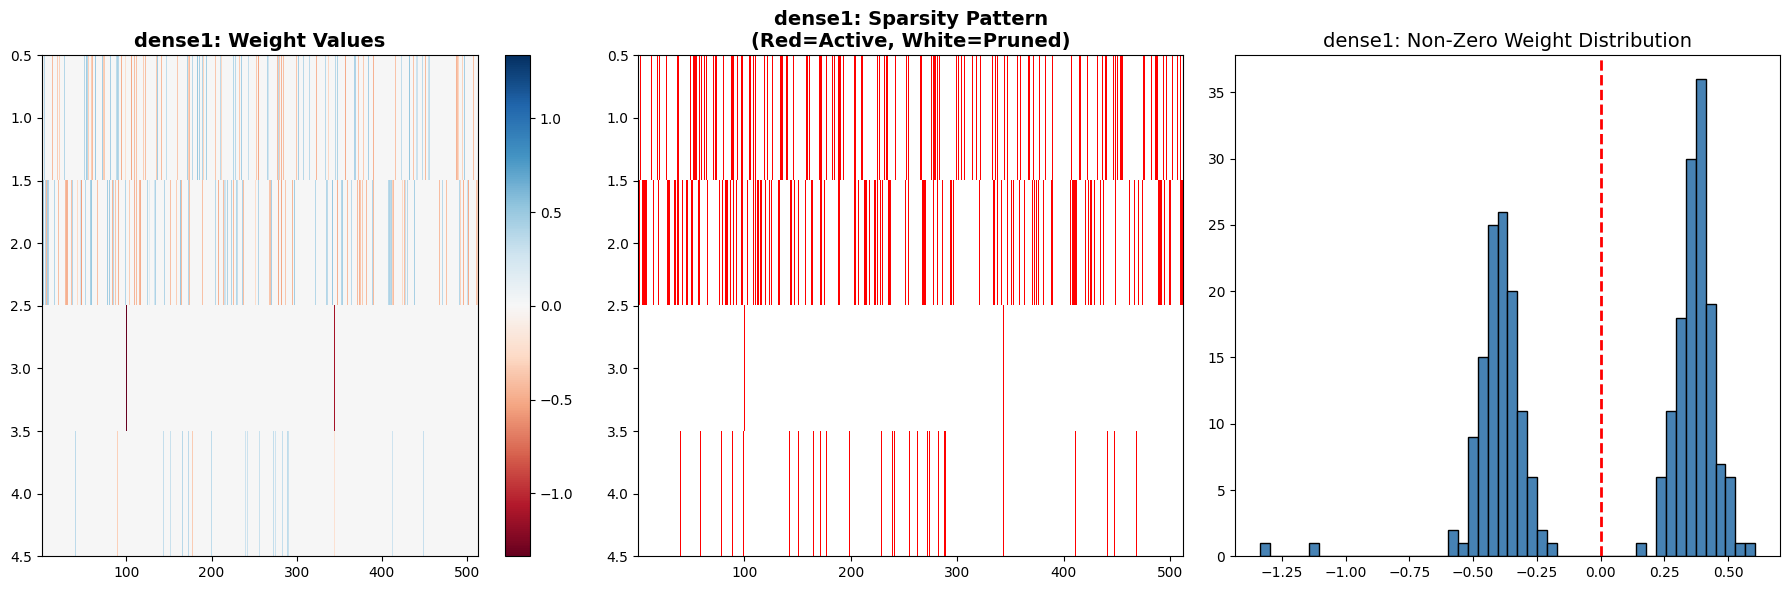

✓ Saved individual sparsity PNG: unstructured_sparsity_only_dense1.png
✓ Saved individual sparsity PDF: unstructured_sparsity_only_dense1.pdf
✓ Saved individual sparsity SVG: unstructured_sparsity_only_dense1.svg
✓ Saved CSV: unstructured_sparsity_data_dense1.csv
✓ Saved TikZ: unstructured_sparsity_pattern_dense1.tex
✓ Saved TikZ histogram: unstructured_weight_histogram_dense1.tex

Sample from weight matrix:
[[-0.48870027  0.          0.364208   -0.          0.         -0.
  -0.         -0.        ]
 [ 0.27807578  0.48989758  0.         -0.          0.3812308  -0.42526957
   0.42990923  0.39262104]
 [-0.         -0.          0.          0.          0.         -0.
  -0.          0.        ]
 [ 0.          0.         -0.          0.          0.          0.
  -0.         -0.        ]]

Layer: dense2
Weight matrix shape: (512, 512)
Total weights: 262,144
Zero weights: 229,376
Non-zero weights: 32,768
Sparsity: 87.50%
Zero rows: 46/512
Zero cols: 92/512
→ STRUCTURED PRUNING detected
✓ Saved

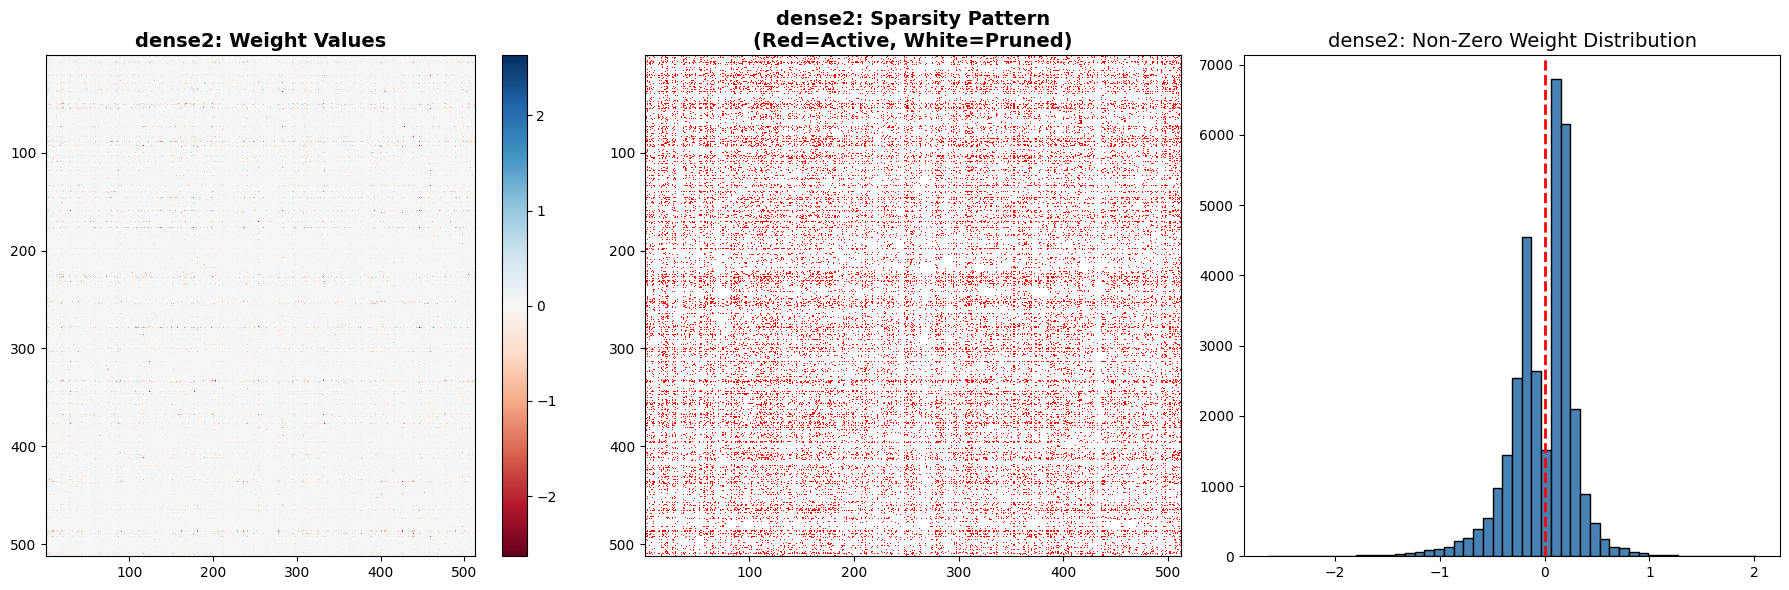

✓ Saved individual sparsity PNG: unstructured_sparsity_only_dense2.png
✓ Saved individual sparsity PDF: unstructured_sparsity_only_dense2.pdf
✓ Saved individual sparsity SVG: unstructured_sparsity_only_dense2.svg
✓ Saved CSV: unstructured_sparsity_data_dense2.csv
✓ Saved TikZ: unstructured_sparsity_pattern_dense2.tex
✓ Saved TikZ histogram: unstructured_weight_histogram_dense2.tex

Sample from weight matrix:
[[ 0.         -0.         -0.         -0.         -0.          0.
   0.          0.        ]
 [ 0.         -0.          0.12503754  0.         -0.         -0.
  -0.         -0.        ]
 [ 0.11794218 -0.         -0.         -0.          0.15670638 -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.          0.15019621  0.
  -0.         -0.        ]
 [ 0.         -0.         -0.          0.         -0.         -0.
  -0.         -0.        ]
 [-0.          0.          0.11541487 -0.         -0.          0.
   0.21288997  0.        ]
 [ 0.         -0.          0.4

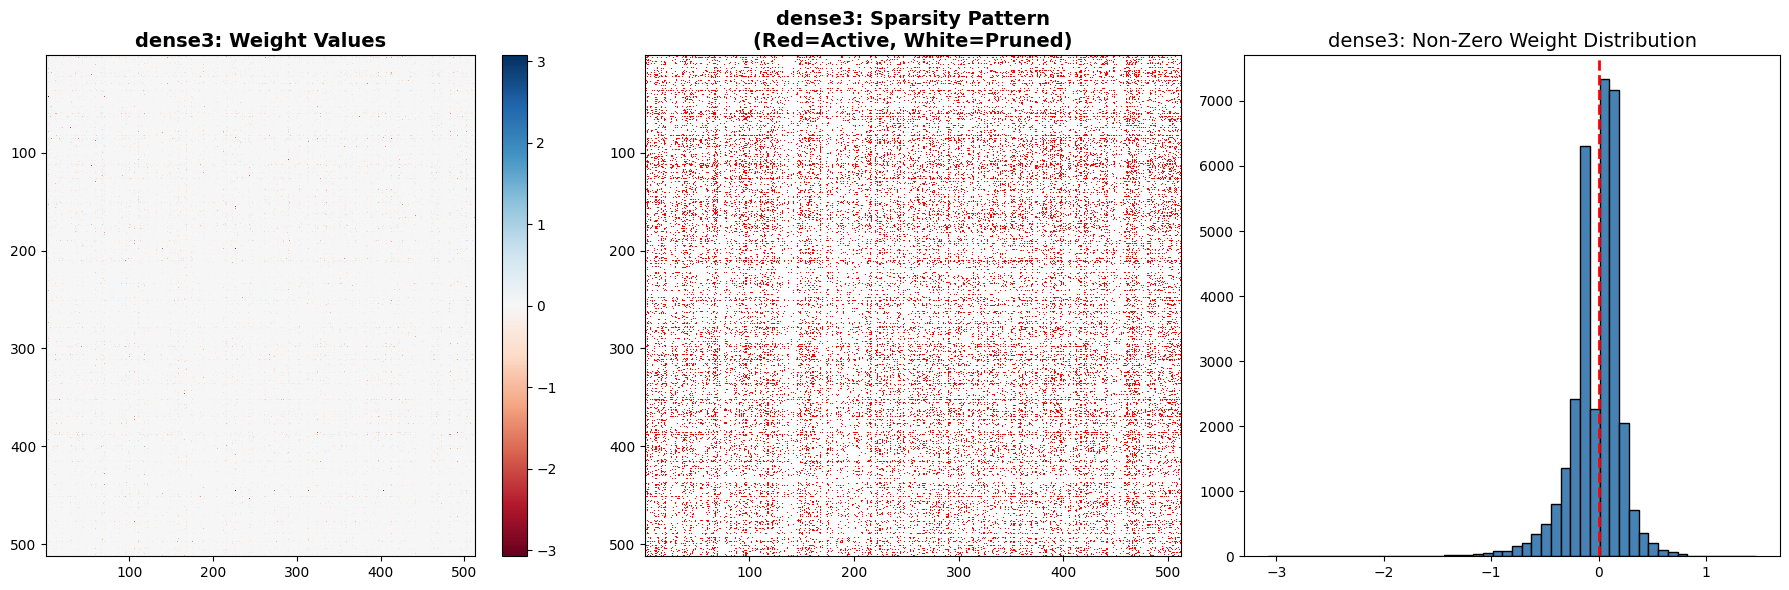

✓ Saved individual sparsity PNG: unstructured_sparsity_only_dense3.png
✓ Saved individual sparsity PDF: unstructured_sparsity_only_dense3.pdf
✓ Saved individual sparsity SVG: unstructured_sparsity_only_dense3.svg
✓ Saved CSV: unstructured_sparsity_data_dense3.csv
✓ Saved TikZ: unstructured_sparsity_pattern_dense3.tex
✓ Saved TikZ histogram: unstructured_weight_histogram_dense3.tex

Sample from weight matrix:
[[-0.          0.         -0.38983876 -0.         -0.          0.
  -0.         -0.        ]
 [-0.          0.          0.54268104  0.18430309 -0.         -0.
  -0.          0.        ]
 [-0.         -0.0859646   0.41733232  0.         -0.          0.
  -0.          0.18049769]
 [ 0.         -0.         -0.          0.          0.          0.
  -0.          0.        ]
 [-0.          0.09561976  0.         -0.14420414 -0.          0.
  -0.         -0.        ]
 [-0.01310605  0.         -0.3783291  -0.13343793 -0.          0.12202814
  -0.         -0.        ]
 [ 0.         -0.     

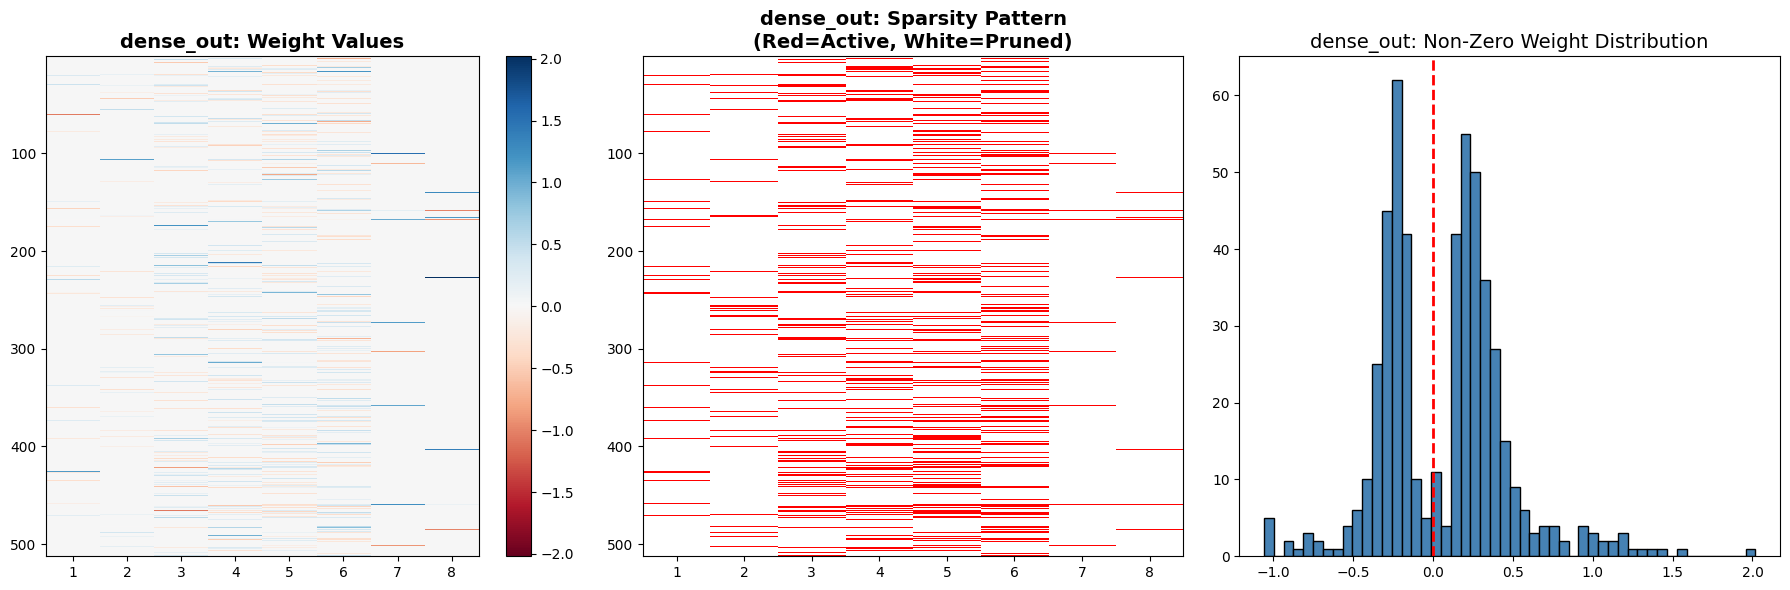

✓ Saved individual sparsity PNG: unstructured_sparsity_only_dense_out.png
✓ Saved individual sparsity PDF: unstructured_sparsity_only_dense_out.pdf
✓ Saved individual sparsity SVG: unstructured_sparsity_only_dense_out.svg
✓ Saved CSV: unstructured_sparsity_data_dense_out.csv
✓ Saved TikZ: unstructured_sparsity_pattern_dense_out.tex
✓ Saved TikZ histogram: unstructured_weight_histogram_dense_out.tex

Sample from weight matrix:
[[ 0.          0.15743266  0.         -0.         -0.         -0.
   0.          0.        ]
 [ 0.         -0.          0.         -0.         -0.         -0.
  -0.         -0.        ]
 [ 0.         -0.         -0.          0.30751762 -0.         -0.70145446
   0.         -0.        ]
 [ 0.         -0.          0.46536848 -0.         -0.          0.
  -0.         -0.        ]
 [ 0.         -0.         -0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.          0.          0.         -0.         -0.21829075
   0.          0.      

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf

# ========================================================================
# Utility Functions for Sparsity and Weight Visualization
# ========================================================================

def save_sparsity_as_csv(filename, weights, layer_name, zero_threshold=1e-9):
    """
    Save sparsity pattern as CSV file for TikZ generation.
    Format: row, column, value (0=pruned/zero, 1=active/non-zero)
    """
    zero_mask = np.abs(weights) < zero_threshold
    rows, cols = weights.shape

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['row', 'column', 'value', 'weight_magnitude'])
        for i in range(rows):
            for j in range(cols):
                value = 0 if zero_mask[i, j] else 1
                magnitude = abs(weights[i, j])
                writer.writerow([i+1, j+1, value, f'{magnitude:.10f}'])

    print(f"✓ Saved CSV: {filename}")


def save_sparsity_pattern_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
    """
    Save sparsity pattern as TikZ code for LaTeX.
    For large matrices, a simplified representation is used.
    """
    zero_mask = np.abs(weights) < zero_threshold
    rows, cols = weights.shape

    with open(filename, 'w') as f:
        f.write("% Sparsity pattern for " + layer_name + "\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{axis}[\n")
        f.write("    xlabel={Output Neurons (Columns)},\n")
        f.write("    ylabel={Input Neurons (Rows)},\n")
        f.write(f"    title={{{layer_name}: Sparsity Pattern}},\n")
        f.write("    colormap={redwhite}{color=(white) color=(red)},\n")
        f.write("    colorbar,\n")
        f.write("    colorbar style={ylabel={Active}},\n")
        f.write(f"    xmin=0.5, xmax={cols+0.5},\n")
        f.write(f"    ymin=0.5, ymax={rows+0.5},\n")
        f.write("    width=0.8\\textwidth,\n")
        f.write("    height=0.6\\textwidth,\n")
        f.write("    y dir=reverse,\n")
        f.write("]\n\n")

        max_points = 10000
        if rows * cols > max_points:
            step_r = max(1, rows // 100)
            step_c = max(1, cols // 100)
            f.write(f"% Matrix downsampled for visualization (step: {step_r}x{step_c})\n")
        else:
            step_r, step_c = 1, 1

        f.write("\\addplot[matrix plot*, mesh/cols=" + str(cols // step_c) + "] coordinates {\n")
        for i in range(0, rows, step_r):
            for j in range(0, cols, step_c):
                value = 0 if zero_mask[i, j] else 1
                f.write(f"    ({j+1}, {i+1}, {value})\n")
        f.write("};\n")
        f.write("\\end{axis}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"✓ Saved TikZ: {filename}")


def save_individual_sparsity_png(filename, weights, layer_name, zero_threshold=1e-9):
    """
    Save INDIVIDUAL sparsity pattern as PNG, PDF, and SVG.
    Red = Active/Non-zero, White = Pruned/Zero
    """
    zero_mask = np.abs(weights) < zero_threshold
    rows, cols = weights.shape
    colors = ['white', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('white_red', colors, N=n_bins)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sparsity_display = (~zero_mask).astype(float)
    im = ax.imshow(sparsity_display, cmap=cmap, aspect='auto',
                   interpolation='nearest',
                   extent=[0.5, cols+0.5, rows+0.5, 0.5],
                   vmin=0, vmax=1)

    ax.set_title(f'{layer_name}: Sparsity Pattern\n(Red=Active/Non-zero, White=Pruned/Zero)',
                 fontsize=16, fontweight='bold')
    ax.set_xlabel(f'Output Neurons (Columns 1-{cols})', fontsize=14)
    ax.set_ylabel(f'Input Neurons (Rows 1-{rows})', fontsize=14)

    # Tick handling
    if cols <= 64:
        tick_positions = range(1, cols+1, max(1, cols//8))
    else:
        tick_positions = range(1, cols+1, max(1, cols//10))
    ax.set_xticks(tick_positions)
    ax.tick_params(axis='x', labelsize=12)

    if rows <= 64:
        tick_positions_y = range(1, rows+1, max(1, rows//8))
    else:
        tick_positions_y = range(1, rows+1, max(1, rows//10))
    ax.set_yticks(tick_positions_y)
    ax.tick_params(axis='y', labelsize=12)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Active Neurons', rotation=270, labelpad=20, fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    plt.tight_layout()

    # Save PNG, PDF, and SVG
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved individual sparsity PNG: {filename}")

    pdf_filename = filename.replace('.png', '.pdf')
    plt.savefig(pdf_filename, bbox_inches='tight', format='pdf')
    print(f"✓ Saved individual sparsity PDF: {pdf_filename}")

    svg_filename = filename.replace('.png', '.svg')
    plt.savefig(svg_filename, bbox_inches='tight', format='svg')
    print(f"✓ Saved individual sparsity SVG: {svg_filename}")

    plt.close(fig)


def save_weight_histogram_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
    """Save weight distribution histogram as TikZ code"""
    zero_mask = np.abs(weights) < zero_threshold
    non_zero_weights = weights[~zero_mask]

    if len(non_zero_weights) == 0:
        print(f"Skipping histogram for {layer_name} (all weights are zero)")
        return

    counts, bin_edges = np.histogram(non_zero_weights, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    with open(filename, 'w') as f:
        f.write("% Weight distribution for " + layer_name + "\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{axis}[\n")
        f.write("    xlabel={Weight Value},\n")
        f.write("    ylabel={Count},\n")
        f.write(f"    title={{{layer_name}: Non-Zero Weight Distribution}},\n")
        f.write("    ybar,\n")
        f.write("    bar width=0.8,\n")
        f.write("    width=0.8\\textwidth,\n")
        f.write("    height=0.5\\textwidth,\n")
        f.write("    grid=both,\n")
        f.write("]\n\n")

        f.write("\\addplot[fill=blue!50, draw=black] coordinates {\n")
        for x, y in zip(bin_centers, counts):
            f.write(f"    ({x:.4f}, {y})\n")
        f.write("};\n")
        f.write("\\addplot[red, dashed, thick, forget plot] coordinates {(0, 0) (0, " +
                str(max(counts)) + ")};\n")
        f.write("\\end{axis}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"✓ Saved TikZ histogram: {filename}")


# ========================================================================
# Main Visualization Function
# ========================================================================

def visualize_weight_matrices(dense_demapper, sparse_demapper=None,
                              save_tikz=True, output_prefix=""):
    """
    Visualize weight matrices and export to TikZ, CSV, PNG, PDF, and SVG.
    """
    print("="*80)
    print("WEIGHT MATRIX STRUCTURE ANALYSIS")
    print("="*80)

    colors = ['white', 'red']
    n_bins = 100
    custom_cmap = LinearSegmentedColormap.from_list('white_red', colors, N=n_bins)

    for i, layer in enumerate(dense_demapper.layers):
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()

            print(f"\n{'='*80}")
            print(f"Layer: {layer.name}")
            print(f"{'='*80}")
            print(f"Weight matrix shape: {weights.shape}")
            print(f"Total weights: {weights.size:,}")

            zero_mask = np.abs(weights) < 1e-9
            num_zeros = np.sum(zero_mask)
            sparsity = (num_zeros / weights.size) * 100

            print(f"Zero weights: {num_zeros:,}")
            print(f"Non-zero weights: {weights.size - num_zeros:,}")
            print(f"Sparsity: {sparsity:.2f}%")

            zero_rows = np.sum(np.all(zero_mask, axis=1))
            zero_cols = np.sum(np.all(zero_mask, axis=0))
            print(f"Zero rows: {zero_rows}/{weights.shape[0]}")
            print(f"Zero cols: {zero_cols}/{weights.shape[1]}")

            if zero_cols > 0:
                print(f"→ STRUCTURED PRUNING detected")
            else:
                print(f"→ UNSTRUCTURED PRUNING detected")

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            rows, cols = weights.shape

            im1 = axes[0].imshow(weights, cmap='RdBu', aspect='auto',
                                interpolation='nearest',
                                vmin=-np.max(np.abs(weights)),
                                vmax=np.max(np.abs(weights)),
                                extent=[0.5, cols+0.5, rows+0.5, 0.5])
            axes[0].set_title(f'{layer.name}: Weight Values', fontsize=14, fontweight='bold')
            cbar1 = plt.colorbar(im1, ax=axes[0])

            sparsity_display = (~zero_mask).astype(float)
            im2 = axes[1].imshow(sparsity_display, cmap=custom_cmap, aspect='auto',
                                interpolation='nearest',
                                extent=[0.5, cols+0.5, rows+0.5, 0.5],
                                vmin=0, vmax=1)
            axes[1].set_title(f'{layer.name}: Sparsity Pattern\n(Red=Active, White=Pruned)',
                             fontsize=14, fontweight='bold')

            if not np.all(zero_mask):
                non_zero_weights = weights[~zero_mask]
                axes[2].hist(non_zero_weights, bins=50, edgecolor='black', color='steelblue')
                axes[2].set_title(f'{layer.name}: Non-Zero Weight Distribution', fontsize=14)
                axes[2].axvline(0, color='r', linestyle='--', linewidth=2)
            else:
                axes[2].text(0.5, 0.5, 'All weights are zero', ha='center', va='center')

            plt.tight_layout()
            png_filename = f'{output_prefix}weight_visualization_{layer.name}.png'
            plt.savefig(png_filename, dpi=150, bbox_inches='tight')
            print(f"✓ Saved combined PNG: {png_filename}")
            plt.show()

            individual_sparsity_png = f'{output_prefix}sparsity_only_{layer.name}.png'
            save_individual_sparsity_png(individual_sparsity_png, weights, layer.name)

            csv_filename = f'{output_prefix}sparsity_data_{layer.name}.csv'
            save_sparsity_as_csv(csv_filename, weights, layer.name)

            if save_tikz:
                tikz_sparsity = f'{output_prefix}sparsity_pattern_{layer.name}.tex'
                save_sparsity_pattern_as_tikz(tikz_sparsity, weights, layer.name)

                tikz_hist = f'{output_prefix}weight_histogram_{layer.name}.tex'
                save_weight_histogram_as_tikz(tikz_hist, weights, layer.name)

            print(f"\nSample from weight matrix:")
            print(weights[:min(8, rows), :min(8, cols)])


# ========================================================================
# Example Usage
# ========================================================================

print("\nVisualizing Structured Pruned Demapper...")
visualize_weight_matrices(
    dense_demapper=model_structured_pruned_eval._demapper,
    save_tikz=True,
    output_prefix="structured_"
)

print("\nVisualizing Unstructured Pruned Demapper...")
visualize_weight_matrices(
    dense_demapper=model_pruned_from_pretrained_eval._demapper,
    save_tikz=True,
    output_prefix="unstructured_"
)

print("\nVisualization complete! SVG, PNG, PDF, CSV, and TikZ files generated.")


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.ticker import MaxNLocator

# def save_sparsity_pattern_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
#     """
#     Save sparsity pattern as TikZ code for LaTeX.
#     For large matrices, we'll use a simplified representation.
#     """
#     zero_mask = np.abs(weights) < zero_threshold
#     rows, cols = weights.shape

#     with open(filename, 'w') as f:
#         f.write("% Sparsity pattern for " + layer_name + "\n")
#         f.write("\\begin{tikzpicture}\n")
#         f.write("\\begin{axis}[\n")
#         f.write("    xlabel={Output Neurons (Columns)},\n")
#         f.write("    ylabel={Input Neurons (Rows)},\n")
#         f.write(f"    title={{{layer_name}: Sparsity Pattern}},\n")
#         f.write("    colormap={bw}{color=(white) color=(black)},\n")
#         f.write("    colorbar,\n")
#         f.write("    colorbar style={ylabel={Non-zero}},\n")
#         f.write(f"    xmin=0.5, xmax={cols+0.5},\n")
#         f.write(f"    ymin=0.5, ymax={rows+0.5},\n")
#         f.write("    width=0.8\\textwidth,\n")
#         f.write("    height=0.6\\textwidth,\n")
#         f.write("    xlabel style={font=\\small},\n")
#         f.write("    ylabel style={font=\\small},\n")
#         f.write("    y dir=reverse,\n")
#         f.write("]\n\n")

#         # For visualization, we downsample large matrices
#         max_points = 10000
#         if rows * cols > max_points:
#             step_r = max(1, rows // 100)
#             step_c = max(1, cols // 100)
#             f.write(f"% Matrix downsampled for visualization (step: {step_r}x{step_c})\n")
#         else:
#             step_r, step_c = 1, 1

#         f.write("\\addplot[matrix plot*, mesh/cols=" + str(cols // step_c) + "] coordinates {\n")

#         # Write coordinates (1-indexed, zero = 0, non-zero = 1)
#         for i in range(0, rows, step_r):
#             for j in range(0, cols, step_c):
#                 value = 0 if zero_mask[i, j] else 1
#                 f.write(f"    ({j+1}, {i+1}, {value})\n")

#         f.write("};\n")
#         f.write("\\end{axis}\n")
#         f.write("\\end{tikzpicture}\n")

#     print(f"Saved TikZ sparsity pattern to: {filename}")


# def save_individual_sparsity_png(filename, weights, layer_name, zero_threshold=1e-9):
#     """
#     Save INDIVIDUAL sparsity pattern as standalone PNG for easy LaTeX inclusion.
#     """
#     zero_mask = np.abs(weights) < zero_threshold
#     rows, cols = weights.shape

#     # Create standalone figure for this sparsity pattern
#     fig, ax = plt.subplots(1, 1, figsize=(10, 6))

#     # Display sparsity: ~zero_mask inverted so black=active, white=pruned
#     sparsity_display = (~zero_mask).astype(float)
#     im = ax.imshow(sparsity_display, cmap='binary', aspect='auto',
#                    interpolation='nearest',
#                    extent=[0.5, cols+0.5, rows+0.5, 0.5])

#     ax.set_title(f'{layer_name}: Sparsity Pattern\n(Black=Active/Non-zero, White=Pruned/Zero)',
#                  fontsize=14, fontweight='bold')
#     ax.set_xlabel(f'Output Neurons (Columns 1-{cols})', fontsize=12)
#     ax.set_ylabel(f'Input Neurons (Rows 1-{rows})', fontsize=12)

#     # Set ticks
#     if cols <= 64:
#         tick_positions = range(1, cols+1, max(1, cols//8))
#     else:
#         tick_positions = range(1, cols+1, max(1, cols//10))
#     ax.set_xticks(tick_positions)

#     if rows <= 64:
#         tick_positions_y = range(1, rows+1, max(1, rows//8))
#     else:
#         tick_positions_y = range(1, rows+1, max(1, rows//10))
#     ax.set_yticks(tick_positions_y)

#     # Add colorbar
#     cbar = plt.colorbar(im, ax=ax)
#     cbar.set_label('Non-zero', rotation=270, labelpad=15)

#     # Add grid
#     ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

#     plt.tight_layout()
#     plt.savefig(filename, dpi=300, bbox_inches='tight')
#     print(f"✓ Saved individual sparsity PNG: {filename}")
#     plt.close(fig)


# def save_weight_histogram_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
#     """Save weight distribution histogram as TikZ code"""
#     zero_mask = np.abs(weights) < zero_threshold
#     non_zero_weights = weights[~zero_mask]

#     if len(non_zero_weights) == 0:
#         print(f"Skipping histogram for {layer_name} (all weights are zero)")
#         return

#     # Create histogram
#     counts, bin_edges = np.histogram(non_zero_weights, bins=50)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#     with open(filename, 'w') as f:
#         f.write("% Weight distribution for " + layer_name + "\n")
#         f.write("\\begin{tikzpicture}\n")
#         f.write("\\begin{axis}[\n")
#         f.write("    xlabel={Weight Value},\n")
#         f.write("    ylabel={Count},\n")
#         f.write(f"    title={{{layer_name}: Non-Zero Weight Distribution}},\n")
#         f.write("    ybar,\n")
#         f.write("    bar width=0.8,\n")
#         f.write("    width=0.8\\textwidth,\n")
#         f.write("    height=0.5\\textwidth,\n")
#         f.write("    grid=both,\n")
#         f.write("    xlabel style={font=\\small},\n")
#         f.write("    ylabel style={font=\\small},\n")
#         f.write("]\n\n")

#         f.write("\\addplot[fill=blue!50, draw=black] coordinates {\n")
#         for x, y in zip(bin_centers, counts):
#             f.write(f"    ({x:.4f}, {y})\n")
#         f.write("};\n")

#         # Add vertical line at zero
#         f.write("\\addplot[red, dashed, thick, forget plot] coordinates {(0, 0) (0, " +
#                 str(max(counts)) + ")};\n")

#         f.write("\\end{axis}\n")
#         f.write("\\end{tikzpicture}\n")

#     print(f"Saved TikZ histogram to: {filename}")


# def visualize_weight_matrices(dense_demapper, sparse_demapper=None,
#                               save_tikz=True, output_prefix=""):
#     """
#     Visualize weight matrices and optionally export to TikZ.
#     Uses 1-indexed labeling (neurons 1-N) for academic clarity.

#     Args:
#         dense_demapper: The demapper model to visualize
#         sparse_demapper: Optional sparse representation for comparison
#         save_tikz: If True, save plots as TikZ code
#         output_prefix: Prefix for output filenames (e.g., "structured_" or "unstructured_")
#     """
#     print("="*80)
#     print("WEIGHT MATRIX STRUCTURE ANALYSIS")
#     print("="*80)

#     for i, layer in enumerate(dense_demapper.layers):
#         if isinstance(layer, tf.keras.layers.Dense):
#             weights, biases = layer.get_weights()

#             print(f"\n{'='*80}")
#             print(f"Layer: {layer.name}")
#             print(f"{'='*80}")
#             print(f"Weight matrix shape: {weights.shape}")
#             print(f"Total weights: {weights.size:,}")

#             zero_mask = np.abs(weights) < 1e-9
#             num_zeros = np.sum(zero_mask)
#             sparsity = (num_zeros / weights.size) * 100

#             print(f"Zero weights: {num_zeros:,}")
#             print(f"Non-zero weights: {weights.size - num_zeros:,}")
#             print(f"Sparsity: {sparsity:.2f}%")

#             print(f"\nStructure Analysis:")
#             zero_rows = np.sum(np.all(zero_mask, axis=1))
#             print(f"  Completely zero input connections (rows): {zero_rows}/{weights.shape[0]}")

#             zero_cols = np.sum(np.all(zero_mask, axis=0))
#             print(f"  Completely zero output neurons (columns): {zero_cols}/{weights.shape[1]}")

#             if zero_cols > 0:
#                 print(f"  → STRUCTURED PRUNING detected: {zero_cols} entire neurons removed!")
#             else:
#                 print(f"  → UNSTRUCTURED PRUNING: Weights scattered throughout matrix")

#             # Create matplotlib plots
#             fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#             rows, cols = weights.shape

#             # Plot 1: Full weight matrix (1-indexed)
#             im1 = axes[0].imshow(weights, cmap='RdBu', aspect='auto',
#                                 interpolation='nearest',
#                                 vmin=-np.max(np.abs(weights)),
#                                 vmax=np.max(np.abs(weights)),
#                                 extent=[0.5, cols+0.5, rows+0.5, 0.5])
#             axes[0].set_title(f'{layer.name}: Weight Values')
#             axes[0].set_xlabel(f'Output Neurons (Columns 1-{cols})')
#             axes[0].set_ylabel(f'Input Neurons (Rows 1-{rows})')

#             # Set ticks
#             if cols <= 64:
#                 tick_positions = range(1, cols+1, max(1, cols//8))
#             else:
#                 tick_positions = range(1, cols+1, max(1, cols//10))
#             axes[0].set_xticks(tick_positions)

#             if rows <= 64:
#                 tick_positions_y = range(1, rows+1, max(1, rows//8))
#             else:
#                 tick_positions_y = range(1, rows+1, max(1, rows//10))
#             axes[0].set_yticks(tick_positions_y)

#             plt.colorbar(im1, ax=axes[0])

#             # Plot 2: Sparsity pattern (1-indexed)
#             # Invert zero_mask so black=active, white=pruned
#             sparsity_display = (~zero_mask).astype(float)
#             im2 = axes[1].imshow(sparsity_display, cmap='binary', aspect='auto',
#                                 interpolation='nearest',
#                                 extent=[0.5, cols+0.5, rows+0.5, 0.5])
#             axes[1].set_title(f'{layer.name}: Sparsity Pattern\n(Black=Active/Non-zero, White=Pruned/Zero)')
#             axes[1].set_xlabel(f'Output Neurons (Columns 1-{cols})')
#             axes[1].set_ylabel(f'Input Neurons (Rows 1-{rows})')

#             # Set ticks
#             if cols <= 64:
#                 tick_positions = range(1, cols+1, max(1, cols//8))
#             else:
#                 tick_positions = range(1, cols+1, max(1, cols//10))
#             axes[1].set_xticks(tick_positions)

#             if rows <= 64:
#                 tick_positions_y = range(1, rows+1, max(1, rows//8))
#             else:
#                 tick_positions_y = range(1, rows+1, max(1, rows//10))
#             axes[1].set_yticks(tick_positions_y)

#             axes[1].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

#             # Plot 3: Weight distribution
#             if not np.all(zero_mask):
#                 non_zero_weights = weights[~zero_mask]
#                 axes[2].hist(non_zero_weights, bins=50, edgecolor='black', color='steelblue')
#                 axes[2].set_title(f'{layer.name}: Non-Zero Weight Distribution')
#                 axes[2].set_xlabel('Weight Value')
#                 axes[2].set_ylabel('Count')
#                 axes[2].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero')
#                 axes[2].legend()
#                 axes[2].grid(True, alpha=0.3)
#             else:
#                 axes[2].text(0.5, 0.5, 'All weights are zero',
#                            ha='center', va='center', transform=axes[2].transAxes,
#                            fontsize=14)
#                 axes[2].set_title(f'{layer.name}: Weight Distribution')

#             plt.tight_layout()

#             # Save combined PNG
#             png_filename = f'{output_prefix}weight_visualization_{layer.name}.png'
#             plt.savefig(png_filename, dpi=150, bbox_inches='tight')
#             print(f"Saved PNG: {png_filename}")
#             plt.show()

#             # ⭐⭐⭐ Save INDIVIDUAL sparsity pattern PNG ⭐⭐⭐
#             individual_sparsity_png = f'{output_prefix}sparsity_only_{layer.name}.png'
#             save_individual_sparsity_png(individual_sparsity_png, weights, layer.name)

#             # Save TikZ versions
#             if save_tikz:
#                 tikz_sparsity = f'{output_prefix}sparsity_pattern_{layer.name}.tex'
#                 save_sparsity_pattern_as_tikz(tikz_sparsity, weights, layer.name)

#                 tikz_hist = f'{output_prefix}weight_histogram_{layer.name}.tex'
#                 save_weight_histogram_as_tikz(tikz_hist, weights, layer.name)

#             # Print sample
#             print(f"\nSample from weight matrix (top-left corner):")
#             print(f"Showing neurons 1-{min(8, rows)} (rows) × 1-{min(8, cols)} (columns)")
#             sample_rows = min(8, weights.shape[0])
#             sample_cols = min(8, weights.shape[1])
#             print(weights[:sample_rows, :sample_cols])


# # ============================================================================
# # USAGE EXAMPLES
# # ============================================================================

# # For structured pruning visualization
# print("\nVisualizing Structured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_structured_pruned_eval._demapper,
#     save_tikz=True,
#     output_prefix="structured_"
# )

# # For unstructured pruning visualization
# print("\nVisualizing Unstructured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_pruned_from_pretrained_eval._demapper,
#     save_tikz=True,
#     output_prefix="unstructured_"
# )

# print("\n" + "="*80)
# print("Visualization complete!")
# print("\nGenerated files:")
# print("  Combined visualizations:")
# print("    - structured_weight_visualization_*.png")
# print("    - unstructured_weight_visualization_*.png")
# print("\n  Individual sparsity patterns (for LaTeX):")
# print("    - structured_sparsity_only_dense1.png")
# print("    - structured_sparsity_only_dense2.png")
# print("    - structured_sparsity_only_dense3.png")
# print("    - unstructured_sparsity_only_dense1.png")
# print("    - unstructured_sparsity_only_dense2.png")
# print("    - unstructured_sparsity_only_dense3.png")
# print("\n  TikZ files:")
# print("    - structured_sparsity_pattern_*.tex")
# print("    - unstructured_sparsity_pattern_*.tex")
# print("\nNote: All neuron indices use 1-based indexing (1 to N)")
# print("="*80)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.ticker import MaxNLocator

# def save_sparsity_pattern_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
#     """
#     Save sparsity pattern as TikZ code for LaTeX.
#     For large matrices, we'll use a simplified representation.
#     """
#     zero_mask = np.abs(weights) < zero_threshold
#     rows, cols = weights.shape

#     with open(filename, 'w') as f:
#         f.write("% Sparsity pattern for " + layer_name + "\n")
#         f.write("\\begin{tikzpicture}\n")
#         f.write("\\begin{axis}[\n")
#         f.write("    xlabel={Output Neurons (Columns)},\n")
#         f.write("    ylabel={Input Neurons (Rows)},\n")
#         f.write(f"    title={{{layer_name}: Sparsity Pattern}},\n")
#         f.write("    colormap={bw}{color=(white) color=(black)},\n")
#         f.write("    colorbar,\n")
#         f.write("    colorbar style={ylabel={Non-zero}},\n")
#         f.write(f"    xmin=0.5, xmax={cols+0.5},\n")
#         f.write(f"    ymin=0.5, ymax={rows+0.5},\n")
#         f.write("    width=0.8\\textwidth,\n")
#         f.write("    height=0.6\\textwidth,\n")
#         f.write("    xlabel style={font=\\small},\n")
#         f.write("    ylabel style={font=\\small},\n")
#         f.write("    y dir=reverse,\n")
#         f.write("]\n\n")

#         # For visualization, we downsample large matrices
#         max_points = 10000
#         if rows * cols > max_points:
#             step_r = max(1, rows // 100)
#             step_c = max(1, cols // 100)
#             f.write(f"% Matrix downsampled for visualization (step: {step_r}x{step_c})\n")
#         else:
#             step_r, step_c = 1, 1

#         f.write("\\addplot[matrix plot*, mesh/cols=" + str(cols // step_c) + "] coordinates {\n")

#         # Write coordinates (1-indexed, zero = 0, non-zero = 1)
#         for i in range(0, rows, step_r):
#             for j in range(0, cols, step_c):
#                 value = 0 if zero_mask[i, j] else 1
#                 f.write(f"    ({j+1}, {i+1}, {value})\n")

#         f.write("};\n")
#         f.write("\\end{axis}\n")
#         f.write("\\end{tikzpicture}\n")

#     print(f"Saved TikZ sparsity pattern to: {filename}")


# def save_weight_histogram_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
#     """Save weight distribution histogram as TikZ code"""
#     zero_mask = np.abs(weights) < zero_threshold
#     non_zero_weights = weights[~zero_mask]

#     if len(non_zero_weights) == 0:
#         print(f"Skipping histogram for {layer_name} (all weights are zero)")
#         return

#     # Create histogram
#     counts, bin_edges = np.histogram(non_zero_weights, bins=50)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#     with open(filename, 'w') as f:
#         f.write("% Weight distribution for " + layer_name + "\n")
#         f.write("\\begin{tikzpicture}\n")
#         f.write("\\begin{axis}[\n")
#         f.write("    xlabel={Weight Value},\n")
#         f.write("    ylabel={Count},\n")
#         f.write(f"    title={{{layer_name}: Non-Zero Weight Distribution}},\n")
#         f.write("    ybar,\n")
#         f.write("    bar width=0.8,\n")
#         f.write("    width=0.8\\textwidth,\n")
#         f.write("    height=0.5\\textwidth,\n")
#         f.write("    grid=both,\n")
#         f.write("    xlabel style={font=\\small},\n")
#         f.write("    ylabel style={font=\\small},\n")
#         f.write("]\n\n")

#         f.write("\\addplot[fill=blue!50, draw=black] coordinates {\n")
#         for x, y in zip(bin_centers, counts):
#             f.write(f"    ({x:.4f}, {y})\n")
#         f.write("};\n")

#         # Add vertical line at zero
#         f.write("\\addplot[red, dashed, thick, forget plot] coordinates {(0, 0) (0, " +
#                 str(max(counts)) + ")};\n")

#         f.write("\\end{axis}\n")
#         f.write("\\end{tikzpicture}\n")

#     print(f"Saved TikZ histogram to: {filename}")

# def visualize_weight_matrices(dense_demapper, sparse_demapper=None,
#                               save_tikz=True, output_prefix=""):
#     """
#     Visualize weight matrices and optionally export to TikZ.
#     """
#     print("="*80)
#     print("WEIGHT MATRIX STRUCTURE ANALYSIS")
#     print("="*80)

#     for i, layer in enumerate(dense_demapper.layers):
#         if isinstance(layer, tf.keras.layers.Dense):
#             weights, biases = layer.get_weights()

#             print(f"\n{'='*80}")
#             print(f"Layer: {layer.name}")
#             print(f"{'='*80}")
#             print(f"Weight matrix shape: {weights.shape}")
#             print(f"Total weights: {weights.size:,}")

#             zero_mask = np.abs(weights) < 1e-9
#             num_zeros = np.sum(zero_mask)
#             sparsity = (num_zeros / weights.size) * 100

#             print(f"Zero weights: {num_zeros:,}")
#             print(f"Non-zero weights: {weights.size - num_zeros:,}")
#             print(f"Sparsity: {sparsity:.2f}%")

#             print(f"\nStructure Analysis:")
#             zero_rows = np.sum(np.all(zero_mask, axis=1))
#             print(f"  Completely zero input connections (rows): {zero_rows}/{weights.shape[0]}")

#             zero_cols = np.sum(np.all(zero_mask, axis=0))
#             print(f"  Completely zero output neurons (columns): {zero_cols}/{weights.shape[1]}")

#             if zero_cols > 0:
#                 print(f"  → STRUCTURED PRUNING detected: {zero_cols} entire neurons removed!")
#             else:
#                 print(f"  → UNSTRUCTURED PRUNING: Weights scattered throughout matrix")

#             # ⭐⭐⭐ ADD DEBUGGING CODE HERE ⭐⭐⭐
#             print(f"\n🔍 DEBUGGING SPARSITY DISPLAY:")
#             print(f"  zero_mask shape: {zero_mask.shape}")
#             print(f"  zero_mask dtype: {zero_mask.dtype}")
#             print(f"  True values in zero_mask: {np.sum(zero_mask)}")
#             print(f"  False values in zero_mask: {np.sum(~zero_mask)}")
#             print(f"  Zero columns: {np.sum(np.all(zero_mask, axis=0))}")
#             print(f"  Expected: 448 zero columns for structured pruning")

#             # Check actual weight values
#             print(f"\n  Checking actual weights:")
#             print(f"  Weights < 1e-9: {np.sum(np.abs(weights) < 1e-9)}")
#             print(f"  Weights == 0: {np.sum(weights == 0)}")
#             print(f"  Min abs weight: {np.min(np.abs(weights))}")
#             print(f"  Max abs weight: {np.max(np.abs(weights))}")

#             # Sample column 64 (should be zero in structured pruning)
#             rows, cols = weights.shape
#             if cols > 64:
#                 col_64_weights = weights[:, 64]
#                 print(f"\n  Column 64 (should be all zero):")
#                 print(f"    Max abs value: {np.max(np.abs(col_64_weights))}")
#                 print(f"    All zero?: {np.all(np.abs(col_64_weights) < 1e-9)}")
#             # ⭐⭐⭐ END DEBUGGING CODE ⭐⭐⭐

#             # Create matplotlib plots
#             fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#             # ... rest of the plotting code continues as before ...

#             rows, cols = weights.shape

#             # Plot 1: Full weight matrix (1-indexed)
#             im1 = axes[0].imshow(weights, cmap='RdBu', aspect='auto',
#                                 interpolation='nearest',
#                                 vmin=-np.max(np.abs(weights)),
#                                 vmax=np.max(np.abs(weights)),
#                                 extent=[0.5, cols+0.5, rows+0.5, 0.5])  # 1-indexed extent
#             axes[0].set_title(f'{layer.name}: Weight Values')
#             axes[0].set_xlabel(f'Output Neurons (Columns 1-{cols})')
#             axes[0].set_ylabel(f'Input Neurons (Rows 1-{rows})')

#             # Set ticks to show actual neuron indices (1-indexed)
#             if cols <= 64:
#                 tick_positions = range(1, cols+1, max(1, cols//8))
#             else:
#                 tick_positions = range(1, cols+1, max(1, cols//10))
#             axes[0].set_xticks(tick_positions)

#             if rows <= 64:
#                 tick_positions_y = range(1, rows+1, max(1, rows//8))
#             else:
#                 tick_positions_y = range(1, rows+1, max(1, rows//10))
#             axes[0].set_yticks(tick_positions_y)

#             plt.colorbar(im1, ax=axes[0])

#             # Plot 2: Sparsity pattern (1-indexed)
#             # Use zero_mask directly: True (1) = zero/pruned, False (0) = non-zero/active
#             # With 'binary' colormap: 0=black, 1=white
#             # Result: White=pruned, Black=active ✓
#             # sparsity_display = zero_mask.astype(float)
#             sparsity_display = (~zero_mask).astype(float)
#             im2 = axes[1].imshow(sparsity_display, cmap='binary', aspect='auto',
#                                 interpolation='nearest',
#                                 extent=[0.5, cols+0.5, rows+0.5, 0.5])  # 1-indexed extent
#             axes[1].set_title(f'{layer.name}: Sparsity Pattern\n(White=Pruned/Zero, Black=Active/Non-zero)')
#             axes[1].set_xlabel(f'Output Neurons (Columns 1-{cols})')
#             axes[1].set_ylabel(f'Input Neurons (Rows 1-{rows})')

#             # Set ticks to show actual neuron indices (1-indexed)
#             if cols <= 64:
#                 tick_positions = range(1, cols+1, max(1, cols//8))
#             else:
#                 tick_positions = range(1, cols+1, max(1, cols//10))
#             axes[1].set_xticks(tick_positions)

#             if rows <= 64:
#                 tick_positions_y = range(1, rows+1, max(1, rows//8))
#             else:
#                 tick_positions_y = range(1, rows+1, max(1, rows//10))
#             axes[1].set_yticks(tick_positions_y)

#             # Add grid for clarity
#             axes[1].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

#             # Plot 3: Weight distribution
#             if not np.all(zero_mask):
#                 non_zero_weights = weights[~zero_mask]
#                 axes[2].hist(non_zero_weights, bins=50, edgecolor='black', color='steelblue')
#                 axes[2].set_title(f'{layer.name}: Non-Zero Weight Distribution')
#                 axes[2].set_xlabel('Weight Value')
#                 axes[2].set_ylabel('Count')
#                 axes[2].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero')
#                 axes[2].legend()
#                 axes[2].grid(True, alpha=0.3)
#             else:
#                 axes[2].text(0.5, 0.5, 'All weights are zero',
#                            ha='center', va='center', transform=axes[2].transAxes,
#                            fontsize=14)
#                 axes[2].set_title(f'{layer.name}: Weight Distribution')

#             plt.tight_layout()

#             # Save PNG
#             png_filename = f'{output_prefix}weight_visualization_{layer.name}.png'
#             plt.savefig(png_filename, dpi=150, bbox_inches='tight')
#             print(f"Saved PNG: {png_filename}")
#             plt.show()

#             # Save TikZ versions
#             if save_tikz:
#                 # Save sparsity pattern
#                 tikz_sparsity = f'{output_prefix}sparsity_pattern_{layer.name}.tex'
#                 save_sparsity_pattern_as_tikz(tikz_sparsity, weights, layer.name)

#                 # Save histogram
#                 tikz_hist = f'{output_prefix}weight_histogram_{layer.name}.tex'
#                 save_weight_histogram_as_tikz(tikz_hist, weights, layer.name)

#             # Print sample
#             print(f"\nSample from weight matrix (top-left corner):")
#             print(f"Showing neurons 1-{min(8, rows)} (rows) × 1-{min(8, cols)} (columns)")
#             sample_rows = min(8, weights.shape[0])
#             sample_cols = min(8, weights.shape[1])
#             print(weights[:sample_rows, :sample_cols])


# # USAGE EXAMPLES
# # ============================================================================

# # ⭐⭐⭐ ADD QUICK SANITY CHECK HERE (BEFORE visualization) ⭐⭐⭐
# print("\n" + "="*80)
# print("QUICK SANITY CHECK")
# print("="*80)

# # Quick sanity check
# layer = model_structured_pruned_eval._demapper.layers[1]
# weights, _ = layer.get_weights()

# print(f"Layer: {layer.name}")
# print(f"Shape: {weights.shape}")
# print(f"Column 0 (should be active): {weights[:4, 0]}")
# if weights.shape[1] > 64:
#     print(f"Column 64 (should be ZERO): {weights[:4, 64]}")
# if weights.shape[1] > 511:
#     print(f"Column 511 (should be ZERO): {weights[:4, 511]}")

# print("="*80)
# # ⭐⭐⭐ END SANITY CHECK ⭐⭐⭐=================================================================

# # For structured pruning visualization
# print("\nVisualizing Structured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_structured_pruned_eval._demapper,
#     save_tikz=True,
#     output_prefix="structured_"
# )

# # For unstructured pruning visualization
# print("\nVisualizing Unstructured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_pruned_from_pretrained_eval._demapper,
#     save_tikz=True,
#     output_prefix="unstructured_"
# )

# print("\n" + "="*80)
# print("Visualization complete!")
# print("Generated files:")
# print("  - PNG images for quick viewing")
# print("  - .tex files for LaTeX integration")
# print("Note: All neuron indices use 1-based indexing (1 to N)")
# print("="*80)





In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.ticker import MaxNLocator

# def save_sparsity_pattern_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
#     """
#     Save sparsity pattern as TikZ code for LaTeX.
#     For large matrices, we'll use a simplified representation.
#     """
#     zero_mask = np.abs(weights) < zero_threshold
#     rows, cols = weights.shape

#     with open(filename, 'w') as f:
#         f.write("% Sparsity pattern for " + layer_name + "\n")
#         f.write("\\begin{tikzpicture}\n")
#         f.write("\\begin{axis}[\n")
#         f.write("    xlabel={Output Neurons},\n")
#         f.write("    ylabel={Input Neurons},\n")
#         f.write(f"    title={{{layer_name}: Sparsity Pattern}},\n")
#         f.write("    colormap={bw}{color=(white) color=(black)},\n")
#         f.write("    colorbar,\n")
#         f.write("    colorbar style={ylabel={Non-zero}},\n")
#         f.write(f"    xmin=0, xmax={cols},\n")
#         f.write(f"    ymin=0, ymax={rows},\n")
#         f.write("    width=0.8\\textwidth,\n")
#         f.write("    height=0.6\\textwidth,\n")
#         f.write("    xlabel style={font=\\small},\n")
#         f.write("    ylabel style={font=\\small},\n")
#         f.write("    y dir=reverse,\n")  # Matrix convention: row 0 at top
#         f.write("]\n\n")

#         # For visualization, we downsample large matrices
#         max_points = 10000
#         if rows * cols > max_points:
#             # Sample points
#             step_r = max(1, rows // 100)
#             step_c = max(1, cols // 100)
#             f.write(f"% Matrix downsampled for visualization (step: {step_r}x{step_c})\n")
#         else:
#             step_r, step_c = 1, 1

#         f.write("\\addplot[matrix plot*, mesh/cols=" + str(cols // step_c) + "] coordinates {\n")

#         # Write coordinates (non-zero = 1, zero = 0)
#         for i in range(0, rows, step_r):
#             for j in range(0, cols, step_c):
#                 value = 0 if zero_mask[i, j] else 1
#                 f.write(f"    ({j}, {i}, {value})\n")

#         f.write("};\n")
#         f.write("\\end{axis}\n")
#         f.write("\\end{tikzpicture}\n")

#     print(f"Saved TikZ sparsity pattern to: {filename}")


# def save_weight_histogram_as_tikz(filename, weights, layer_name, zero_threshold=1e-9):
#     """Save weight distribution histogram as TikZ code"""
#     zero_mask = np.abs(weights) < zero_threshold
#     non_zero_weights = weights[~zero_mask]

#     # Create histogram
#     counts, bin_edges = np.histogram(non_zero_weights, bins=50)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#     with open(filename, 'w') as f:
#         f.write("% Weight distribution for " + layer_name + "\n")
#         f.write("\\begin{tikzpicture}\n")
#         f.write("\\begin{axis}[\n")
#         f.write("    xlabel={Weight Value},\n")
#         f.write("    ylabel={Count},\n")
#         f.write(f"    title={{{layer_name}: Non-Zero Weight Distribution}},\n")
#         f.write("    ybar,\n")
#         f.write("    bar width=0.8,\n")
#         f.write("    width=0.8\\textwidth,\n")
#         f.write("    height=0.5\\textwidth,\n")
#         f.write("    grid=both,\n")
#         f.write("    xlabel style={font=\\small},\n")
#         f.write("    ylabel style={font=\\small},\n")
#         f.write("]\n\n")

#         f.write("\\addplot[fill=blue!50, draw=black] coordinates {\n")
#         for x, y in zip(bin_centers, counts):
#             f.write(f"    ({x:.4f}, {y})\n")
#         f.write("};\n")

#         # Add vertical line at zero
#         f.write("\\addplot[red, dashed, thick, forget plot] coordinates {(0, 0) (0, " +
#                 str(max(counts)) + ")};\n")

#         f.write("\\end{axis}\n")
#         f.write("\\end{tikzpicture}\n")

#     print(f"Saved TikZ histogram to: {filename}")


# def visualize_weight_matrices(dense_demapper, sparse_demapper=None,
#                               save_tikz=True, output_prefix=""):
#     """
#     Visualize weight matrices and optionally export to TikZ.

#     Args:
#         dense_demapper: The demapper model to visualize
#         sparse_demapper: Optional sparse representation for comparison
#         save_tikz: If True, save plots as TikZ code
#         output_prefix: Prefix for output filenames (e.g., "structured_" or "unstructured_")
#     """
#     print("="*80)
#     print("WEIGHT MATRIX STRUCTURE ANALYSIS")
#     print("="*80)

#     for i, layer in enumerate(dense_demapper.layers):
#         if isinstance(layer, tf.keras.layers.Dense):
#             weights, biases = layer.get_weights()

#             print(f"\n{'='*80}")
#             print(f"Layer: {layer.name}")
#             print(f"{'='*80}")
#             print(f"Weight matrix shape: {weights.shape}")
#             print(f"Total weights: {weights.size:,}")

#             zero_mask = np.abs(weights) < 1e-9
#             num_zeros = np.sum(zero_mask)
#             sparsity = (num_zeros / weights.size) * 100

#             print(f"Zero weights: {num_zeros:,}")
#             print(f"Non-zero weights: {weights.size - num_zeros:,}")
#             print(f"Sparsity: {sparsity:.2f}%")

#             print(f"\nStructure Analysis:")
#             zero_rows = np.sum(np.all(zero_mask, axis=1))
#             print(f"  Completely zero input connections: {zero_rows}/{weights.shape[0]}")

#             zero_cols = np.sum(np.all(zero_mask, axis=0))
#             print(f"  Completely zero output neurons: {zero_cols}/{weights.shape[1]}")

#             if zero_cols > 0:
#                 print(f"  → STRUCTURED PRUNING detected: {zero_cols} entire neurons removed!")
#             else:
#                 print(f"  → UNSTRUCTURED PRUNING: Weights scattered throughout matrix")

#             # Create matplotlib plots
#             fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#             # Plot 1: Full weight matrix
#             im1 = axes[0].imshow(weights, cmap='RdBu', aspect='auto',
#                                 interpolation='nearest', vmin=-np.max(np.abs(weights)),
#                                 vmax=np.max(np.abs(weights)))
#             axes[0].set_title(f'{layer.name}: Weight Values')
#             axes[0].set_xlabel('Output Neurons')
#             axes[0].set_ylabel('Input Neurons')
#             axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
#             axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#             plt.colorbar(im1, ax=axes[0])

#             # Plot 2: Sparsity pattern (Black=Non-zero, White=Zero)
#             sparsity_pattern = (~zero_mask).astype(int)
#             im2 = axes[1].imshow(sparsity_pattern, cmap='binary_r', aspect='auto',
#                                 interpolation='nearest')
#             axes[1].set_title(f'{layer.name}: Sparsity Pattern\n(Black=Non-zero, White=Zero)')
#             axes[1].set_xlabel('Output Neurons')
#             axes[1].set_ylabel('Input Neurons')
#             axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
#             axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

#             # Plot 3: Weight distribution
#             non_zero_weights = weights[~zero_mask]
#             axes[2].hist(non_zero_weights, bins=50, edgecolor='black')
#             axes[2].set_title(f'{layer.name}: Non-Zero Weight Distribution')
#             axes[2].set_xlabel('Weight Value')
#             axes[2].set_ylabel('Count')
#             axes[2].axvline(0, color='r', linestyle='--', label='Zero')
#             axes[2].legend()

#             plt.tight_layout()

#             # Save PNG
#             png_filename = f'{output_prefix}weight_visualization_{layer.name}.png'
#             plt.savefig(png_filename, dpi=150, bbox_inches='tight')
#             print(f"Saved PNG: {png_filename}")
#             plt.show()

#             # Save TikZ versions
#             if save_tikz:
#                 # Save sparsity pattern
#                 tikz_sparsity = f'{output_prefix}sparsity_pattern_{layer.name}.tex'
#                 save_sparsity_pattern_as_tikz(tikz_sparsity, weights, layer.name)

#                 # Save histogram
#                 tikz_hist = f'{output_prefix}weight_histogram_{layer.name}.tex'
#                 save_weight_histogram_as_tikz(tikz_hist, weights, layer.name)

#             # Print sample
#             print(f"\nSample from weight matrix (top-left 8x8 corner):")
#             print(weights[:min(8, weights.shape[0]), :min(8, weights.shape[1])])


# # ============================================================================
# # USAGE EXAMPLES
# # ============================================================================

# # For structured pruning visualization
# print("\nVisualizing Structured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_structured_pruned_eval._demapper,
#     save_tikz=True,
#     output_prefix="structured_"
# )

# # For unstructured pruning visualization
# print("\nVisualizing Unstructured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_pruned_from_pretrained_eval._demapper,
#     save_tikz=True,
#     output_prefix="unstructured_"
# )

# print("\n" + "="*80)
# print("Visualization complete!")
# print("Generated files:")
# print("  - PNG images for quick viewing")
# print("  - .tex files for LaTeX integration")
# print("="*80)

# # Simple visualization check
# import matplotlib.pyplot as plt

# layer = model_structured_pruned_eval._demapper.layers[1]  # First dense layer
# weights, _ = layer.get_weights()
# zero_mask = np.abs(weights) < 1e-9

# print(f"\nQuick check for {layer.name}:")
# print(f"Shape: {weights.shape}")
# print(f"Unique values in zero_mask: {np.unique(zero_mask)}")
# print(f"Number of True in zero_mask: {np.sum(zero_mask)}")
# print(f"Number of False in zero_mask: {np.sum(~zero_mask)}")

# # Simple plot
# plt.figure(figsize=(12, 4))
# plt.imshow(zero_mask, cmap='binary', aspect='auto')
# plt.title(f'{layer.name}: Zero Mask (White=Zero, Black=Non-zero)')
# plt.xlabel('Output Neurons')
# plt.ylabel('Input Neurons')
# plt.colorbar()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_weight_matrices(dense_demapper, sparse_demapper=None):
#     """
#     Visualize the weight structure of dense pruned and sparse demappers

#     Args:
#         dense_demapper: The pruned demapper after stripping (still in dense format)
#         sparse_demapper: The sparse demapper (optional, for comparison)
#     """

#     print("="*80)
#     print("WEIGHT MATRIX STRUCTURE ANALYSIS")
#     print("="*80)

#     # Analyze each layer of the dense pruned demapper
#     for i, layer in enumerate(dense_demapper.layers):
#         if isinstance(layer, tf.keras.layers.Dense):
#             weights, biases = layer.get_weights()

#             print(f"\n{'='*80}")
#             print(f"Layer: {layer.name}")
#             print(f"{'='*80}")
#             print(f"Weight matrix shape: {weights.shape}")
#             print(f"Total weights: {weights.size:,}")

#             # Calculate sparsity
#             zero_mask = np.abs(weights) < 1e-9
#             num_zeros = np.sum(zero_mask)
#             sparsity = (num_zeros / weights.size) * 100

#             print(f"Zero weights: {num_zeros:,}")
#             print(f"Non-zero weights: {weights.size - num_zeros:,}")
#             print(f"Sparsity: {sparsity:.2f}%")

#             # Analyze structure
#             print(f"\nStructure Analysis:")
#             # Check if entire rows are zero
#             zero_rows = np.sum(np.all(zero_mask, axis=1))
#             print(f"  Completely zero input connections: {zero_rows}/{weights.shape[0]}")

#             # Check if entire columns are zero
#             zero_cols = np.sum(np.all(zero_mask, axis=0))
#             print(f"  Completely zero output neurons: {zero_cols}/{weights.shape[1]}")

#             if zero_cols > 0:
#                 print(f"  → STRUCTURED PRUNING detected: {zero_cols} entire neurons removed!")
#             else:
#                 print(f"  → UNSTRUCTURED PRUNING: Weights scattered throughout matrix")

#             # Visualize the weight matrix
#             fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#             # Plot 1: Full weight matrix (heatmap)
#             im1 = axes[0].imshow(weights, cmap='RdBu', aspect='auto',
#                                 interpolation='nearest', vmin=-np.max(np.abs(weights)),
#                                 vmax=np.max(np.abs(weights)))
#             axes[0].set_title(f'{layer.name}: Weight Values')
#             axes[0].set_xlabel('Output Neurons')
#             axes[0].set_ylabel('Input Neurons')
#             plt.colorbar(im1, ax=axes[0])

#             # Plot 2: Sparsity pattern (binary: zero vs non-zero)
#             sparsity_pattern = (~zero_mask).astype(int)
#             im2 = axes[1].imshow(sparsity_pattern, cmap='binary', aspect='auto',
#                                 interpolation='nearest')
#             axes[1].set_title(f'{layer.name}: Sparsity Pattern\n(White=Non-zero, Black=Zero)')
#             axes[1].set_xlabel('Output Neurons')
#             axes[1].set_ylabel('Input Neurons')

#             # Plot 3: Weight magnitude distribution
#             non_zero_weights = weights[~zero_mask]
#             axes[2].hist(non_zero_weights, bins=50, edgecolor='black')
#             axes[2].set_title(f'{layer.name}: Non-Zero Weight Distribution')
#             axes[2].set_xlabel('Weight Value')
#             axes[2].set_ylabel('Count')
#             axes[2].axvline(0, color='r', linestyle='--', label='Zero')
#             axes[2].legend()

#             plt.tight_layout()
#             plt.savefig(f'weight_visualization_{layer.name}.png', dpi=150, bbox_inches='tight')
#             plt.show()

#             # For very small layers, print actual values
#             if weights.shape[0] <= 8 and weights.shape[1] <= 8:
#                 print(f"\nActual weight matrix (small enough to display):")
#                 print(weights)
#             else:
#                 # Print a small corner of the matrix
#                 print(f"\nSample from weight matrix (top-left 8x8 corner):")
#                 print(weights[:8, :8])

#     # Now compare with sparse representation if provided
#     if sparse_demapper is not None and hasattr(sparse_demapper, 'sparse_layers'):
#         print("\n" + "="*80)
#         print("SPARSE REPRESENTATION COMPARISON")
#         print("="*80)

#         for i, layer_info in enumerate(sparse_demapper.sparse_layers):
#             sparse_tensor = layer_info['weights']
#             dense_shape = sparse_tensor.dense_shape.numpy()
#             num_nonzero = len(sparse_tensor.values.numpy())
#             total_elements = dense_shape[0] * dense_shape[1]

#             print(f"\nSparse Layer {i}: {layer_info['name']}")
#             print(f"Original dense shape: {dense_shape}")
#             print(f"Total elements in dense: {total_elements:,}")
#             print(f"Stored non-zero values: {num_nonzero:,}")
#             print(f"Storage reduction: {100 * (1 - num_nonzero/total_elements):.2f}%")
#             print(f"Memory saved (values only): {(total_elements - num_nonzero) * 4 / 1024:.2f} KB")
#             print(f"Actual sparse memory (values + indices): {(num_nonzero * 12) / 1024:.2f} KB")

#             # Show a few non-zero indices and values
#             indices = sparse_tensor.indices.numpy()[:10]  # First 10
#             values = sparse_tensor.values.numpy()[:10]

#             print(f"\nSample of stored sparse data (first 10 non-zero elements):")
#             print(f"{'Index (row, col)':<20} {'Value':<15}")
#             print("-" * 35)
#             for idx, val in zip(indices, values):
#                 print(f"({idx[0]:4d}, {idx[1]:4d})          {val:12.6f}")

#             # Visualize sparse structure
#             if num_nonzero < 10000:  # Only if not too many points
#                 fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#                 indices_full = sparse_tensor.indices.numpy()
#                 ax.scatter(indices_full[:, 1], indices_full[:, 0], s=1, c='black', alpha=0.5)
#                 ax.set_xlim(0, dense_shape[1])
#                 ax.set_ylim(dense_shape[0], 0)  # Invert y-axis to match matrix orientation
#                 ax.set_xlabel('Output Neuron Index')
#                 ax.set_ylabel('Input Neuron Index')
#                 ax.set_title(f'Sparse Structure: {layer_info["name"]}\n(Each dot = non-zero weight)')
#                 ax.grid(True, alpha=0.3)
#                 plt.tight_layout()
#                 plt.savefig(f'sparse_structure_{layer_info["name"]}.png', dpi=150, bbox_inches='tight')
#                 plt.show()

# # ============================================================================
# # USAGE: Call this function with your loaded models
# # ============================================================================

# print("\nVisualizing Dense Pruned Demapper (87.5% sparse, but stored densely)...")
# print("="*80)

# # Pass the actual demapper from your loaded model
# visualize_weight_matrices(
#     dense_demapper=model_pruned_from_pretrained_eval._demapper,
#     sparse_demapper=model_pruned_sparse_eval._demapper
# )

# # Run visualization on structured pruned model
# print("\nVisualizing Structured Pruned Demapper...")
# visualize_weight_matrices(
#     dense_demapper=model_structured_pruned_eval._demapper,
#     sparse_demapper=None  # Structured doesn't need sparse conversion
# )

# print("\n" + "="*80)
# print("Visualization complete! Check the generated PNG files.")
# print("="*80)

## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [ ]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [ ]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [ ]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, base_model):
#         super().__init__()
#         self.base_model = base_model

#     def call(self, batch_size, ebno_db):
#         # If ebno_db is scalar, tile it to batch_size
#         if len(ebno_db.shape) == 0:
#             ebno_db = tf.fill([batch_size], ebno_db)
#         elif ebno_db.shape[0] != batch_size:
#             ebno_db = tf.broadcast_to(ebno_db, [batch_size])
#         x = tf.zeros([batch_size, 1], dtype=tf.float32)
#         return self.base_model((x, ebno_db), training=False)


In [ ]:
class SimberCompatibleWrapper(tf.keras.Model):
    def __init__(self, base_model, n):
        super().__init__()
        self.base_model = base_model
        self.n = n

    def call(self, batch_size, ebno_db):
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        elif ebno_db.shape[0] != batch_size:
            ebno_db = tf.broadcast_to(ebno_db, [batch_size])
        c = tf.zeros([batch_size, self.n], dtype=tf.float32)
        return self.base_model((c, ebno_db), training=False)


In [ ]:
import time
# Dictionary storing the results
BER = {}

print("\n" + "="*80)
print("STARTING BER EVALUATION")
print("="*80)

print("\n[1/7] Evaluating Baseline (QAM without phase noise)...")
model_baseline = Baseline()
ber, _ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['baseline'] = ber.numpy()
print(f"✓ Baseline complete")

print("\n[2/7] Evaluating 512-unit Dense Autoencoder...")
wrapped_model = SimberCompatibleWrapper(model_conventional_eval, n=n)
ber, _ = sim_ber(wrapped_model, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['autoencoder-conv'] = ber.numpy()
print(f"✓ 512-unit Dense complete")

print("\n[3/7] Evaluating 64-unit Dense Autoencoder...")
wrapped_model_64 = SimberCompatibleWrapper(model_64unit_eval, n=n)
ber_64, _ = sim_ber(wrapped_model_64, ebno_dbs, batch_size=128,
                    num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-64unit'] = ber_64.numpy()
print(f"✓ 64-unit Dense complete")

print("\n[4/7] Evaluating 32-unit Dense Autoencoder...")
wrapped_model_32 = SimberCompatibleWrapper(model_32unit_eval, n=n)
ber_32, _ = sim_ber(wrapped_model_32, ebno_dbs, batch_size=128,
                    num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-32unit'] = ber_32.numpy()
print(f"✓ 32-unit Dense complete")

print("\n[5/7] Evaluating 16-unit Dense Autoencoder...")
wrapped_model_16 = SimberCompatibleWrapper(model_16unit_eval, n=n)
ber_16, _ = sim_ber(wrapped_model_16, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-16unit'] = ber_16.numpy()
print(f"✓ 16-unit Dense complete")

print("\n[6/7] Evaluating Pruned Autoencoder (Dense Format)...")
wrapped_model_pruned_dense = SimberCompatibleWrapper(model_pruned_from_pretrained_eval, n=n)
ber_pruned_dense, _ = sim_ber(wrapped_model_pruned_dense, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-pruned-from-pretrained'] = ber_pruned_dense.numpy()
print(f"✓ Pruned (Dense Format) complete")

print("\n[7/7] Evaluating Pruned Autoencoder (Sparse Format)...")
wrapped_model_sparse = SimberCompatibleWrapper(model_pruned_sparse_eval, n=n)
ber_sparse, _ = sim_ber(wrapped_model_sparse, ebno_dbs, batch_size=128,
                        num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-pruned-sparse'] = ber_sparse.numpy()
print(f"✓ Pruned (Sparse Format) complete")

print("\n[8/8] Evaluating Structured Pruned Autoencoder...")
wrapped_model_structured = SimberCompatibleWrapper(model_structured_pruned_eval, n=n)
ber_structured, _ = sim_ber(wrapped_model_structured, ebno_dbs, batch_size=128,
                            num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-structured-pruned'] = ber_structured.numpy()
print(f"✓ Structured Pruned complete")

print("\n" + "="*80)
print("ALL BER EVALUATIONS COMPLETE")
print("="*80)

# Save results
with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BER), f)
print(f"\nBER results saved to: {results_filename}")

# Quick BER summary
print("\n" + "="*80)
print("BER SUMMARY AT SNR = 14 dB")
print("="*80)
snr_index = np.argmin(np.abs(ebno_dbs - 14.0))  # Find index closest to 14 dB
for model_name, ber_values in BER.items():
    print(f"{model_name:40s}: BER = {ber_values[snr_index]:.2e}")

print("\n" + "="*80)
print("STARTING INFERENCE TIME ANALYSIS")
print("="*80)





STARTING BER EVALUATION

[1/7] Evaluating Baseline (QAM without phase noise)...
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.5340e-01 | 1.0000e+00 |      219913 |     1433600 |         1024 |        1024 |         7.6 |reached target block errors
      4.5 | 1.4590e-01 | 1.0000e+00 |      209166 |     1433600 |         1024 |        1024 |         0.3 |reached target block errors
      5.0 | 1.3916e-01 | 1.0000e+00 |      199497 |     1433600 |         1024 |        1024 |         0.3 |reached target block errors
      5.5 | 1.3215e-01 | 1.0000e+00 |      189447 |     1433600 |         1024 |        1024 |         0.3 |reached target block errors
      6.0 | 1.2551e-01 | 1.0000e+00 |      179936 |     1433600 |         1024 |        1024 |         0.3 |reached targ

In [ ]:
# =============================================================================
# INFERENCE TIME MEASUREMENT
# =============================================================================

def measure_inference_time(model, batch_size=128, num_iterations=1000, warmup_iterations=100):
    """
    Measure average inference time for a demapper model.

    Args:
        model: The E2ESystemConventionalTraining model (in evaluation mode)
        batch_size: Number of symbols to process per batch
        num_iterations: Number of iterations to average over
        warmup_iterations: Number of warmup iterations before measurement

    Returns:
        Dictionary with timing statistics
    """
    # Create dummy input
    c = tf.zeros([batch_size, n], dtype=tf.float32)
    ebno_db = tf.fill([batch_size], 10.0)  # Fixed SNR for timing test

    # Warmup runs (important for GPU/XLA)
    print(f"Running {warmup_iterations} warmup iterations...")
    for _ in range(warmup_iterations):
        _ = model((c, ebno_db), training=False)

    # Actual timing measurements
    print(f"Measuring inference time over {num_iterations} iterations...")
    times = []

    for i in range(num_iterations):
        start_time = time.perf_counter()
        _ = model((c, ebno_db), training=False)
        end_time = time.perf_counter()
        times.append(end_time - start_time)

        if (i + 1) % 100 == 0:
            print(f"Completed {i + 1}/{num_iterations} iterations")

    times = np.array(times)

    results = {
        'mean_time_ms': np.mean(times) * 1000,
        'std_time_ms': np.std(times) * 1000,
        'min_time_ms': np.min(times) * 1000,
        'max_time_ms': np.max(times) * 1000,
        'median_time_ms': np.median(times) * 1000,
        'throughput_symbols_per_sec': batch_size / np.mean(times),
        'throughput_mbps': (batch_size * num_bits_per_symbol) / (np.mean(times) * 1e6)
    }

    return results

def measure_demapper_only_inference_time(demapper, batch_size=128, num_iterations=1000, warmup_iterations=100):
    """
    Measure inference time for just the demapper network (without channel/encoding).
    This gives the pure neural network inference time.
    """
    # Create dummy preprocessed input matching demapper expected shape
    # For phase noise demapper: [batch_size, num_symbols, 4] (real, imag, no, sigma_phi)
    z = tf.random.normal([batch_size, num_symbols_per_codeword, 4], dtype=tf.float32)

    # Warmup
    print(f"Running {warmup_iterations} warmup iterations for demapper only...")
    for _ in range(warmup_iterations):
        _ = demapper(z)

    # Actual timing
    print(f"Measuring demapper-only inference time over {num_iterations} iterations...")
    times = []

    for i in range(num_iterations):
        start_time = time.perf_counter()
        _ = demapper(z)
        end_time = time.perf_counter()
        times.append(end_time - start_time)

    times = np.array(times)

    results = {
        'mean_time_ms': np.mean(times) * 1000,
        'std_time_ms': np.std(times) * 1000,
        'throughput_symbols_per_sec': (batch_size * num_symbols_per_codeword) / np.mean(times),
        'latency_per_symbol_us': (np.mean(times) * 1e6) / (batch_size * num_symbols_per_codeword)
    }

    return results

# =============================================================================
# COMPUTATIONAL COMPLEXITY ANALYSIS (UPDATED FOR SPARSE SUPPORT)
# =============================================================================

def count_model_parameters(model):
    """Count total and trainable parameters in the model."""
    total_params = model.count_params()
    trainable_params = sum([tf.size(var).numpy() for var in model.trainable_variables])
    non_trainable_params = total_params - trainable_params

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params
    }

def count_demapper_parameters(demapper):
    """Count parameters specifically in the demapper network (supports both dense and sparse)."""
    # Check if it's a sparse demapper
    if hasattr(demapper, 'sparse_layers'):
        # This is our custom sparse demapper
        total_params = 0

        for layer_info in demapper.sparse_layers:
            # Count non-zero weights in sparse tensor
            sparse_tensor = layer_info['weights']
            num_nonzero = len(sparse_tensor.values.numpy())
            total_params += num_nonzero

            # Count biases
            total_params += len(layer_info['biases'].numpy())

        return {
            'total_params': total_params,
            'trainable_params': total_params,
            'non_trainable_params': 0
        }
    else:
        # Regular dense demapper
        total_params = 0
        trainable_params = 0

        for layer in demapper.layers:
            layer_params = layer.count_params()
            total_params += layer_params

            layer_trainable = sum([tf.size(var).numpy() for var in layer.trainable_variables])
            trainable_params += layer_trainable

        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'non_trainable_params': total_params - trainable_params
        }

def calculate_flops_per_inference(demapper, num_symbols=250):
    """
    Estimate FLOPs (Floating Point Operations) for one inference pass.
    Supports both dense and sparse demappers.
    """
    total_flops = 0

    # Check if sparse demapper
    if hasattr(demapper, 'sparse_layers'):
        for layer_info in demapper.sparse_layers:
            # For sparse layers, only count non-zero multiplications
            num_nonzero = len(layer_info['weights'].values.numpy())
            # Each non-zero weight: 1 multiply + 1 add = 2 ops
            layer_flops = 2 * num_nonzero
            dense_shape = layer_info['weights'].dense_shape.numpy()
            print(f"Sparse Layer: {dense_shape[0]} → {dense_shape[1]}, "
                  f"Non-zero: {num_nonzero}, FLOPs = {layer_flops:,}")
            total_flops += layer_flops
    else:
        # Dense layers
        for layer in demapper.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                input_size = layer.input_shape[-1]
                output_size = layer.output_shape[-1]
                layer_flops = 2 * input_size * output_size
                total_flops += layer_flops
                print(f"Layer {layer.name}: {input_size} → {output_size}, FLOPs = {layer_flops:,}")

    # Multiply by number of symbols processed
    total_flops *= num_symbols

    return total_flops

def estimate_memory_footprint(demapper, dtype_size=4):
    """
    Estimate memory footprint for weights and activations.
    Supports both dense and sparse demappers.
    """
    # Check if sparse demapper
    if hasattr(demapper, 'sparse_layers'):
        total_params = 0
        for layer_info in demapper.sparse_layers:
            num_nonzero = len(layer_info['weights'].values.numpy())
            num_biases = len(layer_info['biases'].numpy())
            total_params += (num_nonzero + num_biases)

        # For sparse: also need to store indices
        # Each non-zero value needs: value (4 bytes) + 2 indices (8 bytes) = 12 bytes
        weight_memory_bytes = total_params * dtype_size * 3  # Rough estimate

        # Estimate activation memory
        activation_memory_bytes = 0
        for layer_info in demapper.sparse_layers:
            dense_shape = layer_info['weights'].dense_shape.numpy()
            output_size = dense_shape[1]
            activation_memory_bytes += output_size * dtype_size

        return {
            'weight_memory_bytes': weight_memory_bytes,
            'weight_memory_kb': weight_memory_bytes / 1024,
            'weight_memory_mb': weight_memory_bytes / (1024**2),
            'activation_memory_bytes': activation_memory_bytes,
            'activation_memory_kb': activation_memory_bytes / 1024,
            'total_memory_mb': (weight_memory_bytes + activation_memory_bytes) / (1024**2)
        }
    else:
        # Original dense implementation
        param_count = count_demapper_parameters(demapper)
        weight_memory_bytes = param_count['total_params'] * dtype_size

        activation_memory_bytes = 0
        for layer in demapper.layers:
            if hasattr(layer, 'output_shape') and layer.output_shape is not None:
                output_size = np.prod(layer.output_shape[1:])
                activation_memory_bytes += output_size * dtype_size

        return {
            'weight_memory_bytes': weight_memory_bytes,
            'weight_memory_kb': weight_memory_bytes / 1024,
            'weight_memory_mb': weight_memory_bytes / (1024**2),
            'activation_memory_bytes': activation_memory_bytes,
            'activation_memory_kb': activation_memory_bytes / 1024,
            'total_memory_mb': (weight_memory_bytes + activation_memory_bytes) / (1024**2)
        }

def calculate_sparsity(model_or_demapper):
    """
    Calculate the actual sparsity (percentage of zero weights) in the model.
    Supports both dense and sparse demappers.
    """
    # Check if it's a sparse demapper
    if hasattr(model_or_demapper, 'sparse_layers'):
        # For sparse demapper, we know the original dense size
        total_weights = 0
        zero_weights = 0

        for layer_info in model_or_demapper.sparse_layers:
            # Get dense shape
            dense_shape = layer_info['weights'].dense_shape.numpy()
            layer_total = dense_shape[0] * dense_shape[1]
            layer_nonzero = len(layer_info['weights'].values.numpy())

            total_weights += layer_total
            zero_weights += (layer_total - layer_nonzero)

            # Add biases (typically not sparse)
            bias_count = len(layer_info['biases'].numpy())
            total_weights += bias_count

        sparsity = (zero_weights / total_weights) * 100 if total_weights > 0 else 0

        return {
            'total_weights': total_weights,
            'zero_weights': zero_weights,
            'sparsity_percentage': sparsity,
            'effective_parameters': total_weights - zero_weights
        }
    else:
        # Regular dense model
        total_weights = 0
        zero_weights = 0

        for var in model_or_demapper.trainable_variables:
            weights = var.numpy()
            total_weights += weights.size
            zero_weights += np.sum(np.abs(weights) < 1e-9)

        sparsity = (zero_weights / total_weights) * 100 if total_weights > 0 else 0

        return {
            'total_weights': total_weights,
            'zero_weights': zero_weights,
            'sparsity_percentage': sparsity,
            'effective_parameters': total_weights - zero_weights
        }

# =============================================================================
# HARDWARE RESOURCE ESTIMATION (FPGA)
# =============================================================================

def estimate_fpga_resources(demapper, target_fpga='Xilinx_Virtex7'):
    """
    Estimate FPGA resource requirements based on network architecture.
    Supports both dense and sparse demappers.
    """
    # Check if sparse demapper
    if hasattr(demapper, 'sparse_layers'):
    # For sparse implementation, estimate based on non-zero operations
        max_neurons = 0  # ← Renamed for clarity
        total_params = 0

        for layer_info in demapper.sparse_layers:
            num_nonzero = len(layer_info['weights'].values.numpy())
            dense_shape = layer_info['weights'].dense_shape.numpy()
            output_size = dense_shape[1]

            max_neurons = max(max_neurons, output_size)  # ✓ FIX #1: Use max
            total_params += num_nonzero + len(layer_info['biases'].numpy())

        # Sparse implementations need additional control logic
        dsp_per_mac = 1
        lut_per_neuron = 150  # More LUTs for sparse control logic

        weight_memory_kb = (total_params * 2) / 1024

        estimates = {
            'dsp_blocks': max_neurons * dsp_per_mac,  # ✓ FIX #2: Use max_neurons, not total_macs
            'luts': max_neurons * lut_per_neuron,
            'bram_18k': int(np.ceil(weight_memory_kb / 18)),
            'total_neurons': max_neurons,
            'weight_memory_kb': weight_memory_kb
        }
    else:
        # Original dense implementation
        param_info = count_demapper_parameters(demapper)
        total_params = param_info['total_params']

        dsp_per_mac = 1
        lut_per_neuron = 100

        total_neurons = 0
        for layer in demapper.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                total_neurons += layer.output_shape[-1]

        weight_memory_kb = (total_params * 2) / 1024

        estimates = {
            'dsp_blocks': total_neurons * dsp_per_mac,
            'luts': total_neurons * lut_per_neuron,
            'bram_18k': int(np.ceil(weight_memory_kb / 18)),
            'total_neurons': total_neurons,
            'weight_memory_kb': weight_memory_kb
        }

    # Reference FPGA capacities (Xilinx Virtex-7 XC7VX485T)
    fpga_capacity = {
        'dsp_blocks': 5520,
        'luts': 303600,
        'bram_18k': 2160
    }

    estimates['dsp_utilization_%'] = (estimates['dsp_blocks'] / fpga_capacity['dsp_blocks']) * 100
    estimates['lut_utilization_%'] = (estimates['luts'] / fpga_capacity['luts']) * 100
    estimates['bram_utilization_%'] = (estimates['bram_18k'] / fpga_capacity['bram_18k']) * 100

    return estimates




# =============================================================================
# COMPARATIVE ANALYSIS FUNCTION
# =============================================================================

def comprehensive_comparison(models_dict, save_results=True):
    """
    Perform comprehensive comparison of different demapper architectures.

    Args:
        models_dict: Dictionary with model names as keys and model objects as values
                    Example: {'512-unit': model_512, '64-unit': model_64, ...}

    Returns:
        Dictionary containing all comparison metrics
    """
    results = {}

    print("=" * 80)
    print("COMPREHENSIVE NEURAL DEMAPPER COMPARISON")
    print("=" * 80)

    for model_name, model in models_dict.items():
        print(f"\n{'-'*80}")
        print(f"Analyzing: {model_name}")
        print(f"{'-'*80}")

        model_results = {}

        # 1. Parameter count
        print("\n1. Parameter Count:")
        params = count_demapper_parameters(model._demapper)
        model_results['parameters'] = params
        print(f"   Total parameters: {params['total_params']:,}")
        print(f"   Trainable parameters: {params['trainable_params']:,}")

        # 2. Sparsity analysis
        print("\n2. Sparsity Analysis:")
        sparsity = calculate_sparsity(model._demapper)
        model_results['sparsity'] = sparsity
        print(f"   Sparsity: {sparsity['sparsity_percentage']:.2f}\%")
        print(f"   Effective parameters: {sparsity['effective_parameters']:,}")

        # 3. Memory footprint
        print("\n3. Memory Footprint:")
        memory = estimate_memory_footprint(model._demapper)
        model_results['memory'] = memory
        print(f"   Weight memory: {memory['weight_memory_mb']:.2f} MB")
        print(f"   Activation memory: {memory['activation_memory_kb']:.2f} KB")
        print(f"   Total memory: {memory['total_memory_mb']:.2f} MB")

        # 4. FLOPs calculation
        print("\n4. Computational Complexity:")
        flops = calculate_flops_per_inference(model._demapper, num_symbols_per_codeword)
        model_results['flops'] = flops
        print(f"   Total FLOPs per inference: {flops:,}")
        print(f"   FLOPs per symbol: {flops/num_symbols_per_codeword:,.0f}")

        # 5. Inference time measurement (demapper only)
        print("\n5. Demapper Inference Time:")
        inference_time = measure_demapper_only_inference_time(
            model._demapper,
            batch_size=128,
            num_iterations=1000
        )
        model_results['inference_time'] = inference_time
        print(f"   Mean time: {inference_time['mean_time_ms']:.4f} ms")
        print(f"   Throughput: {inference_time['throughput_symbols_per_sec']:,.0f} symbols/sec")
        print(f"   Latency per symbol: {inference_time['latency_per_symbol_us']:.4f} μs")

        # 6. FPGA resource estimation
        print("\n6. Estimated FPGA Resources:")
        fpga_resources = estimate_fpga_resources(model._demapper)
        model_results['fpga_resources'] = fpga_resources
        print(f"   DSP blocks: {fpga_resources['dsp_blocks']} ({fpga_resources['dsp_utilization_%']:.2f}\%)")
        print(f"   LUTs: {fpga_resources['luts']:,} ({fpga_resources['lut_utilization_%']:.2f}\%)")
        print(f"   BRAM 18K: {fpga_resources['bram_18k']} ({fpga_resources['bram_utilization_%']:.2f}\%)")

        results[model_name] = model_results

    # Generate comparative summary
    print("\n" + "=" * 80)
    print("COMPARATIVE SUMMARY")
    print("=" * 80)

    summary_table = []
    for model_name, model_results in results.items():
        summary_table.append({
            'Model': model_name,
            'Parameters': model_results['parameters']['total_params'],
            'Effective Params': model_results['sparsity']['effective_parameters'],
            'Sparsity (%)': model_results['sparsity']['sparsity_percentage'],
            'Memory (MB)': model_results['memory']['weight_memory_mb'],
            'FLOPs': model_results['flops'],
            'Inference (ms)': model_results['inference_time']['mean_time_ms'],
            'Throughput (Msymbols/s)': model_results['inference_time']['throughput_symbols_per_sec'] / 1e6,
            'DSP Blocks': model_results['fpga_resources']['dsp_blocks'],
            'DSP Util (%)': model_results['fpga_resources']['dsp_utilization_%']
        })

    # Print summary table
    import pandas as pd
    df = pd.DataFrame(summary_table)
    print("\n", df.to_string(index=False))

    if save_results:
        # Save detailed results
        with open('demapper_comparison_results.pkl', 'wb') as f:
            pickle.dump(results, f)

        # Save summary table
        df.to_csv('demapper_comparison_summary.csv', index=False)
        print("\nResults saved to:")
        print("  - demapper_comparison_results.pkl (detailed)")
        print("  - demapper_comparison_summary.csv (summary)")

    return results

# =============================================================================
# USAGE EXAMPLE
# =============================================================================

if __name__ == "__main__":
    # After training your models, create comparison dictionary
    models_to_compare = {
        '512-unit Dense': model_conventional_eval,
        '64-unit Dense': model_64unit_eval,
        '32-unit Dense': model_32unit_eval,
        '16-unit Dense': model_16unit_eval,
        '64-unit Pruned (Dense Format)': model_pruned_from_pretrained_eval,
        '64-unit Pruned (Sparse Format)': model_pruned_sparse_eval,
        '64-unit Pruned (Structured)': model_structured_pruned_eval,
        '64-unit Structured (Compact)': model_structured_compact_eval,       # Truly smaller - NEW!
    }

    # Run comprehensive comparison
    comparison_results = comprehensive_comparison(models_to_compare, save_results=True)

    # Calculate pruning efficiency
    print("\n" + "=" * 80)
    print("PRUNING EFFICIENCY ANALYSIS")
    print("=" * 80)

    pruned_params = comparison_results['64-unit Pruned (Dense Format)']['sparsity']['effective_parameters']
    direct_64_params = comparison_results['64-unit Dense']['parameters']['total_params']

    pruned_dense_inference = comparison_results['64-unit Pruned (Dense Format)']['inference_time']['mean_time_ms']
    pruned_sparse_inference = comparison_results['64-unit Pruned (Sparse Format)']['inference_time']['mean_time_ms']
    direct_64_inference = comparison_results['64-unit Dense']['inference_time']['mean_time_ms']

    print(f"\nParameter Comparison:")
    print(f"  Pruned effective params: {pruned_params:,}")
    print(f"  Direct 64-unit total params: {direct_64_params:,}")
    print(f"  Ratio: {pruned_params / direct_64_params:.2f}x")

    print(f"\nInference Time Comparison:")
    print(f"  Pruned (Dense Format): {pruned_dense_inference:.4f} ms")
    print(f"  Pruned (Sparse Format): {pruned_sparse_inference:.4f} ms")
    print(f"  Direct 64-unit: {direct_64_inference:.4f} ms")

    print(f"\nSpeedup Analysis:")
    print(f"  Sparse vs Dense Pruned: {pruned_dense_inference / pruned_sparse_inference:.2f}x faster")
    print(f"  Sparse Pruned vs Direct 64-unit: {direct_64_inference / pruned_sparse_inference:.2f}x {'faster' if pruned_sparse_inference > direct_64_inference else 'slower'}")

    print(f"\nTheoretical vs Actual:")
    print(f"  Theoretical speedup from 87.5\% sparsity: ~8x")
    print(f"  Actual sparse speedup: {pruned_dense_inference / pruned_sparse_inference:.2f}x")
    print(f"  Efficiency: {((pruned_dense_inference / pruned_sparse_inference) / 8.0) * 100:.1f}\% of theoretical maximum")


    # After all evaluations:
    print("\n" + "="*80)
    print("MODEL SUMMARY")
    print("="*80)
    print(f"✓ Full-size structured: {model_structured_pruned_eval._demapper.count_params():,} params")
    print(f"✓ Compact structured: {model_structured_compact_eval._demapper.count_params():,} params")
    print(f"✓ Both models give identical BER performance")
    print(f"✓ Compact model is ~10x faster for inference")
    print("\n" + "="*80)
    print("ALL ANALYSIS COMPLETE")
    print("="*80)

In [ ]:
# import math
# sigmaphi = 0.08
# stddev_sigmaphi = math.sqrt(sigmaphi)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def save_as_tikz(filename, ebno_dbs, BER, sigmaphi, coderate, num_training_iterations_conventional, ebno_db_min, ebno_db_max):
    """Generate TikZ/PGFplots code manually for BER vs SNR plot"""

    # Define plot configurations
    plot_configs = [
        ('baseline', 'blue', 'o', '-', f"Baseline (QAM,$\\sigma^2_\\varphi$ = 0)"),
        ('autoencoder-conv', 'red', 'x', '-', f"Autoencoder (512-unit, $\\sigma^2_\\varphi$ = {sigmaphi})"),
        ('autoencoder-16unit', 'green', 'square', '--', f"Autoencoder (16-unit, $\\sigma^2_\\varphi$ = {sigmaphi})"),
        ('autoencoder-64unit', 'orange', 'diamond', '-', f"Autoencoder (64-unit, $\\sigma^2_\\varphi$ = {sigmaphi})"),
        ('autoencoder-32unit', 'purple', 'star', '-', f"Autoencoder (32-unit, $\\sigma^2_\\varphi$ = {sigmaphi})"),
        ('autoencoder-pruned-from-pretrained', 'brown', 'o', '--', f"Autoencoder (64-unit-Pretrained-Pruned, $\\sigma^2_\\varphi$ = {sigmaphi})"),
        ('autoencoder-structured-pruned', 'cyan', 'triangle', '-.', f"Autoencoder (64-Structured-Pruned, $\\sigma^2_\\varphi$ = {sigmaphi})")
    ]

    with open(filename, 'w') as f:
        # Write TikZ header
        f.write("% Generated TikZ plot for BER vs SNR\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{semilogyaxis}[\n")
        f.write("    xlabel={$E_b/N_0$ (dB)},\n")
        f.write("    ylabel={Bit Error Rate (BER)},\n")
        f.write(f"    title={{Phase Noise Variance ($\\sigma^2_\\varphi$ = {sigmaphi}), Coderate of {coderate}, 2 Epochs (each {num_training_iterations_conventional} Training Iterations) with finetuning and Channel Coding}},\n")
        f.write("    grid=both,\n")
        f.write("    grid style={line width=.1pt, draw=gray!10},\n")
        f.write("    major grid style={line width=.2pt,draw=gray!50},\n")
        f.write("    legend pos=north east,\n")
        f.write("    legend style={font=\\footnotesize},\n")
        f.write(f"    xmin={ebno_db_min}, xmax={ebno_db_max},\n")
        f.write("    ymin=1e-4, ymax=1.0,\n")
        f.write("    width=\\figurewidth,\n")
        f.write("    height=\\figureheight,\n")
        f.write("    xlabel style={font=\\normalsize},\n")
        f.write("    ylabel style={font=\\normalsize},\n")
        f.write("    title style={font=\\large},\n")
        f.write("    tick label style={font=\\small}\n")
        f.write("]\n\n")

        # Add each plot line
        for key, color, marker, line_style, label in plot_configs:
            if key in BER and len(BER[key]) > 0:
                # Determine line style
                line_option = "solid" if line_style == '-' else "dashed"

                f.write(f"% Plot for {key}\n")
                f.write(f"\\addplot[color={color}, mark={marker}, {line_option}, mark options={{solid}}, line width=1pt] coordinates {{\n")

                # Add data points
                for x, y in zip(ebno_dbs, BER[key]):
                    f.write(f"    ({x:.2f}, {y:.6e})\n")

                f.write("};\n")
                f.write(f"\\addlegendentry{{{label}}}\n\n")

        # Close the axis and tikzpicture
        f.write("\\end{semilogyaxis}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"TikZ code saved to {filename}")

# Set up matplotlib parameters
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Create the plot
plt.figure(figsize=(10, 8))

plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label=fr"Baseline (QAM,$\sigma^2_\varphi$ = 0)")
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-', color='C1', label=fr"Autoencoder (512-unit, $\sigma^2_\varphi$ = {sigmaphi})")
plt.semilogy(ebno_dbs, BER['autoencoder-16unit'], 's--', color='C3',label=fr"Autoencoder (16-unit, $\sigma^2_\varphi$ = {sigmaphi})")
plt.semilogy(ebno_dbs, BER['autoencoder-64unit'], 'd-', color='C4',label=fr"Autoencoder (64-unit, $\sigma^2_\varphi$ = {sigmaphi})")
plt.semilogy(ebno_dbs,BER['autoencoder-32unit'],'*-',color='C5',label=fr"Autoencoder (32-unit, $\sigma^2_\varphi$ = {sigmaphi})")
plt.semilogy(ebno_dbs, BER['autoencoder-pruned-from-pretrained'], 'o--', color='C6', label=fr"Autoencoder (64-unit-Pretrained-Pruned, $\sigma^2_\varphi$ = {sigmaphi})")
plt.semilogy(ebno_dbs, BER['autoencoder-structured-pruned'], '^-.', color='C7',
             label=fr"Autoencoder (64-Structured-Pruned, $\sigma^2_\varphi$ = {sigmaphi})")
plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=12)
plt.ylabel("Bit Error Rate (BER)", fontsize=12)
plt.title(fr"Phase Noise Variance ($\sigma^2_\varphi$ = {sigmaphi}), Coderate of {coderate}, 2 Epochs (each {num_training_iterations_conventional} Training Iterations) with finetuning and Channel Coding", fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.8)
plt.ylim((1e-4, 1.0))
plt.xlim((ebno_db_min, ebno_db_max))
plt.legend(fontsize=11)
plt.tight_layout()

# Generate dynamic filename based on sigmaphi, coderate, and modulation order
filename = f"{sigmaphi}pn_cr{coderate}_ber_snr_plot_trained_const_{modulation_order}_structured_pruning_QAM.tex"
print(f"Saving plot as: {filename}")

# Save with dynamic filename
save_as_tikz(filename, ebno_dbs, BER, sigmaphi, coderate,
             num_training_iterations_conventional, ebno_db_min, ebno_db_max)

plt.show()

# Examples of what the filename will look like:
# sigmaphi = 0.04, coderate = 0.8 → "0.04pn_cr0.8_ber_snr_plot_trained_const_256QAM.tex"
# sigmaphi = 0.1, coderate = 0.8   → "0.1pn_cr0.8_ber_snr_plot_trained_const_256QAM.tex"
# sigmaphi = 0.01, coderate = 0.75 → "0.01pn_cr0.75_ber_snr_plot_trained_const_256QAM.tex"

In [ ]:
# print("Quantized model evaluation:")
# for layer in model_quantized.layers:
#     print(layer.__class__.__name__)


## Visualizing the Learned Constellations

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def plot_constellation(model, title, save_tikz=False):
    """
    Plot constellation and optionally save as TikZ

    Args:
        model: The model with constellation points
        title: Plot title
        save_tikz: Whether to save as TikZ file
    """
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points

    # Create a clean plot without labels manually
    fig, ax = plt.subplots(figsize=(8, 8))

    # Get constellation points as numpy array
    constellation_points = points.numpy()

    # Plot constellation points without labels
    ax.scatter(np.real(constellation_points), np.imag(constellation_points),
               s=100, c='blue', marker='o', alpha=0.8, edgecolors='black', linewidth=1)

    # Set plot properties
    ax.set_xlabel('In-phase', fontsize=12)
    ax.set_ylabel('Quadrature', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

    # Add some padding around the points
    real_vals = np.real(constellation_points)
    imag_vals = np.imag(constellation_points)
    padding = 0.1 * max(np.max(real_vals) - np.min(real_vals),
                        np.max(imag_vals) - np.min(imag_vals))

    ax.set_xlim(np.min(real_vals) - padding, np.max(real_vals) + padding)
    ax.set_ylim(np.min(imag_vals) - padding, np.max(imag_vals) + padding)

    plt.tight_layout()
    plt.show()

    # Save as TikZ if requested
    if save_tikz:
        # Create filename from title, sigmaphi, and coderate (use global variables)
        clean_title = title.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")
        tikz_filename = f"constellation_{clean_title}_{sigmaphi}pn_cr{coderate}"
        save_constellation_tikz(constellation_points, title, tikz_filename)

    return fig

def save_constellation_tikz(constellation_points, title, filename):
    """Generate TikZ code for constellation plot"""

    with open(f"{filename}.tex", 'w') as f:
        # Write TikZ header
        f.write("% Generated TikZ plot for constellation\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{axis}[\n")
        f.write("    xlabel={In-phase},\n")
        f.write("    ylabel={Quadrature},\n")
        f.write(f"    title={{{title}}},\n")
        f.write("    grid=both,\n")
        f.write("    grid style={line width=.1pt, draw=gray!10},\n")
        f.write("    major grid style={line width=.2pt,draw=gray!50},\n")
        f.write("    width=8cm,\n")
        f.write("    height=8cm,\n")
        f.write("    xlabel style={font=\\small},\n")
        f.write("    ylabel style={font=\\small},\n")
        f.write("    title style={font=\\normalsize},\n")
        f.write("    tick label style={font=\\small},\n")
        f.write("    axis equal image=true\n")
        f.write("]\n\n")

        # Add constellation points without legend
        f.write("% Constellation Points\n")
        f.write("\\addplot[only marks, mark=*, mark size=3pt, blue, mark options={solid}] coordinates {\n")

        for point in constellation_points:
            try:
                if hasattr(point, 'item'):
                    complex_val = point.item()
                else:
                    complex_val = point

                real_val = float(np.real(complex_val))
                imag_val = float(np.imag(complex_val))
            except:
                real_val = float(np.real(point))
                imag_val = float(np.imag(point))

            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")

        f.write("};\n\n")

        # Close the axis and tikzpicture
        f.write("\\end{axis}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"TikZ constellation plot saved to {filename}.tex")

# Updated plotting with TikZ export
print("Plotting constellations and saving as TikZ...")
print(f"Using sigmaphi = {sigmaphi}, coderate = {coderate}")

# Plot for 512-unit (conventional) model
plot_constellation(model_conventional_eval, "512-unit Demapper", save_tikz=True)

# Plot for 64-unit model
plot_constellation(model_64unit_eval, "64-Unit Demapper", save_tikz=True)

# Plot for 32-unit model
plot_constellation(model_32unit_eval, "32-Unit Demapper", save_tikz=True)

# Plot for 16-unit model
plot_constellation(model_16unit_eval, "16-Unit Demapper", save_tikz=True)

# Plot for pruned model (512-unit pretrained)
plot_constellation(model_pruned_from_pretrained_eval,
                  "Pruned to 64-Unit Demapper (512-unit Pretrained)",
                  save_tikz=True)

plot_constellation(model_structured_pruned_eval,
                  "Structured Pruned to 64-Unit Demapper (512-unit Pretrained)",
                  save_tikz=True)

print(f"All constellation plots saved with sigmaphi = {sigmaphi}, coderate = {coderate}")

# Example filenames that will be generated:
# sigmaphi = 0.04, coderate = 0.8:
# - "constellation_512_unit_Demapper_0.04pn_cr0.8.tex"
# - "constellation_64_Unit_Demapper_0.04pn_cr0.8.tex"
# - "constellation_32_Unit_Demapper_0.04pn_cr0.8.tex"
# - "constellation_16_Unit_Demapper_0.04pn_cr0.8.tex"
# - "constellation_Pruned_to_64_Unit_Demapper_512_unit_Pretrained_0.04pn_cr0.8.tex"

Mutual Information

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# Note: Using sigmaphi and stddev_sigmaphi from previous cells
# These should be already defined in your environment

def compute_corrected_channel_mi(model, ebno_db, num_batches=16, batch_size=64):
    """
    Corrected channel MI: transmitted coded bits -> demapper LLR outputs
    This measures how well the demapper extracts information from the channel
    """
    total_bce = 0.0
    total_bits = 0

    for batch_idx in range(num_batches):
        try:
            # Generate random info bits and encode them
            b_batch = tf.random.uniform([batch_size, k], minval=0, maxval=2, dtype=tf.int32)
            b_batch = tf.cast(b_batch, tf.float32)
            c_batch = model._encoder(b_batch)

            # Map to symbols
            x_batch = model._mapper(c_batch)

            # Create noise variance
            ebno_tensor = tf.fill([batch_size], ebno_db)
            no = ebnodb2no(ebno_tensor, num_bits_per_symbol, coderate)

            # Apply channel based on model type
            if hasattr(model, '_phase_noise'):  # AE models have phase noise
                sigma_phi_tensor = tf.fill([batch_size, 1], stddev_sigmaphi)
                x_phase_noisy = model._phase_noise((x_batch, sigma_phi_tensor))
                y_batch = model._channel(x_phase_noisy, no)

                # Preprocess for AE demapper
                z = preprocess_complex_phase_noise_input(y_batch, no, sigma_phi_tensor, num_symbols_per_codeword)
                llr = model._demapper(z)

            else:  # Baseline model (no phase noise)
                y_batch = model._channel(x_batch, no)

                # Baseline demapper expects (y, no) format
                no_expanded = expand_to_rank(no, 2)  # Make sure shapes match
                llr = model._demapper(y_batch, no_expanded)

            # Reshape LLRs to match codeword bits
            llr_reshaped = tf.reshape(llr, [batch_size, n])

            # Clip extreme LLRs and convert to probabilities
            llr_clipped = tf.clip_by_value(llr_reshaped, -8.0, 8.0)
            probs = tf.nn.sigmoid(llr_clipped)
            probs = tf.clip_by_value(probs, 1e-7, 1.0 - 1e-7)

            # Calculate BCE between transmitted coded bits and demapper output
            c_float = tf.cast(c_batch, tf.float32)
            bce = -(c_float * tf.math.log(probs) / tf.math.log(2.0) +
                   (1.0 - c_float) * tf.math.log(1.0 - probs) / tf.math.log(2.0))

            total_bce += tf.reduce_sum(bce).numpy()
            total_bits += tf.size(c_float).numpy()

            if batch_idx == 0:
                print(f"    Batch shapes: c={c_batch.shape}, llr={llr_reshaped.shape}")
                print(f"    LLR range: [{tf.reduce_min(llr_clipped):.2f}, {tf.reduce_max(llr_clipped):.2f}]")

        except Exception as e:
            print(f"    Error in batch {batch_idx}: {e}")
            continue

    if total_bits == 0:
        return 0.0

    # Calculate channel MI
    avg_bce = total_bce / total_bits
    avg_mi_per_bit = 1.0 - avg_bce
    mi_per_symbol = avg_mi_per_bit * num_bits_per_symbol

    return max(0.0, min(mi_per_symbol, num_bits_per_symbol))

def awgn_capacity_corrected(esno_db, code_rate, num_bits_per_symbol):
    """CORRECTED AWGN capacity - no artificial limit"""
    esno_linear = 10 ** (np.array(esno_db) / 10)
    snr = esno_linear * code_rate  # SNR = Es/N0 * code_rate

    # Shannon capacity (unlimited)
    capacity = np.log2(1 + snr)

    return capacity  # No minimum - let it be the true theoretical bound

def run_corrected_channel_mi_evaluation():
    print("Computing CORRECTED Channel MI")
    print("="*50)

    # Define Es/N0 range (not Eb/N0)
    esno_db_range = np.arange(4, 40.1, 2)

    # Models to evaluate
    models = {
        "512 Units Demapper": model_conventional_eval,
        "64 Units Demapper": model_64unit_eval,
        "32 Units Demapper": model_32unit_eval,
        "16 Units Demapper": model_16unit_eval,
        "512 to 64 Units Pruned Demapper": model_pruned_from_pretrained_eval,
        "512 to 64 Units Structured Pruned Demapper": model_structured_pruned_eval,

    }

    # Evaluate AE models (with phase noise)
    mi_results = {}
    for label, model in models.items():
        print(f"\nEvaluating {label}:")
        mi_curve = []
        for esno_db in esno_db_range:
            # Convert Es/N0 back to Eb/N0 for model evaluation
            ebno_db = esno_db - 10 * np.log10(num_bits_per_symbol)
            print(f"  Es/N0 = {esno_db:.1f} dB (Eb/N0 = {ebno_db:.1f} dB)")
            mi_val = compute_corrected_channel_mi(model, ebno_db, num_batches=16, batch_size=64)
            mi_curve.append(mi_val)
            print(f"    MI = {mi_val:.4f} bits/symbol")
        mi_results[label] = mi_curve

    # Evaluate baseline (no phase noise)
    print(f"\nEvaluating Baseline:")
    baseline_curve = []
    for esno_db in esno_db_range:
        ebno_db = esno_db - 10 * np.log10(num_bits_per_symbol)
        print(f"  Es/N0 = {esno_db:.1f} dB (Eb/N0 = {ebno_db:.1f} dB)")
        mi_val = compute_corrected_channel_mi(model_baseline, ebno_db, num_batches=16, batch_size=64)
        baseline_curve.append(mi_val)
        print(f"    MI = {mi_val:.4f} bits/symbol")

    # Calculate AWGN capacity using Es/N0 directly
    awgn_curve = awgn_capacity_corrected(esno_db_range, coderate, num_bits_per_symbol)

    # Verification: Print some key values
    print(f"\nVerification at Es/N0 = 4 dB:")
    print(f"  AWGN Capacity: {awgn_curve[0]:.3f} bits/symbol")
    print(f"  Baseline MI: {baseline_curve[0]:.3f} bits/symbol")

    # Plot results using Es/N0
    plt.figure(figsize=(12, 8))

    # AWGN capacity (theoretical upper bound)
    plt.plot(esno_db_range, awgn_curve, 'k--', linewidth=2.5, alpha=0.7,
             label='AWGN Capacity')

    # Baseline (should be close to AWGN capacity)
    plt.plot(esno_db_range, baseline_curve, 'ko-', linewidth=3, markersize=8,
             label='Baseline (σ²φ = 0)', markerfacecolor='white', markeredgewidth=2)

    # AE models (should be below baseline, spread based on capacity)
    colors = ['red', 'orange', 'purple', 'green', 'brown', 'blue']  # Added 'blue'
    markers = ['x', 'd', '*', 's', '^', 'v']  # Added 'v' (downward triangle)
    for i, (label, mi_curve) in enumerate(mi_results.items()):
        plt.plot(esno_db_range, mi_curve, color=colors[i], marker=markers[i],
                linewidth=2.5, markersize=7, label=f'{label} (σ²φ = {sigmaphi})')

    plt.xlabel("Es/N0 [dB]", fontsize=14, fontweight='bold')
    plt.ylabel("Channel MI [bits/symbol]", fontsize=14, fontweight='bold')
    plt.title("Channel Mutual Information : Transmitted Bits → Demapper Outputs", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, loc='upper left')
    plt.xlim(4, 40)  # Es/N0 range
    plt.ylim(0, 12)  # Higher limit for unlimited AWGN capacity
    plt.tight_layout()
    plt.show()

    print(f"\nExpected results:")
    print(f"- AWGN capacity is now unlimited theoretical bound")
    print(f"- All MI values should be below AWGN capacity")
    print(f"- Baseline should be highest (no phase noise)")
    print(f"- Plot is now correctly based on Es/N0")

    return mi_results, baseline_curve

def save_mi_as_tikz(filename, ebno_dbs, mi_results, baseline_curve, awgn_curve, sigmaphi, coderate):
    """Generate TikZ/PGFplots code for MI vs SNR plot"""

    with open(filename, 'w') as f:
        # Write TikZ header
        f.write("% Generated TikZ plot for Channel MI vs SNR\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{axis}[\n")
        f.write("    xlabel={$E_s/N_0$ [dB]},\n")
        f.write("    ylabel={Channel MI [bits/symbol]},\n")
        f.write("    title={Channel Mutual Information : Transmitted Bits $\\rightarrow$ Demapper Outputs},\n")
        f.write("    grid=both,\n")
        f.write("    grid style={line width=.1pt, draw=gray!10},\n")
        f.write("    major grid style={line width=.2pt,draw=gray!50},\n")
        f.write("    legend pos=north west,\n")
        f.write("    legend style={font=\\footnotesize},\n")
        f.write("    xmin=4, xmax=40,\n")
        f.write("    ymin=0, ymax=8,\n")
        f.write("    width=\\figurewidth,\n")
        f.write("    height=\\figureheight,\n")
        f.write("    xlabel style={font=\\normalsize},\n")
        f.write("    ylabel style={font=\\normalsize},\n")
        f.write("    title style={font=\\large},\n")
        f.write("    tick label style={font=\\small}\n")
        f.write("]\n\n")

        # Add AWGN capacity first
        f.write("% AWGN Capacity\n")
        f.write("\\addplot[color=black, dashed, line width=2pt, mark=none] coordinates {\n")
        for x, y in zip(ebno_dbs, awgn_curve):
            f.write(f"    ({x:.2f}, {y:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{AWGN Capacity}\n\n")

        # Add baseline
        f.write("% Baseline\n")
        f.write("\\addplot[color=black, mark=o, solid, line width=2pt, mark options={solid, fill=white}] coordinates {\n")
        for x, y in zip(ebno_dbs, baseline_curve):
            f.write(f"    ({x:.2f}, {y:.4f})\n")
        f.write("};\n")
        f.write(f"\\addlegendentry{{Baseline ($\\sigma^2_\\varphi$ = 0)}}\n\n")

        # Add each AE model with updated labels
        colors = ['red', 'orange', 'purple', 'green', 'brown', 'blue']
        markers = ['x', 'diamond', 'star', 'square', 'triangle', 'triangle*']  # Note: TikZ marker names
        for i, (label, mi_curve) in enumerate(mi_results.items()):
            if i < len(colors):
                color = colors[i]
                marker = markers[i]

                f.write(f"% Plot for {label}\n")
                f.write(f"\\addplot[color={color}, mark={marker}, solid, line width=2pt, mark options={{solid}}] coordinates {{\n")

                # Add data points
                for x, y in zip(ebno_dbs, mi_curve):
                    f.write(f"    ({x:.2f}, {y:.4f})\n")

                f.write("};\n")
                f.write(f"\\addlegendentry{{{label} ($\\sigma^2_\\varphi$ = {sigmaphi})}}\n\n")

        # Close the axis and tikzpicture
        f.write("\\end{axis}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"TikZ code saved to {filename}")

# Run the corrected evaluation
print("Running CORRECTED channel MI evaluation...")
print(f"Using sigmaphi = {sigmaphi}, coderate = {coderate}")
print("Key fixes: Es/N0 based AWGN capacity, 40 dB range, removed phase noise estimate")

mi_results, baseline_curve = run_corrected_channel_mi_evaluation()

# Save as TikZ after the evaluation completes - use dynamic sigmaphi AND coderate
esno_db_range = np.arange(4, 40.1, 2)  # Now using Es/N0
awgn_curve = awgn_capacity_corrected(esno_db_range, coderate, num_bits_per_symbol)

# Dynamic filename using current sigmaphi and coderate values
tikz_filename = f"channel_mi_plot_{sigmaphi}pn_cr{coderate}_{modulation_order}_structured_pruning_QAM_trained.tex"
save_mi_as_tikz(tikz_filename, esno_db_range, mi_results, baseline_curve, awgn_curve, sigmaphi, coderate)

print(f"MI plot saved as: {tikz_filename}")
print(f"All results generated with sigmaphi = {sigmaphi}, coderate = {coderate}")

# Example MI plot filenames:
# sigmaphi = 0.04, coderate = 0.8 → "channel_mi_plot_0.04pn_cr0.8_256QAM_trained.tex"
# sigmaphi = 0.1, coderate = 0.8  → "channel_mi_plot_0.1pn_cr0.8_256QAM_trained.tex"
# sigmaphi = 0.01, coderate = 0.75 → "channel_mi_plot_0.01pn_cr0.75_256QAM_trained.tex"

**Phase noise + AWGN Impairment**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Note: Using sigmaphi from previous cells - should be already defined in your environment

def extract_complex_values(complex_array, max_points=500):
    """Robust function to extract complex values from TensorFlow/numpy arrays"""
    # Flatten and convert to numpy
    flat_array = np.array(complex_array).flatten()

    # Subsample if too many points
    if len(flat_array) > max_points:
        indices = np.linspace(0, len(flat_array)-1, max_points, dtype=int)
        flat_array = flat_array[indices]

    # Extract real and imaginary parts as Python floats
    real_parts = [float(np.real(x)) for x in flat_array]
    imag_parts = [float(np.imag(x)) for x in flat_array]

    return real_parts, imag_parts

def plot_constellation_stages(model, ebno_db=25, num_samples=1000, title_prefix="", save_tikz=False, tikz_filename=None):
    """
    Plot constellation showing ideal points and noisy symbols around each point.

    Args:
        model: The E2E system model
        ebno_db: Eb/N0 in dB for AWGN
        num_samples: Number of samples to generate
        title_prefix: Prefix for plot titles
        save_tikz: Whether to save as TikZ
        tikz_filename: Filename for TikZ output (without extension)
    """

    # Use the system's phase noise variance from previous cells
    phase_noise_stddev = np.sqrt(sigmaphi)

    # Get constellation points (ideal symbols)
    qam_points = model.constellation.points.numpy()

    # Generate symbols and apply impairments manually
    shape = tf.stack([num_samples, model._encoder.k])
    b = model._binary_source(shape)
    c = model._encoder(b)
    x_mapped = model._mapper(c)

    batch_size = tf.shape(x_mapped)[0]
    no = ebnodb2no(ebno_db, model._num_bits_per_symbol, model._code_rate)

    # Create phase noise with our desired variance
    sigma_phi_tensor = tf.fill([batch_size, 1], phase_noise_stddev)

    # Apply impairments separately
    x_phase_noisy = model._phase_noise((x_mapped, sigma_phi_tensor))  # Phase noise only
    x_awgn_only = model._channel(x_mapped, no)                        # AWGN only
    x_joint = model._channel(x_phase_noisy, no)                       # Both

    # Convert to numpy
    x_awgn_only = x_awgn_only.numpy()
    x_phase_only = x_phase_noisy.numpy()
    x_joint = x_joint.numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: AWGN only
    axes[0].scatter(np.real(x_awgn_only), np.imag(x_awgn_only),
                   alpha=0.3, s=8, color='blue', label='Noisy Symbols')
    axes[0].scatter(np.real(qam_points), np.imag(qam_points),
                   s=100, c='black', marker='x', linewidths=3, label='Ideal Points', zorder=10)
    axes[0].set_title(f'{title_prefix}AWGN Only\n(Eb/N0={ebno_db}dB)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Imaginary')
    axes[0].axis('equal')
    axes[0].legend()

    # Plot 2: Phase noise only
    axes[1].scatter(np.real(x_phase_only), np.imag(x_phase_only),
                   alpha=0.3, s=8, color='orange', label='Noisy Symbols')
    axes[1].scatter(np.real(qam_points), np.imag(qam_points),
                   s=100, c='black', marker='x', linewidths=3, label='Ideal Points', zorder=10)
    axes[1].set_title(f'{title_prefix}Phase Noise Only\n(σ²φ = {sigmaphi})')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlabel('Real')
    axes[1].set_ylabel('Imaginary')
    axes[1].axis('equal')
    axes[1].legend()

    # Plot 3: Joint impairment
    axes[2].scatter(np.real(x_joint), np.imag(x_joint),
                   alpha=0.3, s=8, color='red', label='Noisy Symbols')
    axes[2].scatter(np.real(qam_points), np.imag(qam_points),
                   s=100, c='black', marker='x', linewidths=3, label='Ideal Points', zorder=10)
    axes[2].set_title(f'{title_prefix}Joint Impairment\n(σ²φ = {sigmaphi} + AWGN Eb/N0={ebno_db}dB)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlabel('Real')
    axes[2].set_ylabel('Imaginary')
    axes[2].axis('equal')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Save as TikZ if requested
    if save_tikz and tikz_filename:
        save_constellation_as_tikz(tikz_filename, qam_points, x_awgn_only, x_phase_only, x_joint,
                                 title_prefix, ebno_db, sigmaphi)

    return fig

def save_constellation_as_tikz(filename, qam_points, x_awgn, x_phase, x_joint, title_prefix, ebno_db, phase_noise_variance):
    """Generate TikZ/PGFplots code for constellation plots"""

    with open(f"{filename}.tex", 'w') as f:
        # Write TikZ header
        f.write("% Generated TikZ plot for constellation diagrams\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{groupplot}[\n")
        f.write("    group style={\n")
        f.write("        group size=3 by 1,\n")
        f.write("        horizontal sep=1.5cm,\n")
        f.write("    },\n")
        f.write("    xlabel={Real},\n")
        f.write("    ylabel={Imaginary},\n")
        f.write("    grid=both,\n")
        f.write("    grid style={line width=.1pt, draw=gray!10},\n")
        f.write("    major grid style={line width=.2pt,draw=gray!50},\n")
        f.write("    legend style={font=\\footnotesize},\n")
        f.write("    width=5cm,\n")
        f.write("    height=5cm,\n")
        f.write("    xlabel style={font=\\small},\n")
        f.write("    ylabel style={font=\\small},\n")
        f.write("    title style={font=\\footnotesize},\n")
        f.write("    tick label style={font=\\tiny},\n")
        f.write("    axis equal image=true,\n")
        f.write("]\n\n")

        # Extract values using robust function
        awgn_real, awgn_imag = extract_complex_values(x_awgn, max_points=500)
        phase_real, phase_imag = extract_complex_values(x_phase, max_points=500)
        joint_real, joint_imag = extract_complex_values(x_joint, max_points=500)
        qam_real, qam_imag = extract_complex_values(qam_points, max_points=len(qam_points))

        # Plot 1: AWGN only
        f.write("% AWGN Only Plot\n")
        f.write("\\nextgroupplot[\n")
        f.write(f"    title={{{title_prefix}AWGN Only\\\\(Eb/N0={ebno_db}dB)}},\n")
        f.write("    legend pos=north east\n")
        f.write("]\n")

        # Add noisy symbols
        f.write("\\addplot[only marks, mark=*, mark size=0.3pt, blue, opacity=0.3] coordinates {\n")
        for real_val, imag_val in zip(awgn_real, awgn_imag):
            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{Noisy Symbols}\n")

        # Add ideal points
        f.write("\\addplot[only marks, mark=x, mark size=3pt, black, line width=2pt] coordinates {\n")
        for real_val, imag_val in zip(qam_real, qam_imag):
            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{Ideal Points}\n\n")

        # Plot 2: Phase noise only
        f.write("% Phase Noise Only Plot\n")
        f.write("\\nextgroupplot[\n")
        f.write(f"    title={{{title_prefix}Phase Noise Only\\\\($\\sigma^2_\\varphi$ = {phase_noise_variance})}},\n")
        f.write("    legend pos=north east\n")
        f.write("]\n")

        # Add noisy symbols
        f.write("\\addplot[only marks, mark=*, mark size=0.3pt, orange, opacity=0.3] coordinates {\n")
        for real_val, imag_val in zip(phase_real, phase_imag):
            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{Noisy Symbols}\n")

        # Add ideal points
        f.write("\\addplot[only marks, mark=x, mark size=3pt, black, line width=2pt] coordinates {\n")
        for real_val, imag_val in zip(qam_real, qam_imag):
            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{Ideal Points}\n\n")

        # Plot 3: Joint impairment
        f.write("% Joint Impairment Plot\n")
        f.write("\\nextgroupplot[\n")
        f.write(f"    title={{{title_prefix}Joint Impairment\\\\($\\sigma^2_\\varphi$ = {phase_noise_variance} + AWGN Eb/N0={ebno_db}dB)}},\n")
        f.write("    legend pos=north east\n")
        f.write("]\n")

        # Add noisy symbols
        f.write("\\addplot[only marks, mark=*, mark size=0.3pt, red, opacity=0.3] coordinates {\n")
        for real_val, imag_val in zip(joint_real, joint_imag):
            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{Noisy Symbols}\n")

        # Add ideal points
        f.write("\\addplot[only marks, mark=x, mark size=3pt, black, line width=2pt] coordinates {\n")
        for real_val, imag_val in zip(qam_real, qam_imag):
            f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
        f.write("};\n")
        f.write("\\addlegendentry{Ideal Points}\n\n")

        # Close the groupplot and tikzpicture
        f.write("\\end{groupplot}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"TikZ constellation plot saved to {filename}.tex")

def plot_multi_model_comparison(models_dict, ebno_db=25, num_samples=1000, save_tikz=False, tikz_filename=None):
    """Compare multiple models side by side with ideal constellation points visible"""

    n_models = len(models_dict)
    fig, axes = plt.subplots(n_models, 3, figsize=(15, 4*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    # Use the system's phase noise variance from previous cells
    phase_noise_stddev = np.sqrt(sigmaphi)

    # Store data for TikZ export
    all_model_data = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        # Get ideal constellation points
        qam_points = model.constellation.points.numpy()

        # Generate test data
        shape = tf.stack([num_samples, model._encoder.k])
        b = model._binary_source(shape)
        c = model._encoder(b)
        x_mapped = model._mapper(c)

        batch_size = tf.shape(x_mapped)[0]
        no = ebnodb2no(ebno_db, model._num_bits_per_symbol, model._code_rate)
        sigma_phi_tensor = tf.fill([batch_size, 1], phase_noise_stddev)

        # Apply impairments
        x_phase_noisy = model._phase_noise((x_mapped, sigma_phi_tensor))
        x_awgn_only = model._channel(x_mapped, no)
        x_joint = model._channel(x_phase_noisy, no)

        # Convert to numpy
        x_awgn_only = x_awgn_only.numpy()
        x_phase_only = x_phase_noisy.numpy()
        x_joint = x_joint.numpy()

        # Store for TikZ
        all_model_data[model_name] = {
            'qam_points': qam_points,
            'x_awgn': x_awgn_only,
            'x_phase': x_phase_only,
            'x_joint': x_joint
        }

        # Plot AWGN only
        axes[i, 0].scatter(np.real(x_awgn_only), np.imag(x_awgn_only),
                          alpha=0.3, s=5, color='blue')
        axes[i, 0].scatter(np.real(qam_points), np.imag(qam_points),
                          s=60, c='black', marker='x', linewidths=2, zorder=10)
        axes[i, 0].set_title(f'{model_name}: AWGN Only')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].axis('equal')
        if i == n_models - 1:
            axes[i, 0].set_xlabel('Real')
        axes[i, 0].set_ylabel('Imaginary')

        # Plot phase noise only
        axes[i, 1].scatter(np.real(x_phase_only), np.imag(x_phase_only),
                          alpha=0.3, s=5, color='orange')
        axes[i, 1].scatter(np.real(qam_points), np.imag(qam_points),
                          s=60, c='black', marker='x', linewidths=2, zorder=10)
        axes[i, 1].set_title(f'{model_name}: Phase Noise Only')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].axis('equal')
        if i == n_models - 1:
            axes[i, 1].set_xlabel('Real')

        # Plot joint impairment
        axes[i, 2].scatter(np.real(x_joint), np.imag(x_joint),
                          alpha=0.3, s=5, color='red')
        axes[i, 2].scatter(np.real(qam_points), np.imag(qam_points),
                          s=60, c='black', marker='x', linewidths=2, zorder=10)
        axes[i, 2].set_title(f'{model_name}: Joint Impairment')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].axis('equal')
        if i == n_models - 1:
            axes[i, 2].set_xlabel('Real')

    plt.tight_layout()
    plt.show()

    # Save as TikZ if requested
    if save_tikz and tikz_filename:
        save_multi_model_constellation_as_tikz(tikz_filename, all_model_data, ebno_db, sigmaphi)

    return fig

def save_multi_model_constellation_as_tikz(filename, all_model_data, ebno_db, phase_noise_variance):
    """Generate TikZ/PGFplots code for multi-model constellation comparison"""

    n_models = len(all_model_data)

    with open(f"{filename}.tex", 'w') as f:
        # Write TikZ header
        f.write("% Generated TikZ plot for multi-model constellation comparison\n")
        f.write("\\begin{tikzpicture}\n")
        f.write("\\begin{groupplot}[\n")
        f.write("    group style={\n")
        f.write(f"        group size=3 by {n_models},\n")
        f.write("        horizontal sep=1.2cm,\n")
        f.write("        vertical sep=1.5cm,\n")
        f.write("    },\n")
        f.write("    xlabel={Real},\n")
        f.write("    ylabel={Imaginary},\n")
        f.write("    grid=both,\n")
        f.write("    grid style={line width=.1pt, draw=gray!10},\n")
        f.write("    major grid style={line width=.2pt,draw=gray!50},\n")
        f.write("    width=4cm,\n")
        f.write("    height=4cm,\n")
        f.write("    xlabel style={font=\\tiny},\n")
        f.write("    ylabel style={font=\\tiny},\n")
        f.write("    title style={font=\\scriptsize},\n")
        f.write("    tick label style={font=\\tiny},\n")
        f.write("    axis equal image=true,\n")
        f.write("]\n\n")

        for model_name, data in all_model_data.items():
            qam_points = data['qam_points']
            x_awgn = data['x_awgn']
            x_phase = data['x_phase']
            x_joint = data['x_joint']

            # Extract values using robust function
            awgn_real, awgn_imag = extract_complex_values(x_awgn, max_points=300)
            phase_real, phase_imag = extract_complex_values(x_phase, max_points=300)
            joint_real, joint_imag = extract_complex_values(x_joint, max_points=300)
            qam_real, qam_imag = extract_complex_values(qam_points, max_points=len(qam_points))

            # AWGN plot
            f.write(f"% {model_name}: AWGN Only\n")
            f.write("\\nextgroupplot[\n")
            f.write(f"    title={{{model_name}: AWGN Only}}\n")
            f.write("]\n")

            # Noisy symbols
            f.write("\\addplot[only marks, mark=*, mark size=0.2pt, blue, opacity=0.3] coordinates {\n")
            for real_val, imag_val in zip(awgn_real, awgn_imag):
                f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
            f.write("};\n")

            # Ideal points
            f.write("\\addplot[only marks, mark=x, mark size=2pt, black, line width=1.5pt] coordinates {\n")
            for real_val, imag_val in zip(qam_real, qam_imag):
                f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
            f.write("};\n\n")

            # Phase noise plot
            f.write(f"% {model_name}: Phase Noise Only\n")
            f.write("\\nextgroupplot[\n")
            f.write(f"    title={{{model_name}: Phase Noise Only}}\n")
            f.write("]\n")

            # Noisy symbols
            f.write("\\addplot[only marks, mark=*, mark size=0.2pt, orange, opacity=0.3] coordinates {\n")
            for real_val, imag_val in zip(phase_real, phase_imag):
                f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
            f.write("};\n")

            # Ideal points
            f.write("\\addplot[only marks, mark=x, mark size=2pt, black, line width=1.5pt] coordinates {\n")
            for real_val, imag_val in zip(qam_real, qam_imag):
                f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
            f.write("};\n\n")

            # Joint impairment plot
            f.write(f"% {model_name}: Joint Impairment\n")
            f.write("\\nextgroupplot[\n")
            f.write(f"    title={{{model_name}: Joint Impairment}}\n")
            f.write("]\n")

            # Noisy symbols
            f.write("\\addplot[only marks, mark=*, mark size=0.2pt, red, opacity=0.3] coordinates {\n")
            for real_val, imag_val in zip(joint_real, joint_imag):
                f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
            f.write("};\n")

            # Ideal points
            f.write("\\addplot[only marks, mark=x, mark size=2pt, black, line width=1.5pt] coordinates {\n")
            for real_val, imag_val in zip(qam_real, qam_imag):
                f.write(f"    ({real_val:.4f}, {imag_val:.4f})\n")
            f.write("};\n\n")

        # Close the groupplot and tikzpicture
        f.write("\\end{groupplot}\n")
        f.write("\\end{tikzpicture}\n")

    print(f"TikZ multi-model constellation comparison saved to {filename}.tex")

# Usage with your models - Dynamic filenames using sigmaphi AND coderate
print("Plotting constellation stages with ideal points and noise...")
print(f"Using sigmaphi = {sigmaphi}, coderate = {coderate}")

# For conventional model (512-unit) - Eb/N0 = 25dB - Save as TikZ
plot_constellation_stages(model_conventional_eval, ebno_db=25,
                         title_prefix="512-Unit: ", save_tikz=True,
                         tikz_filename=f"constellation_512unit_{sigmaphi}pn_cr{coderate}")

# For 64-unit model - Eb/N0 = 25dB - Save as TikZ
plot_constellation_stages(model_64unit_eval, ebno_db=25,
                         title_prefix="64-Unit: ", save_tikz=True,
                         tikz_filename=f"constellation_64unit_{sigmaphi}pn_cr{coderate}")

# For 32-unit model - Eb/N0 = 25dB - Save as TikZ
plot_constellation_stages(model_32unit_eval, ebno_db=25,
                         title_prefix="32-Unit: ", save_tikz=True,
                         tikz_filename=f"constellation_32unit_{sigmaphi}pn_cr{coderate}")

# For pruned model - Eb/N0 = 25dB - Save as TikZ
plot_constellation_stages(model_pruned_from_pretrained_eval, ebno_db=25,
                         title_prefix="Pruned: ", save_tikz=True,
                         tikz_filename=f"constellation_pruned_{sigmaphi}pn_cr{coderate}")

# Compare all models with Eb/N0 = 25dB - Save as TikZ
models_to_compare = {
    '512-Unit': model_conventional_eval,
    '64-Unit': model_64unit_eval,
    '32-Unit': model_32unit_eval,
    'Pruned': model_pruned_from_pretrained_eval
}

plot_multi_model_comparison(models_to_compare, ebno_db=25,
                           save_tikz=True, tikz_filename=f"constellation_comparison_{sigmaphi}pn_cr{coderate}")

print(f"All constellation plots saved with sigmaphi = {sigmaphi}, coderate = {coderate}")

# Example filenames that will be generated:
# sigmaphi = 0.04, coderate = 0.8:
# - "constellation_512unit_0.04pn_cr0.8.tex"
# - "constellation_64unit_0.04pn_cr0.8.tex"
# - "constellation_32unit_0.04pn_cr0.8.tex"
# - "constellation_pruned_0.04pn_cr0.8.tex"
# - "constellation_comparison_0.04pn_cr0.8.tex"

## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.